# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


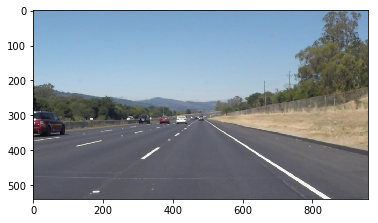

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# Tools available:
#     color selection, 
#     region of interest selection, 
#     grayscaling, 
#     Gaussian smoothing, 
#     Canny Edge Detection and 
#     Hough Tranform line detection
# Other techniques that can be explored
# 
#     cv2.inRange() for color selection
#     cv2.fillPoly() for regions selection
#     cv2.line() to draw lines on an image given endpoints
#     cv2.addWeighted() to coadd / overlay two images cv2.cvtColor() to grayscale or change color cv2.imwrite() to output images to file
#     cv2.bitwise_and() to apply a mask to an image
#
# Objective:
#     Create a pipeline that does these things
#         Detect the line segments in the image 
#         Average/extrapolate them 
#         Draw them onto the image for display
# Proposed Pipeline
#     1.) Grayscale image
#     2.) Capture region of interest
#     3.) Detect edges using Canny Edge Detection
#     4.) Detect lines using Hough Transform line detection
#     5.) Extrapolate lines
#     6.) Draw extrapolated lines to display


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


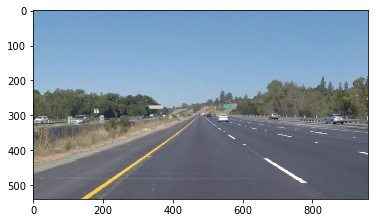

In [82]:
#reading in an image
image = mpimg.imread('test_images/solidYellowLeft.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  
# if you wanted to show a single color channel image called 'gray', 
# for example, call as plt.imshow(gray, cmap='gray')

In [111]:
def get_interpolated_lines(twolines, imshape, pos_slope, neg_slope, two_midpoints, max_y, min_y):
    interpolatedlines=np.ndarray(shape=(4,1,4), dtype=int)
    slopes=[pos_slope,neg_slope]
    #slopes=[]
#     for line in twolines:
#         for x1,y1,x2,y2 in line:
#             slope=float(y2-y1)/(x2-x1)
#             slopes.append(slope)
    #print(slopes)
    for ipt in range(2):
        points = two_midpoints[ipt]
        for x,y in points:
            x1=x
            y1=y
            y2=max_y
            x2=int(x1+((y2-y1)/slopes[ipt]))
        interpolatedlines[ipt]=(x1,y1,x2,y2)
    for ipt in range(2):
        points = two_midpoints[ipt]
        for x,y in points:
            x1=x
            y1=y
            y2=min_y
            x2=int(x1+((y2-y1)/slopes[ipt]))
        interpolatedlines[ipt+2]=(x1,y1,x2,y2)
    
    return interpolatedlines

[[713 452]] [[303 421]]
(540, 960, 3)
-0.72115 [(183, 521, 287, 446)]
-0.68116 [(311, 421, 380, 374)]
-0.67708 [(138, 539, 330, 409)]
-0.73171 [(284, 449, 325, 419)]
-0.75 [(341, 408, 417, 351)]
-0.78947 [(417, 352, 455, 322)]
-0.72857 [(375, 377, 445, 326)]
-0.92308 [(443, 327, 469, 303)]
-0.71429 [(158, 538, 207, 503)]
-0.67742 [(264, 453, 295, 432)]
0.53846 [[661 424 765 480]]
-0.71299 [[138 539 469 303]]
0.62857 [[713 452 853 540]]
-0.73913 [[303 421 142 540]]
0.63136 [[713 452 477 303]]
-0.74684 [[303 421 461 303]]


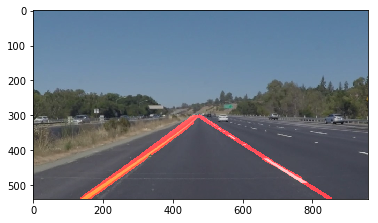

In [112]:
img=grayscale(image)
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
img = gaussian_blur(img, kernel_size)

imshape = img.shape
vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*9/16), (imshape[1]*9/16, imshape[0]*9/16), (imshape[1],imshape[0])]], dtype=np.int32)
#img=region_of_interest(img, vertices)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = canny(img, low_threshold, high_threshold)

#plt.imshow(img)


# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask
imshape = image.shape
#vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
#vertices = np.array([[(0,imshape[0]),(imshape[1]/2, imshape[0]/2), (imshape[1]/2, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*9/16), (imshape[1]*9/16, imshape[0]*9/16), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 25 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

#interpolate ines based on their slopes
slopes={}
for line in lines:
    for x1,y1,x2,y2 in line:
        slope = round(float(y2-y1)/(x2-x1),5)
        if slope in slopes.keys():
            slopes[slope].append((x1,y1,x2,y2))
        else:
            slopes[slope]=[]
            slopes[slope].append((x1,y1,x2,y2))

newlines=np.ndarray(shape=(len(slopes.keys()),1,4), dtype=int)
for idx in range(len(slopes.keys())):
    all_keys=list(slopes.keys())
    slope = all_keys[idx]
    #print(slope, slopes[slope])
    if len(slopes[slope])==1:
        newlines[idx]=slopes[slope]
    else:
        x1,y1,x2,y2=slopes[slope][0]
        for jdx in range(1,len(slopes[slope])):
            x1_new,y1_new,x2_new,y2_new=slopes[slope][jdx]
            #if slope is positive, pick max x2 and max y2, min x1, min y1
            #print(x1_new,y1_new,x2_new,y2_new)
            if slope>0:
                x1=min(x1,x1_new)
                y1=min(y1,y1_new)
                x2=max(x2,x2_new)
                y2=max(y2,y2_new)
            else:
                x1=min(x1,x1_new)
                y1=max(y1,y1_new)
                x2=max(x2,x2_new)
                y2=min(y2,y2_new)
        newlines[idx]=(x1,y1,x2,y2)
    #print(newlines)

twolines=np.ndarray(shape=(2,1,4), dtype=int)
slopes_dict={'pos':[],'neg':[]}
for idx in range(len(slopes.keys())):
    all_keys=list(slopes.keys())
    slope = all_keys[idx]
    if slope>0:
        slopes_dict['pos'].append(slopes[slope])
    else:
        slopes_dict['neg'].append(slopes[slope])
#print(slopes_dict)
x1,y1,x2,y2=[imshape[1], imshape[0], 0, 0]
pos_slope=0
pos_count=0
for line in slopes_dict['pos']:
    for x1_new,y1_new,x2_new,y2_new in line:
        pos_count+=1
        pos_slope+=float(y2_new-y1_new)/(x2_new-x1_new)
        x1=min(x1,x1_new)
        y1=min(y1,y1_new)
        x2=max(x2,x2_new)
        y2=max(y2,y2_new)
    twolines[0]=(x1,y1,x2,y2)
pos_slope/=pos_count

x1,y1,x2,y2=[imshape[1], 0, 0, imshape[0]]
neg_slope=0
neg_count=0
for line in slopes_dict['neg']:
    for x1_new,y1_new,x2_new,y2_new in line:
        neg_count+=1
        neg_slope+=float(y2_new-y1_new)/(x2_new-x1_new)
        x1=min(x1,x1_new)
        y1=max(y1,y1_new)
        x2=max(x2,x2_new)
        y2=min(y2,y2_new)
    twolines[1]=(x1,y1,x2,y2)
neg_slope/=neg_count

#extrapolate slopes to get line with max y
two_midpoints=np.ndarray(shape=(2,1,2), dtype=int)
for idx in range(2):
    line = twolines[idx]
    for x1,y1,x2,y2 in line:
        x_mid=int((x1+x2)/2)
        y_mid=int((y1+y2)/2)
        #print(x1,y1,x2,y2,x_mid,y_mid)
        two_midpoints[idx]=(x_mid,y_mid)

print(two_midpoints[0],two_midpoints[1])
interpolatedlines=get_interpolated_lines(twolines, imshape, pos_slope, neg_slope, two_midpoints, imshape[0], imshape[0]*9/16)
print(imshape)
#print(type(lines),type(lines[0]),lines[0],lines.shape)
#print(type(newlines),type(newlines[0]),newlines[0],newlines.shape)
#print(type(twolines),type(twolines[0]),twolines[0],twolines.shape)
# Iterate over the output "lines" and draw lines on a blank image
# for line in lines:
#     for x1,y1,x2,y2 in line:
#         #print(x1,x2,y1,y2)
#         print(round(float(y2-y1)/(x2-x1),5),line)
#         cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
for line in slopes_dict['neg']:
    for x1,y1,x2,y2 in line:
        #print(x1,x2,y1,y2)
        print(round(float(y2-y1)/(x2-x1),5),line)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
# for line in newlines:
#     for x1,y1,x2,y2 in line:
#         #print(x1,x2,y1,y2)
#         print(round(float(y2-y1)/(x2-x1),5),line)
#         cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
for line in twolines:
    for x1,y1,x2,y2 in line:
        #print(x1,x2,y1,y2)
        print(round(float(y2-y1)/(x2-x1),5),line)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
for line in interpolatedlines:
    for x1,y1,x2,y2 in line:
        #print(x1,x2,y1,y2)
        print(round(float(y2-y1)/(x2-x1),5),line)
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
#plt.imshow(color_edges)
# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
#plt.imshow(lines_edges)
final_image = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(final_image)

In [56]:
image.shape

(540, 960, 3)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [865]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [866]:
from sklearn import linear_model

def get_two_lines(all_segments, max_y=540,min_y=324):
    twolines=np.ndarray(shape=(2,1,4), dtype=int)
    twolines*=0
    #slopes_dict={'pos':[],'neg':[]}
    
    pos_segments=all_segments['pos_orig']
    neg_segments=all_segments['neg_orig']
        
#     pos_slope=get_avg_slope(pos_segments)
#     neg_slope=get_avg_slope(neg_segments)
    
#     print('pos_slope:',pos_slope, 'neg_slope:',neg_slope)
#     print('pos:',pos_segments)
#     print('neg:',neg_segments)
    
    def run_regression(segments):
        X=np.ndarray(shape=(len(segments)*2,1),dtype=int)
        Y=np.ndarray(shape=(len(segments)*2,1),dtype=int)
        #pos_X=[];pos_Y=[]
        for idx in range(len(segments)):
            segment = segments[idx]
            sx1=segment[0];sy1=segment[1];sx2=segment[2];sy2=segment[3];
            X[2*idx]=sx1;X[2*idx+1]=sx2;
            Y[2*idx]=sy1;Y[2*idx+1]=sy2;

        regr = linear_model.LinearRegression()
        regr.fit(X, Y)
        print('Coefficients:', regr.coef_, 'Intercept:',regr.intercept_)
        reg_m=regr.coef_; reg_c=int(regr.intercept_)
        
        return [reg_m,reg_c]
    
    if len(pos_segments)>0:
        preg_m,preg_c=run_regression(pos_segments)
        pmax_x= int((max_y-preg_c)/preg_m)
        pmin_x= int((min_y-preg_c)/preg_m)
        print('new_pt:',pmin_x,min_y,pmax_x,max_y)
        twolines[0]=(pmin_x,min_y,pmax_x,max_y)
    else:
        twolines[0]=(0,0,0,0)
    
    if len(neg_segments)>0:
        nreg_m,nreg_c=run_regression(neg_segments)
        nmin_x= int((max_y-nreg_c)/nreg_m)
        nmax_x= int((min_y-nreg_c)/nreg_m)
        print('new_pt:',nmin_x,max_y,nmax_x,min_y)
        twolines[1]=(nmin_x,max_y,nmax_x,min_y)
    else:
        twolines[1]=(0,0,0,0)
    
    return twolines

def connect_broken_lines(lines):
    my_lines=np.copy(lines)
    
    #rlines=my_lines[my_lines[:,0].argsort()]
    rlines=my_lines[my_lines[:,0][:,0].argsort()]
    
    #print(rlines)
    #find complete segments
    all_segments={'pos':[],'neg':[], 'pos_orig':[],'neg_orig':[]}

    for line in rlines:
        for x1,y1,x2,y2 in line:
            slope = round(float(y2-y1)/(x2-x1),3)
            #print(slope,line)
            if slope>0:
                all_segments['pos_orig'].append((x1,y1,x2,y2))
                #print(slope,line)
                if len(all_segments['pos'])==0:
                    all_segments['pos'].append((x1,y1,x2,y2))
                else:
                    pos_segments=all_segments['pos']
                    pt_processed=False
                    for segment_num in range(len(pos_segments)):
                        segment = pos_segments[segment_num]
                        #print(segment)
                        sx1=segment[0];sy1=segment[1];sx2=segment[2];sy2=segment[3];
                        #print(sx1,sy1,sx2,sy2)
                        if x1>sx1 and x1<sx2:
                            #new point is in the middle of segment
                            if x2>sx2:
                                #sx2=x2
                                #sy2=y2
                                all_segments['pos'][segment_num]=(sx1,sy1,x2,y2)
                            pt_processed=True
                            break
                        elif x1>sx2:
                            #add new segment
                            pt_processed=False
                    if pt_processed==False:
                        all_segments['pos'].append((x1,y1,x2,y2))
            else:
                all_segments['neg_orig'].append((x1,y1,x2,y2))
                if len(all_segments['neg'])==0:
                    all_segments['neg'].append((x1,y1,x2,y2))
                else:
                    neg_segments=all_segments['neg']
                    pt_processed=False
                    for segment_num in range(len(neg_segments)):
                        segment = neg_segments[segment_num]
                        #print(segment)
                        sx1=segment[0];sy1=segment[1];sx2=segment[2];sy2=segment[3];
                        #print(sx1,sy1,sx2,sy2)
                        if x1>sx1 and x1<sx2:
                            #new point is in the middle of segment
                            if x2>sx2:
                                #sx2=x2
                                #sy2=y2
                                all_segments['neg'][segment_num]=(sx1,sy1,x2,y2)
                            pt_processed=True
                            break
                        elif x1>sx2:
                            #add new segment
                            pt_processed=False
                    if pt_processed==False:
                        all_segments['neg'].append((x1,y1,x2,y2))
                
#     print('pos:', all_segments['pos'])
#     print('neg:', all_segments['neg'])
    
    num_of_broken_segments_pos=0;num_of_extrapolated_segments_pos=0
    if len(all_segments['pos'])>0:
        num_of_broken_segments_pos=len(all_segments['pos'])-1
#         num_of_extrapolated_segments_pos=1
    
    num_of_broken_segments_neg=0;num_of_extrapolated_segments_neg=0
    if len(all_segments['neg'])>0:
        num_of_broken_segments_neg=len(all_segments['neg'])-1
#         num_of_extrapolated_segments_neg=1
    
    total_interpolated = num_of_broken_segments_pos + num_of_broken_segments_neg# + num_of_extrapolated_segments_pos + num_of_extrapolated_segments_neg
    #create interpolated_segments
    interpolated = np.ndarray(shape=(total_interpolated,1,4), dtype=int)
    pos_interpolated = np.ndarray(shape=(num_of_broken_segments_pos,1,4), dtype=int)
    
    pos_segments=all_segments['pos']
    for idx_pos in range(len(pos_segments)):
        segment=pos_segments[idx_pos]
        #print(idx_pos,segment)
        if idx_pos==0:
            startx=segment[2];starty=segment[3]
            continue
        endx=segment[0];endy=segment[1]
        pos_interpolated[idx_pos-1]=(startx,starty,endx,endy)
        interpolated[idx_pos-1]=(startx,starty,endx,endy)
        startx=segment[2];starty=segment[3]
    #print(pos_interpolated)
    
#     for interpolated_line in pos_interpolated:
#         for x1,y1,x2,y2 in interpolated_line:
#             print('pos_interpolated:',interpolated_line)
    #print(pos_interpolated)
    
    neg_interpolated = np.ndarray(shape=(num_of_broken_segments_neg,1,4), dtype=int)
    neg_segments=all_segments['neg']
    for idx_neg in range(len(neg_segments)):
        segment=neg_segments[idx_neg]
        #print(idx_neg,segment)
        if idx_neg==0:
            startx=segment[2];starty=segment[3]
            continue
        endx=segment[0];endy=segment[1]
        neg_interpolated[idx_neg-1]=(startx,starty,endx,endy)
        interpolated[num_of_broken_segments_pos+idx_neg-1]=(startx,starty,endx,endy)
        startx=segment[2];starty=segment[3]
    #print(neg_interpolated)
    
#     for interpolated_line in neg_interpolated:
#         for x1,y1,x2,y2 in interpolated_line:
#             print('neg_interpolated:',interpolated_line)

#     pos_segments=all_segments['pos']
#     if len(pos_segments)>0:
#         if len(pos_segments)==1:
#             #pass this to get 
#             print(1,pos_segments)
#         else:
#             print(len(pos_segments),pos_segments)
#         segment_0=get_extrapolated_segment(pos_segments[len(pos_segments)-1])
#         print(segment_0)
#         interpolated[num_of_broken_segments_pos+num_of_broken_segments_neg]=segment_0
# #             segment_1=get_extrapolated_segment(pos_segments[0])
#     if len(neg_segments)>0:
#         if len(neg_segments)==1:
#             #pass this to get 
#             print(1,neg_segments)
#         else:
#             print(len(neg_segments),neg_segments)
#         segment_0=get_extrapolated_segment(neg_segments[len(neg_segments)-1])
#         print(segment_0)
#         interpolated[num_of_broken_segments_pos+num_of_broken_segments_neg+num_of_extrapolated_segments_pos]=segment_0
# #             segment_1=get_extrapolated_segment(neg_segments[0])
            
    min_slope=0.4; max_slope=0.8
    filtered = filter_lines_based_on_slope(interpolated, min_slope, max_slope)
#     return filtered



    twolines=get_two_lines(all_segments)
    
    return [filtered, twolines]

def get_extrapolated_segment(segment,max_y=540, min_y=324):
    sx1=segment[0];sy1=segment[1];sx2=segment[2];sy2=segment[3];
    slope=round(float(sy2-sy1)/(sx2-sx1),3)
    
    if slope>0:
        slope=0.6;x1=sx2-10;y1=sy2;
    else:
        slope=-0.6;x1=sx1+10;y1=sy1;
    y2=max_y
    x2=int(x1+((y2-y1)/slope))
    return (x1,y1,x2,y2)


def get_avg_slope(segments):
    sum_slope=0.0
    for segment in segments:
        sx1=segment[0];sy1=segment[1];sx2=segment[2];sy2=segment[3];
        slope=float(sy2-sy1)/(sx2-sx1)
        sum_slope += slope
    len_segments=len(segments)
    if len_segments==0:
        len_segments=1
        print('segments:',segments)
        input()
    avg_slope = sum_slope/len_segments
    return avg_slope

def filter_lines_based_on_slope(lines, min_slope, max_slope):
    #get number of lines meeting slope criterion
    num_of_lines = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print(x1,x2,y1,y2)
            slope=round(float(y2-y1)/(x2-x1),3)
            if abs(slope)> min_slope and abs(slope) < max_slope:
                num_of_lines +=1
    #allocate space of filtered lines
    rlines = np.ndarray(shape=(num_of_lines,1,4), dtype=int)
    idx = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print(x1,x2,y1,y2)
            slope=round(float(y2-y1)/(x2-x1),3)
            if abs(slope)> min_slope and abs(slope) <max_slope:
                #print(round(float(y2-y1)/(x2-x1),3),line)
                rlines[idx]=(x1,y1,x2,y2)
                idx +=1
    
    return rlines


def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    img=grayscale(image)
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    img = gaussian_blur(img, kernel_size)

    imshape = img.shape
    #vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*9/16), (imshape[1]*9/16, imshape[0]*9/16), (imshape[1],imshape[0])]], dtype=np.int32)
    #img=region_of_interest(img, vertices)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(img, low_threshold, high_threshold)

    #plt.imshow(img)


    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(imshape[1]/2, imshape[0]/2), (imshape[1]/2, imshape[0]/2), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(imshape[1]*7/16, imshape[0]*9/16), (imshape[1]*9/16, imshape[0]*9/16), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(imshape[1]*3/8, imshape[0]*5/8), (imshape[1]*5/8, imshape[0]*5/8), (imshape[1],imshape[0])]], dtype=np.int32)
    #vertices = np.array([[(0,imshape[0]),(imshape[1]*4/10, imshape[0]*6/10), (imshape[1]*6/10, imshape[0]*6/10), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices = np.array([[(imshape[1]*1/10,imshape[0]),(imshape[1]*4/10, imshape[0]*6/10), (imshape[1]*6/10, imshape[0]*6/10), (imshape[1]*9/10,imshape[0])]], dtype=np.int32)
    max_y = imshape[0]
    min_y = imshape[0]*6/10#imshape[0]*5/8#imshape[0]*9/16
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                min_line_length, max_line_gap)

    #filter lines based on slope
    #remove close to horizontal or vertical lines
    min_slope=0.4
    max_slope=0.8
    lines = filter_lines_based_on_slope(lines, min_slope, max_slope)
    
#     inter_image = cv2.addWeighted(image, 0.8, line_image, 1, 0)
#     plt.imshow(inter_image)
    interpolatedlines,twolines = connect_broken_lines(lines)
    
#     #interpolate lines based on their slopes
#     slopes={}
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             slope = round(float(y2-y1)/(x2-x1),5)
#             if slope in slopes.keys():
#                 slopes[slope].append((x1,y1,x2,y2))
#             else:
#                 slopes[slope]=[]
#                 slopes[slope].append((x1,y1,x2,y2))

#     newlines=np.ndarray(shape=(len(slopes.keys()),1,4), dtype=int)
#     for idx in range(len(slopes.keys())):
#         all_keys=list(slopes.keys())
#         slope = all_keys[idx]
#         #print(slope, slopes[slope])
#         if len(slopes[slope])==1:
#             newlines[idx]=slopes[slope]
#         else:
#             x1,y1,x2,y2=slopes[slope][0]
#             for jdx in range(1,len(slopes[slope])):
#                 x1_new,y1_new,x2_new,y2_new=slopes[slope][jdx]
#                 #if slope is positive, pick max x2 and max y2, min x1, min y1
#                 #print(x1_new,y1_new,x2_new,y2_new)
#                 if slope>0:
#                     x1=min(x1,x1_new)
#                     y1=min(y1,y1_new)
#                     x2=max(x2,x2_new)
#                     y2=max(y2,y2_new)
#                 else:
#                     x1=min(x1,x1_new)
#                     y1=max(y1,y1_new)
#                     x2=max(x2,x2_new)
#                     y2=min(y2,y2_new)
#             newlines[idx]=(x1,y1,x2,y2)
#         #print(newlines)

#     twolines=np.ndarray(shape=(2,1,4), dtype=int)
#     slopes_dict={'pos':[],'neg':[]}
#     for idx in range(len(slopes.keys())):
#         all_keys=list(slopes.keys())
#         slope = all_keys[idx]
#         if slope>0:
#             slopes_dict['pos'].append(slopes[slope])
#         else:
#             slopes_dict['neg'].append(slopes[slope])
#     #print(slopes_dict)
#     x1,y1,x2,y2=[imshape[1], imshape[0], 0, 0]
#     pos_slope=0
#     pos_count=0
#     for line in slopes_dict['pos']:
#         for x1_new,y1_new,x2_new,y2_new in line:
#             pos_count+=1
#             pos_slope+=float(y2_new-y1_new)/(x2_new-x1_new)
#             x1=min(x1,x1_new)
#             y1=min(y1,y1_new)
#             x2=max(x2,x2_new)
#             y2=max(y2,y2_new)
#         twolines[0]=(x1,y1,x2,y2)
#     pos_slope/=pos_count

#     x1,y1,x2,y2=[imshape[1], 0, 0, imshape[0]]
#     neg_slope=0
#     neg_count=0
#     for line in slopes_dict['neg']:
#         for x1_new,y1_new,x2_new,y2_new in line:
#             neg_count+=1
#             neg_slope+=float(y2_new-y1_new)/(x2_new-x1_new)
#             x1=min(x1,x1_new)
#             y1=max(y1,y1_new)
#             x2=max(x2,x2_new)
#             y2=min(y2,y2_new)
#         twolines[1]=(x1,y1,x2,y2)
#     #plt.imshow(image)
#     neg_slope/=neg_count

#     #extrapolate slopes to get line with max y
#     two_midpoints=np.ndarray(shape=(2,1,2), dtype=int)
#     for idx in range(2):
#         line = twolines[idx]
#         for x1,y1,x2,y2 in line:
#             x_mid=int((x1+x2)/2)
#             y_mid=int((y1+y2)/2)
#             #print(x1,y1,x2,y2,x_mid,y_mid)
#             two_midpoints[idx]=(x_mid,y_mid)

    #print(two_midpoints[0],two_midpoints[1])
    #interpolatedlines=get_interpolated_lines(twolines, imshape, pos_slope, neg_slope, two_midpoints, max_y, min_y)
    #print(imshape)
    #print(type(lines),type(lines[0]),lines[0],lines.shape)
    #print(type(newlines),type(newlines[0]),newlines[0],newlines.shape)
    #print(type(twolines),type(twolines[0]),twolines[0],twolines.shape)
    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print(x1,x2,y1,y2)
            #slope=round(float(y2-y1)/(x2-x1),3)
            #if abs(slope)> 0.4 and abs(slope) <0.8:
            #print(round(float(y2-y1)/(x2-x1),3),line)
            cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),10)
#     for line in slopes_dict['neg']:
#         for x1,y1,x2,y2 in line:
#             #print(x1,x2,y1,y2)
#             #print(round(float(y2-y1)/(x2-x1),5),line)
#             cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
#     for line in newlines:
#         for x1,y1,x2,y2 in line:
#             #print(x1,x2,y1,y2)
#             slope=round(float(y2-y1)/(x2-x1),3)
#             if abs(slope)> 0.4 and abs(slope) <0.8:
#                 #print(round(float(y2-y1)/(x2-x1),5),line)
#                 cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
    for line in twolines:
        for x1,y1,x2,y2 in line:
            #print(x1,x2,y1,y2)
            #print(round(float(y2-y1)/(x2-x1),5),line)
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
#     for line in interpolatedlines:
#         for x1,y1,x2,y2 in line:
#             #print(x1,x2,y1,y2)
#             #print(round(float(y2-y1)/(x2-x1),5),line)
#             cv2.line(line_image,(x1,y1),(x2,y2),(0,128,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges, edges, edges)) 
    #plt.imshow(color_edges)
    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
    #plt.imshow(lines_edges)
    final_image = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    #plt.imshow(final_image)
    return final_image

In [867]:
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg']

Coefficients: [[ 0.61195128]] Intercept: [ 18.98526145]
new_pt: 500 324 853 540
Coefficients: [[-0.7269503]] Intercept: [ 657.2396983]
new_pt: 160 540 458 324


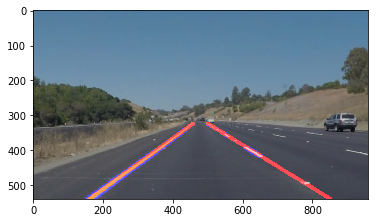

In [868]:
my_img = mpimg.imread('test_images/solidYellowCurve.jpg')
plt.imshow(process_image(my_img))

Coefficients: [[ 0.60784817]] Intercept: [ 16.53868639]
new_pt: 506 324 862 540
Coefficients: [[-0.73846943]] Intercept: [ 661.55447647]
new_pt: 163 540 456 324


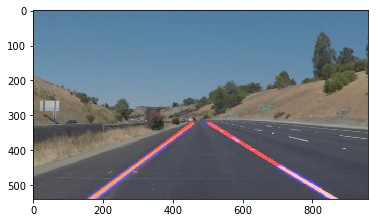

In [869]:
my_img = mpimg.imread('test_images/solidYellowCurve2.jpg')
plt.imshow(process_image(my_img))

Coefficients: [[ 0.5863131]] Intercept: [ 27.24423126]
new_pt: 506 324 874 540
Coefficients: [[-0.71799572]] Intercept: [ 662.50320642]
new_pt: 169 540 470 324


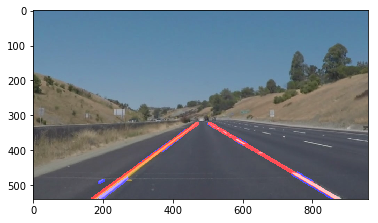

In [870]:
my_img = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
plt.imshow(process_image(my_img))

Coefficients: [[ 0.61199346]] Intercept: [ 15.3364357]
new_pt: 504 324 857 540
Coefficients: [[-0.71907833]] Intercept: [ 649.56719842]
new_pt: 151 540 451 324


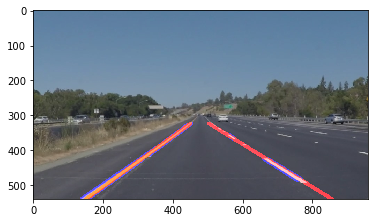

In [871]:
my_img = mpimg.imread('test_images/solidYellowLeft.jpg')
plt.imshow(process_image(my_img))

Coefficients: [[ 0.56964104]] Intercept: [ 35.49635256]
new_pt: 507 324 886 540
Coefficients: [[-0.73954308]] Intercept: [ 665.99517365]
new_pt: 169 540 461 324


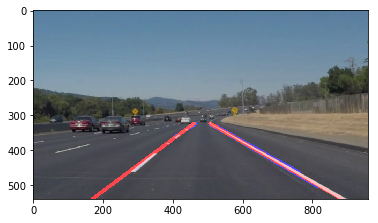

In [872]:
my_img = mpimg.imread('test_images/solidWhiteCurve.jpg')
plt.imshow(process_image(my_img))

Coefficients: [[ 0.64149309]] Intercept: [-2.57961432]
new_pt: 508 324 844 540
Coefficients: [[-0.62622054]] Intercept: [ 618.29169379]
new_pt: 124 540 469 324


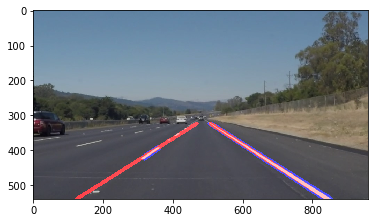

In [873]:
my_img = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(process_image(my_img))

Let's try the one with the solid white lane on the right first ...

In [876]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Coefficients: [[ 0.6129404]] Intercept: [ 11.46038175]
new_pt: 510 324 863 540
Coefficients: [[-0.72708224]] Intercept: [ 652.6443164]
new_pt: 154 540 451 324
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4







  0%|          | 0/222 [00:00<?, ?it/s]




  2%|▏         | 4/222 [00:00<00:05, 39.69it/s]

Coefficients: [[ 0.6129404]] Intercept: [ 11.46038175]
new_pt: 510 324 863 540
Coefficients: [[-0.72708224]] Intercept: [ 652.6443164]
new_pt: 154 540 451 324
Coefficients: [[ 0.62352834]] Intercept: [ 6.92639063]
new_pt: 510 324 856 540
Coefficients: [[-0.72257541]] Intercept: [ 650.33721]
new_pt: 152 540 451 324
Coefficients: [[ 0.61469468]] Intercept: [ 12.28929492]
new_pt: 507 324 858 540
Coefficients: [[-0.74242465]] Intercept: [ 656.20681412]
new_pt: 156 540 447 324
Coefficients: [[ 0.62797825]] Intercept: [ 3.72352318]
new_pt: 511 324 855 540
Coefficients: [[-0.73150122]] Intercept: [ 653.71312329]
new_pt: 154 540 449 324
Coefficients: [[ 0.60903435]] Intercept: [ 12.09854169]
new_pt: 512 324 866 540
Coefficients: [[-0.63422154]] Intercept: [ 616.72737283]
new_pt: 119 540 460 324







  3%|▎         | 7/222 [00:00<00:06, 35.34it/s]

Coefficients: [[ 0.61320633]] Intercept: [ 10.34096281]
new_pt: 512 324 864 540
Coefficients: [[-0.67079759]] Intercept: [ 630.93581188]
new_pt: 134 540 456 324
Coefficients: [[ 0.61245189]] Intercept: [ 11.25837312]
new_pt: 511 324 863 540
Coefficients: [[-0.65395967]] Intercept: [ 624.88637482]
new_pt: 128 540 458 324


Coefficients: [[ 0.60589559]] Intercept: [ 13.95926423]
new_pt: 513 324 869 540
Coefficients: [[-0.6497231]] Intercept: [ 623.7213212]
new_pt: 127 540 460 324
Coefficients: [[ 0.63107356]] Intercept: [ 0.62181531]
new_pt: 513 324 855 540
Coefficients: [[-0.72191155]] Intercept: [ 649.95674731]
new_pt: 150 540 450 324
Coefficients: [[ 0.62963774]] Intercept: [ 4.95532649]
new_pt: 508 324 851 540
Coefficients: [[-0.71278919]] Intercept: [ 649.69842749]
new_pt: 152 540 455 324
Coefficients: [[ 0.63010538]] Intercept: [ 5.77232732]
new_pt: 506 324 849 540
Coefficients:






  5%|▍         | 11/222 [00:00<00:06, 33.30it/s]

 [[-0.73780225]] Intercept: [ 660.41425006]
new_pt: 162 540 455 324
Coefficients:

 [[ 0.63542673]] Intercept: [ 2.79735071]
new_pt: 506 324 846 540
Coefficients: [[-0.71010838]] Intercept: [ 649.36632133]
new_pt: 153 540 457 324
Coefficients: [[ 0.61411414]] Intercept: [ 16.67708599]
new_pt: 501 324 853 540
Coefficients: [[-0.72947009]] Intercept: [ 656.07728399]
new_pt: 159 540 455 324
Coefficients: [[ 0.63923122]] Intercept: 






  6%|▋         | 14/222 [00:00<00:06, 30.71it/s]

[-0.13395119]
new_pt: 506 324 844 540
Coefficients: [[-0.71852353]] Intercept: [ 649.65832597]
new_pt: 151 540 452 324
Coefficients: [[ 0.64294235]] Intercept: [-4.24582317]
new_pt: 510 324 846 540
Coefficients: [[-0.70532811]] Intercept: [ 641.44702262]
new_pt: 143 540 449 324
Coefficients: [[ 0.64023053]] Intercept: [-3.3393219]
new_pt: 510 324 848 540
Coefficients: [[-0.69952463]] Intercept: [ 639.71243707]
new_pt: 141 540 450 324


Coefficients: [[ 0.63432924]] Intercept: [-0.51615338]
new_pt: 510 324 851 540
Coefficients: [[-0.70635998]] Intercept: [ 640.80943597]
new_pt: 141 540 447 324
Coefficients: [[ 0.6410993]] Intercept: [-3.45490874]
new_pt: 510 324 846 540
Coefficients: [[-0.63837442]] Intercept: [ 615.67701532]
new_pt: 117 540 455 324







  8%|▊         | 18/222 [00:00<00:06, 31.81it/s]

Coefficients: [[ 0.64555678]] Intercept: [-5.12731619]
new_pt: 509 324 844 540
Coefficients: [[-0.62836373]] Intercept: [ 614.34051779]
new_pt: 117 540 461 324
Coefficients: [[ 0.63522816]] Intercept: [ 1.03801437]
new_pt: 508 324 848 540
Coefficients: [[-0.67211649]] Intercept: [ 633.7845191]
new_pt: 138 540 459 324







 10%|▉         | 22/222 [00:00<00:06, 32.01it/s]

Coefficients: [[ 0.63230357]] Intercept: [ 4.09636447]
new_pt: 506 324 847 540
Coefficients: [[-0.67761996]] Intercept: [ 637.79324376]
new_pt: 143 540 461 324
Coefficients: [[ 0.63557852]] Intercept: [ 3.6924888]
new_pt: 505 324 844 540
Coefficients: [[-0.70972921]] Intercept: [ 646.13867429]
new_pt: 149 540 453 324
Coefficients: [[ 0.63450889]] Intercept: [ 0.34935523]
new_pt: 510 324 851 540
Coefficients: [[-0.72615381]] Intercept: [ 652.96537354]
new_pt: 154 540 451 324


Coefficients: [[ 0.61987161]] Intercept: [ 10.96227864]
new_pt: 506 324 855 540
Coefficients: [[-0.70082898]] Intercept: [ 643.7831082]
new_pt: 146 540 455 324
Coefficients: [[ 0.62810747]] Intercept: [ 6.39284268]
new_pt: 506 324 850 540
Coefficients: [[-0.72092824]] Intercept: [ 650.39618886]
new_pt: 152 540 452 324
Coefficients: [[ 0.65892589]] Intercept: [-14.04790743]
new_pt: 512 324 840 540
Coefficients: [[-0.69240521]] Intercept: [ 639.11791901]
new_pt: 142 540 454 324







 12%|█▏        | 26/222 [00:00<00:05, 33.21it/s]

Coefficients: [[ 0.64367379]] Intercept: [-1.86818169]
new_pt: 504 324 840 540
Coefficients: [[-0.69680539]] Intercept: [ 642.27991111]
new_pt: 146 540 456 324
Coefficients: [[ 0.63484115]] Intercept: [ 0.4225306]
new_pt: 510 324 850 540
Coefficients: [[-0.69409796]] Intercept: [ 640.9891607]
new_pt: 144 540 455 324







 14%|█▎        | 30/222 [00:00<00:05, 33.13it/s]

Coefficients: [[ 0.64382681]] Intercept: [-4.27156443]
new_pt: 509 324 844 540
Coefficients: [[-0.67554489]] Intercept: [ 635.84991019]
new_pt: 140 540 460 324
Coefficients: [[ 0.64650151]] Intercept: [-5.307252]
new_pt: 508 324 842 540
Coefficients: [[-0.67425228]] Intercept: [ 633.88621586]
new_pt: 137 540 458 324


Coefficients: [[ 0.65810364]] Intercept: [-13.46026854]
new_pt: 512 324 840 540
Coefficients: [[-0.7209352]] Intercept: [ 650.32155439]
new_pt: 152 540 452 324
Coefficients: [[ 0.64799832]] Intercept: [-7.96153161]
new_pt: 510 324 844 540
Coefficients: [[-0.6752388]] Intercept: [ 632.82072006]
new_pt: 136 540 456 324
Coefficients: [[ 0.6279316]] Intercept: [ 4.15025668]
new_pt: 509 324 853 540
Coefficients: [[-0.67891811]] Intercept: [ 636.52783539]
new_pt: 141 540 459 324
Coefficients: [[ 0.64440408]] Intercept: [-4.80985144]






 15%|█▌        | 34/222 [00:01<00:06, 29.46it/s]


new_pt: 508 324 844 540
Coefficients: [[-0.69240877]] Intercept: [ 640.99568253]
new_pt: 144 540 456 324
Coefficients: [[ 0.63917994]] Intercept: [-1.64167372]
new_pt: 508 324 846 540
Coefficients: [[-0.70375406]] Intercept: [ 645.07876842]
new_pt: 149 540 456 324
Coefficients: [[ 0.63966386]] Intercept: [-1.12923664]
new_pt: 508 324 845 540
Coefficients: [[-0.72467126]] Intercept: [ 653.84283031]
new_pt: 155 540 453 324







 17%|█▋        | 37/222 [00:01<00:06, 29.29it/s]

Coefficients: [[ 0.63648559]] Intercept: [ 1.80396328]
new_pt: 507 324 846 540
Coefficients: [[-0.70523662]] Intercept: [ 646.9333135]
new_pt: 150 540 456 324
Coefficients: [[ 0.63888528]] Intercept: [-0.85265766]
new_pt: 507 324 845 540
Coefficients: [[-0.71496271]] Intercept: [ 650.80404757]
new_pt: 153 540 455 324
Coefficients: [[ 0.63198107]] Intercept: [ 2.66767591]
new_pt: 509 324 851 540
Coefficients: [[-0.70603558]] Intercept: [ 647.15677568]
new_pt: 151 540 457 324
Coefficients: [[ 0.65202744]] Intercept: [-10.00150351]
new_pt: 512 324 843 540
Coefficients: [[-0.70530292]] Intercept: [ 645.06290566]
new_pt: 






 18%|█▊        | 41/222 [00:01<00:05, 30.85it/s]

148 540 455 324
Coefficients: [[ 0.65657705]] Intercept: [-12.41828093]
new_pt: 511 324 840 540
Coefficients: [[-0.70887348]] Intercept: [ 646.39993068]
new_pt: 149 540 454 324
Coefficients: [[ 0.66535731]] Intercept: [-18.73750384]
new_pt: 514 324 838 540
Coefficients: [[-0.6492398]] Intercept: [ 621.94131768]
new_pt: 124 540 457 324
Coefficients: [[ 0.65965761]] Intercept: [-15.93854396]
new_pt: 513 324 841 540
Coefficients: [[-0.70250974]] Intercept: [ 640.65664215]
new_pt: 142 540 449 324


Coefficients: [[ 0.64197713]] Intercept: [-5.70679085]
new_pt: 512 324 848 540
Coefficients: [[-0.66126756]] Intercept: [ 625.65535318]
new_pt: 128 540 455 324
Coefficients: [[ 0.65488458]] Intercept: [-13.05522049]
new_pt: 514 324 844 540
Coefficients: [[-0.68697385]] Intercept: [ 635.51489415]
new_pt: 138 540 452 324







 20%|██        | 45/222 [00:01<00:05, 30.40it/s]

Coefficients: [[ 0.6616022]] Intercept: [-15.87015848]
new_pt: 512 324 838 540
Coefficients: [[-0.75844276]] Intercept: [ 661.65473843]
new_pt: 159 540 444 324







 22%|██▏       | 49/222 [00:01<00:05, 29.61it/s]

Coefficients: [[ 0.63705514]] Intercept: [-0.85702409]
new_pt: 508 324 847 540
Coefficients: [[-0.72142796]] Intercept: [ 646.94533992]
new_pt: 146 540 446 324
Coefficients: [[ 0.65654875]] Intercept: [-13.01579888]
new_pt: 513 324 842 540
Coefficients: [[-0.713075]] Intercept: [ 645.0777669]
new_pt: 147 540 450 324
Coefficients: [[ 0.66254405]] Intercept: [-17.61048035]
new_pt: 514 324 840 540
Coefficients: [[-0.73037336]] Intercept: [ 650.50514632]
new_pt: 150 540 446 324


Coefficients: [[ 0.64721007]] Intercept: [-6.93577637]
new_pt: 509 324 843 540
Coefficients: [[-0.70035877]] Intercept: [ 640.55914991]
new_pt: 142 540 451 324
Coefficients: [[ 0.64909922]] Intercept: [-8.02956484]
new_pt: 511 324 844 540
Coefficients: [[-0.71109842]] Intercept: [ 645.01330729]
new_pt: 147 540 451 324







 23%|██▎       | 52/222 [00:01<00:06, 27.75it/s]

Coefficients: [[ 0.65121642]] Intercept: [-9.17135695]
new_pt: 511 324 843 540
Coefficients: [[-0.72950579]] Intercept: [ 648.44194963]
new_pt: 148 540 444 324
Coefficients: [[ 0.64697206]] Intercept: [-6.46611016]
new_pt: 510 324 843 540
Coefficients: [[-0.70219269]] Intercept: [ 639.85280938]
new_pt: 140 540 448 324
Coefficients: [[ 0.63872719]] Intercept: [-2.21900769]
new_pt: 510 324 848 540
Coefficients: [[-0.6544029]] Intercept: [ 622.12665862]
new_pt: 125 540 455 324
Coefficients: [[ 0.63858572]] Intercept: [-1.26948583]
new_pt: 508 324 847 540
Coefficients: [[-0.69092708]] Intercept: [ 633.29082716]
new_pt: 134 540 447 324







 25%|██▌       | 56/222 [00:01<00:05, 28.19it/s]

Coefficients: [[ 0.65786156]] Intercept: [-12.25808369]
new_pt: 510 324 839 540
Coefficients: [[-0.66696833]] Intercept: [ 625.93755656]
new_pt: 127 540 451 324
Coefficients: [[ 0.65234578]] Intercept: [-6.81325025]
new_pt: 505 324 836 540
Coefficients: [[-0.67159758]] Intercept: [ 629.487938]
new_pt: 132 540 454 324







 27%|██▋       | 59/222 [00:01<00:05, 28.21it/s]

Coefficients: [[ 0.63420349]] Intercept: [ 4.45732086]
new_pt: 504 324 845 540
Coefficients: [[-0.69046938]] Intercept: [ 636.85679151]
new_pt: 139 540 451 324
Coefficients: [[ 0.65370325]] Intercept: [-6.75998669]
new_pt: 504 324 835 540
Coefficients: [[-0.68809395]] Intercept: [ 634.44379045]
new_pt: 136 540 450 324
Coefficients: [[ 0.65795829]] Intercept: [-10.06915144]
new_pt: 507 324 835 540
Coefficients: [[-0.66300541]] Intercept: [ 625.3768259]
new_pt: 128 540 453 324
Coefficients: [[ 0.6348949]] Intercept: [ 3.10154892]
new_pt: 505 324 845 540
Coefficients: [[-0.69532465]] Intercept: [ 637.52156214]
new_pt: 139 540 450 324







 28%|██▊       | 62/222 [00:02<00:06, 26.28it/s]

Coefficients: [[ 0.6568944]] Intercept: [-8.59815891]
new_pt: 505 324 834 540
Coefficients: [[-0.67699043]] Intercept: [ 631.50669325]
new_pt: 134 540 453 324







 29%|██▉       | 65/222 [00:02<00:05, 26.80it/s]

Coefficients: [[ 0.66160863]] Intercept: [-11.12585307]
new_pt: 506 324 832 540
Coefficients: [[-0.67732322]] Intercept: [ 630.21411801]
new_pt: 132 540 451 324
Coefficients: [[ 0.63834373]] Intercept: [ 1.67678978]
new_pt: 505 324 844 540
Coefficients: [[-0.67721684]] Intercept: [ 630.75180844]
new_pt: 132 540 451 324
Coefficients: [[ 0.64569001]] Intercept: [-2.78017628]
new_pt: 504 324 839 540
Coefficients: [[-0.70522769]] Intercept: [ 642.04459931]
new_pt: 144 540 450 324
Coefficients: [[ 0.65991425]] Intercept: [-9.69667379]
new_pt: 504 324 831 540
Coefficients: [[-0.58979106]] Intercept: [ 598.24490875]
new_pt: 98 540 464 324
Coefficients: [[ 0.63931924]] Intercept: [ 1.34263595]
new_pt: 505 324 843 540
Coefficients: [[-0.70818887]] Intercept: [ 640.69582714]
new_pt: 141 540 446 324


Coefficients:






 31%|███       | 68/222 [00:02<00:06, 24.66it/s]




 32%|███▏      | 72/222 [00:02<00:05, 26.78it/s]

 [[ 0.63890245]] Intercept: [ 0.22260475]
new_pt: 507 324 845 540
Coefficients: [[-0.67572992]] Intercept: [ 626.67830655]
new_pt: 127 540 446 324
Coefficients: [[ 0.65274693]] Intercept: [-7.2134085]
new_pt: 507 324 837 540
Coefficients: [[-0.67904019]] Intercept: [ 628.20351474]
new_pt: 129 540 447 324
Coefficients: [[ 0.64430271]] Intercept: [-0.83216644]
new_pt: 502 324 838 540
Coefficients: [[-0.69174803]] Intercept: [ 633.50460766]
new_pt: 134 540 446 324
Coefficients: [[ 0.64792689]] Intercept: [-4.92273386]
new_pt: 506 324 839 540
Coefficients: [[-0.66414252]] Intercept: [ 624.71101902]
new_pt: 126 540 451 324
Coefficients: [[ 0.64798283]] Intercept: [-5.45680205]
new_pt: 507 324 841 540
Coefficients: [[-0.65508882]] Intercept: [ 619.58015911]
new_pt: 120 540 450 324
Coefficients: [[ 0.65579936]] Intercept: [-7.0736795]
new_pt: 504 324 834 540
Coefficients: [[-0.66572752]] Intercept: [ 624.48149812]
new_pt: 126 540 450 324
Coefficients:






 34%|███▍      | 75/222 [00:02<00:05, 27.00it/s]

 [[ 0.64557996]] Intercept: [-2.09635854]
new_pt: 504 324 839 540
Coefficients: [[-0.66024906]] Intercept: [ 623.3518297]
new_pt: 125 540 452 324
Coefficients: [[ 0.6421908]] Intercept: [ 1.16799935]
new_pt: 502 324 839 540
Coefficients: [[-0.66289418]] Intercept: [ 623.68048014]
new_pt: 125 540 451 324
Coefficients: [[ 0.65621458]] Intercept: [-8.49105752]
new_pt: 505 324 835 540
Coefficients: [[-0.67055379]] Intercept: [ 625.76278896]
new_pt: 126 540 448 324
Coefficients: [[ 0.65279246]] Intercept: [-5.87389317]
new_pt: 503 324 834 540
Coefficients: [[-0.66552656]] Intercept: [ 623.58054246]
new_pt: 124 540 449 324
Coefficients: [[ 0.65771734]] Intercept: [-7.83637832]
new_pt: 503 324 831 540
Coefficients: [[-0.59739592]] Intercept: [ 598.78327908]
new_pt: 97 540 458 324







 35%|███▌      | 78/222 [00:02<00:07, 19.61it/s]




 37%|███▋      | 82/222 [00:02<00:06, 21.64it/s]

Coefficients: [[ 0.67118789]] Intercept: [-15.24348885]
new_pt: 505 324 826 540
Coefficients: [[-0.63762956]] Intercept: [ 611.71912335]
new_pt: 111 540 450 324
Coefficients: [[ 0.68073159]] Intercept: [-20.62282058]
new_pt: 505 324 822 540
Coefficients: [[-0.68808701]] Intercept: [ 630.42872184]
new_pt: 130 540 444 324
Coefficients: [[ 0.68626181]] Intercept: [-24.7745728]
new_pt: 507 324 821 540
Coefficients: [[-0.67680565]] Intercept: [ 625.83026853]
new_pt: 125 540 444 324
Coefficients: [[ 0.68092373]] Intercept: [-22.82750311]
new_pt: 508 324 825 540
Coefficients: [[-0.64626569]] Intercept: [ 615.09295038]
new_pt: 116 540 450 324
Coefficients: [[ 0.68162347]] Intercept: [-22.8523886]
new_pt: 507 324 824 540
Coefficients: [[-0.6693753]] Intercept: [ 623.13391795]
new_pt: 123 540 446 324
Coefficients: [[ 0.66810769]] Intercept: [-15.26260111]
new_pt: 507 324 830 540
Coefficients: [[-0.6730527]] Intercept: [ 624.68009863]
new_pt: 124 540 445 324







 38%|███▊      | 85/222 [00:03<00:06, 22.37it/s]




 40%|████      | 89/222 [00:03<00:05, 24.31it/s]

Coefficients: [[ 0.67273038]] Intercept: [-16.87478143]
new_pt: 505 324 826 540
Coefficients: [[-0.66254864]] Intercept: [ 621.51453351]
new_pt: 122 540 448 324
Coefficients: [[ 0.67931217]] Intercept: [-20.03599079]
new_pt: 506 324 824 540
Coefficients: [[-0.66048693]] Intercept: [ 621.98192322]
new_pt: 122 540 449 324
Coefficients: [[ 0.68151976]] Intercept: [-21.24995649]
new_pt: 506 324 823 540
Coefficients: [[-0.67631083]] Intercept: [ 627.34931256]
new_pt: 128 540 448 324
Coefficients: [[ 0.67635692]] Intercept: [-17.82797502]
new_pt: 504 324 823 540
Coefficients: [[-0.65928954]] Intercept: [ 620.59767138]
new_pt: 121 540 448 324
Coefficients: [[ 0.67109653]] Intercept: [-14.62940614]
new_pt: 503 324 825 540
Coefficients: [[-0.65414099]] Intercept: [ 620.74752867]
new_pt: 122 540 452 324
Coefficients: [[ 0.70161484]] Intercept: [-34.31455411]
new_pt: 510 324 818 540
Coefficients: [[-0.62025316]] Intercept: [ 606.72151899]
new_pt: 106 540 454 324







 41%|████▏     | 92/222 [00:03<00:06, 18.92it/s]

Coefficients: [[ 0.6825284]] Intercept: [-21.95174018]
new_pt: 505 324 821 540
Coefficients: [[-0.61969697]] Intercept: [ 608.61742424]
new_pt: 109 540 458 324
Coefficients: [[ 0.68190778]] Intercept: [-21.5519398]
new_pt: 505 324 822 540
Coefficients: [[-0.63799246]] Intercept: [ 617.13427284]
new_pt: 120 540 459 324
Coefficients: [[ 0.6935128]] Intercept: [-28.22721665]
new_pt: 507 324 819 540
Coefficients: [[-0.65726162]] Intercept: [ 623.60049125]
new_pt: 126 540 454 324
Coefficients: [[ 0.69636507]] Intercept: [-31.12360786]
new_pt: 509 324 819 540
Coefficients: [[-0.66186907]] Intercept: [ 622.79806346]
new_pt: 123 540 450 324







 43%|████▎     | 95/222 [00:03<00:07, 17.98it/s]




 44%|████▍     | 98/222 [00:03<00:06, 19.95it/s]

Coefficients: [[ 0.69005356]] Intercept: [-27.89294568]
new_pt: 508 324 821 540
Coefficients: [[-0.65536732]] Intercept: [ 621.71260069]
new_pt: 123 540 453 324
Coefficients: [[ 0.69306666]] Intercept: [-30.35676733]
new_pt: 510 324 822 540
Coefficients: [[-0.65839996]] Intercept: [ 622.52678523]
new_pt: 124 540 452 324
Coefficients: [[ 0.69216364]] Intercept: [-30.90450612]
new_pt: 511 324 823 540
Coefficients: [[-0.65843866]] Intercept: [ 622.95555478]
new_pt: 124 540 452 324
Coefficients: [[ 0.71068806]] Intercept: [-42.69944912]
new_pt: 514 324 818 540
Coefficients: [[-0.64478114]] Intercept: [ 617.90474134]
new_pt: 119 540 454 324
Coefficients: [[ 0.69562974]] Intercept: [-35.06591463]
new_pt: 516 324 826 540
Coefficients: [[-0.64402493]] Intercept: [ 616.68944495]
new_pt: 118 540 453 324
Coefficients: [[ 0.70017811]] Intercept: [-38.17774521]
new_pt: 517 324 825 540
Coefficients: [[-0.65639219]] Intercept: [ 621.23119329]
new_pt: 123 540 452 324







 46%|████▌     | 102/222 [00:03<00:05, 22.17it/s]




 47%|████▋     | 105/222 [00:04<00:04, 23.43it/s]

Coefficients: [[ 0.71099466]] Intercept: [-43.40993581]
new_pt: 516 324 819 540
Coefficients: [[-0.64893433]] Intercept: [ 619.40045009]
new_pt: 121 540 454 324
Coefficients: [[ 0.71580367]] Intercept: [-45.09340848]
new_pt: 515 324 817 540
Coefficients: [[-0.62087912]] Intercept: [ 609.31684982]
new_pt: 111 540 459 324
Coefficients: [[ 0.69462645]] Intercept: [-31.25424366]
new_pt: 511 324 822 540
Coefficients: [[-0.56122821]] Intercept: [ 590.64546714]
new_pt: 89 540 473 324
Coefficients: [[ 0.69768465]] Intercept: [-34.09352234]
new_pt: 513 324 822 540
Coefficients: [[-0.65019763]] Intercept: [ 623.25889328]
new_pt: 127 540 459 324
Coefficients: [[ 0.68407449]] Intercept: [-26.94328541]
new_pt: 511 324 827 540
Coefficients: [[-0.64504847]] Intercept: [ 621.21576874]
new_pt: 125 540 460 324
Coefficients: [[ 0.67552781]] Intercept: [-21.12964297]
new_pt: 510 324 830 540
Coefficients: [[-0.67087791]] Intercept: [ 629.30456099]
new_pt: 132 540 454 324







 49%|████▉     | 109/222 [00:04<00:04, 25.76it/s]

Coefficients: [[ 0.67439529]] Intercept: [-22.14060285]
new_pt: 513 324 833 540
Coefficients: [[-0.70296816]] Intercept: [ 640.72559711]
new_pt: 142 540 449 324
Coefficients: [[ 0.66741625]] Intercept: [-18.78874291]
new_pt: 512 324 836 540
Coefficients: [[-0.69986083]] Intercept: [ 640.45511885]
new_pt: 142 540 451 324
Coefficients: [[ 0.67660704]] Intercept: [-22.56408582]
new_pt: 511 324 830 540
Coefficients: [[-0.6706884]] Intercept: [ 630.06678434]
new_pt: 134 540 456 324
Coefficients: [[ 0.6731965]] Intercept: [-20.87154056]
new_pt: 510 324 831 540
Coefficients: [[-0.68572627]] Intercept: [ 635.13336367]
new_pt: 138 540 453 324
Coefficients: [[ 0.69292698]] Intercept: [-31.96926741]
new_pt: 512 324 824 540
Coefficients: [[-0.67487659]] Intercept: [ 631.87112091]
new_pt: 134 540 454 324
Coefficients: [[ 0.66248204]] Intercept: [-15.8766629]






 50%|█████     | 112/222 [00:04<00:04, 22.65it/s]




 52%|█████▏    | 115/222 [00:04<00:04, 21.45it/s]


new_pt: 511 324 837 540
Coefficients: [[-0.69797835]] Intercept: [ 639.73580146]
new_pt: 141 540 451 324
Coefficients: [[ 0.67179513]] Intercept: [-20.83069615]
new_pt: 512 324 833 540
Coefficients: [[-0.68136527]] Intercept: [ 633.72680204]
new_pt: 136 540 453 324
Coefficients: [[ 0.67182389]] Intercept: [-21.07369851]
new_pt: 513 324 835 540
Coefficients: [[-0.65359955]] Intercept: [ 622.22855288]
new_pt: 125 540 455 324
Coefficients: [[ 0.68234734]] Intercept: [-27.63398262]
new_pt: 514 324 830 540
Coefficients: [[-0.65543416]] Intercept: [ 622.84393329]
new_pt: 125 540 454 324







 53%|█████▎    | 118/222 [00:04<00:04, 21.17it/s]

Coefficients: [[ 0.67615684]] Intercept: [-24.48426285]
new_pt: 514 324 834 540
Coefficients: [[-0.70335181]] Intercept: [ 639.63605173]
new_pt: 140 540 447 324
Coefficients: [[ 0.66862901]] Intercept: [-20.97504149]
new_pt: 514 324 837 540
Coefficients: [[-0.64571874]] Intercept: [ 619.22551865]
new_pt: 122 540 456 324
Coefficients: [[ 0.67301027]] Intercept: [-23.44746804]
new_pt: 515 324 836 540
Coefficients: [[-0.66460232]] Intercept: [ 626.57821714]
new_pt: 129 540 454 324
Coefficients: [[ 0.6464442]] Intercept: [-6.82412036]
new_pt: 510 324 844 540
Coefficients: [[-0.66088276]] Intercept: [ 625.67279241]
new_pt: 128 540 455 324
Coefficients: [[ 0.65657535]] Intercept: [-12.68232203]
new_pt: 511 324 840 540
Coefficients: [[-0.6706247]] Intercept: [ 629.61919195]
new_pt: 132 540 454 324







 55%|█████▍    | 121/222 [00:04<00:04, 20.89it/s]




 56%|█████▌    | 124/222 [00:04<00:04, 22.34it/s]

Coefficients: [[ 0.64686742]] Intercept: [-6.55491925]
new_pt: 510 324 844 540
Coefficients: [[-0.68687303]] Intercept: [ 637.70219658]
new_pt: 141 540 455 324
Coefficients: [[ 0.64765946]] Intercept: [-6.19906908]
new_pt: 509 324 843 540
Coefficients: [[-0.66895733]] Intercept: [ 632.74863228]
new_pt: 137 540 460 324
Coefficients: [[ 0.64227637]] Intercept: [-4.0868069]
new_pt: 510 324 846 540
Coefficients: [[-0.68078675]] Intercept: [ 634.25682661]
new_pt: 138 540 455 324
Coefficients: [[ 0.64765986]] Intercept: [-6.7320421]
new_pt: 509 324 843 540
Coefficients: [[-0.6563972]] Intercept: [ 626.26853307]
new_pt: 131 540 460 324
Coefficients: [[ 0.64157525]] Intercept: [-3.86920385]
new_pt: 509 324 846 540
Coefficients: [[-0.66089816]] Intercept: [ 628.07717835]
new_pt: 133 540 459 324







 57%|█████▋    | 127/222 [00:04<00:04, 23.55it/s]




 59%|█████▊    | 130/222 [00:05<00:03, 24.81it/s]

Coefficients: [[ 0.63263808]] Intercept: [ 3.16249383]
new_pt: 507 324 848 540
Coefficients: [[-0.65242165]] Intercept: [ 625.35327635]
new_pt: 130 540 461 324
Coefficients: [[ 0.6444529]] Intercept: [-7.34383797]
new_pt: 513 324 848 540
Coefficients: [[-0.61533882]] Intercept: [ 612.19476139]
new_pt: 117 540 468 324
Coefficients: [[ 0.65608564]] Intercept: [-13.39681765]
new_pt: 513 324 842 540
Coefficients: [[-0.69714964]] Intercept: [ 641.87767221]
new_pt: 144 540 454 324
Coefficients: [[ 0.64944177]] Intercept: [-10.17928859]
new_pt: 514 324 846 540
Coefficients: [[-0.66667007]] Intercept: [ 631.47732798]
new_pt: 136 540 460 324
Coefficients: [[ 0.63664702]] Intercept: [-2.1884844]
new_pt: 512 324 851 540
Coefficients: [[-0.69177307]] Intercept: [ 641.10841211]
new_pt: 146 540 458 324
Coefficients: [[ 0.65136672]] Intercept: [-10.43484707]
new_pt: 512 324 844 540
Coefficients: [[-0.71114066]] Intercept: [ 650.22925952]
new_pt: 154 540 458 324







 60%|█████▉    | 133/222 [00:05<00:03, 22.81it/s]

Coefficients: [[ 0.62735126]] Intercept: [ 5.33146144]
new_pt: 508 324 852 540
Coefficients: [[-0.71760858]] Intercept: [ 652.67504223]
new_pt: 156 540 457 324
Coefficients: [[ 0.61615798]] Intercept: [ 11.02087828]
new_pt: 507 324 858 540
Coefficients: [[-0.71237835]] Intercept: [ 650.24323065]
new_pt: 154 540 457 324
Coefficients: [[ 0.62681167]] Intercept: [ 2.92771103]
new_pt: 513 324 858 540
Coefficients: [[-0.70783442]] Intercept: [ 646.75559737]
new_pt: 149 540 454 324
Coefficients: [[ 0.65568703]] Intercept: [-15.32721375]
new_pt: 517 324 846 540
Coefficients: [[-0.6970529]] Intercept: [ 641.64605427]
new_pt: 144 540 454 324







 61%|██████▏   | 136/222 [00:05<00:03, 22.53it/s]




 63%|██████▎   | 139/222 [00:05<00:03, 21.03it/s]

Coefficients: [[ 0.65253566]] Intercept: [-15.6695327]
new_pt: 519 324 850 540
Coefficients: [[-0.69994564]] Intercept: [ 642.60798967]
new_pt: 145 540 454 324
Coefficients: [[ 0.64598719]] Intercept: [-10.53480809]
new_pt: 517 324 851 540
Coefficients: [[-0.70670868]] Intercept: [ 644.50545747]
new_pt: 147 540 452 324
Coefficients: [[ 0.62892217]] Intercept: [ 0.8199644]
new_pt: 515 324 858 540
Coefficients: [[-0.65015015]] Intercept: [ 622.78978979]
new_pt: 126 540 458 324
Coefficients: [[ 0.62751216]] Intercept: [ 2.44877172]
new_pt: 513 324 857 540
Coefficients: [[-0.63872832]] Intercept: [ 620.33044316]
new_pt: 125 540 463 324







 64%|██████▍   | 142/222 [00:05<00:03, 21.55it/s]

Coefficients: [[ 0.63030521]] Intercept: [ 2.75932504]
new_pt: 510 324 853 540
Coefficients: [[-0.69404777]] Intercept: [ 641.71414129]
new_pt: 145 540 456 324
Coefficients: [[ 0.62169365]] Intercept: [ 7.37134165]
new_pt: 509 324 857 540
Coefficients: [[-0.69091835]] Intercept: [ 643.19422961]
new_pt: 149 540 461 324
Coefficients: [[ 0.63325971]] Intercept: [ 1.62706485]
new_pt: 510 324 851 540
Coefficients: [[-0.71150561]] Intercept: [ 651.6152607]
new_pt: 156 540 459 324
Coefficients: [[ 0.63450702]] Intercept: [ 0.39170611]
new_pt: 510 324 851 540
Coefficients: [[-0.70189071]] Intercept: [ 647.924265]
new_pt: 152 540 460 324
Coefficients: [[ 0.63609285]] Intercept: [-1.38251062]
new_pt: 510 324 850 540
Coefficients: [[-0.71696295]] Intercept: [ 653.7628797]
new_pt: 157 540 458 324
Coefficients: [[ 0.63522835]] Intercept: [-1.32534095]
new_pt: 511 324 851 540
Coefficients: [[-0.72380136]] Intercept: [ 656.05925257]
new_pt: 160 540 458 324







 65%|██████▌   | 145/222 [00:05<00:03, 23.34it/s]




 67%|██████▋   | 148/222 [00:05<00:03, 22.07it/s]

Coefficients: [[ 0.62872065]] Intercept: [ 0.45655171]
new_pt: 515 324 858 540
Coefficients: [[-0.70774621]] Intercept: [ 649.48901719]
new_pt: 154 540 459 324
Coefficients: [[ 0.62353961]] Intercept: [ 3.8600807]
new_pt: 514 324 861 540
Coefficients: [[-0.70609262]] Intercept: [ 649.41583507]
new_pt: 154 540 460 324
Coefficients: [[ 0.63054245]] Intercept: [-2.18143141]
new_pt: 517 324 859 540
Coefficients: [[-0.7148308]] Intercept: [ 652.55540966]
new_pt: 156 540 458 324
Coefficients: [[ 0.63685018]] Intercept: [-5.68716963]
new_pt: 516 324 855 540
Coefficients: [[-0.71333201]] Intercept: [ 652.2055945]
new_pt: 157 540 459 324







 68%|██████▊   | 151/222 [00:06<00:03, 22.16it/s]




 69%|██████▉   | 154/222 [00:06<00:02, 23.82it/s]

Coefficients: [[ 0.62695563]] Intercept: [-0.05021907]
new_pt: 516 324 861 540
Coefficients: [[-0.6949429]] Intercept: [ 644.53588907]
new_pt: 149 540 460 324
Coefficients: [[ 0.61308797]] Intercept: [ 9.37874579]
new_pt: 513 324 866 540
Coefficients: [[-0.71510119]] Intercept: [ 654.22989102]
new_pt: 159 540 461 324
Coefficients: [[ 0.6121605]] Intercept: [ 10.74734905]
new_pt: 512 324 865 540
Coefficients: [[-0.72564381]] Intercept: [ 657.34924126]
new_pt: 161 540 458 324
Coefficients: [[ 0.62808076]] Intercept: [-0.68025972]
new_pt: 515 324 859 540
Coefficients: [[-0.71825474]] Intercept: [ 653.30385443]
new_pt: 157 540 458 324
Coefficients: [[ 0.62525666]] Intercept: [ 1.1407733]
new_pt: 516 324 862 540
Coefficients: [[-0.7332844]] Intercept: [ 660.03506685]
new_pt: 163 540 458 324
Coefficients: [[ 0.62526029]] Intercept: [ 1.27080453]
new_pt: 516 324 862 540
Coefficients: [[-0.71788346]] Intercept: [ 651.6213102]
new_pt: 154 540 455 324







 71%|███████   | 157/222 [00:06<00:02, 23.46it/s]

Coefficients: [[ 0.62466809]] Intercept: [-0.04366228]
new_pt: 518 324 864 540
Coefficients: [[-0.73879276]] Intercept: [ 659.78408048]
new_pt: 161 540 453 324
Coefficients: [[ 0.61806788]] Intercept: [ 4.56643157]
new_pt: 517 324 867 540
Coefficients: [[-0.72333342]] Intercept: [ 655.27243388]
new_pt: 158 540 457 324
Coefficients: [[ 0.61393542]] Intercept: [ 6.91536856]
new_pt: 517 324 869 540
Coefficients: [[-0.74165974]] Intercept: [ 662.75055055]
new_pt: 164 540 455 324
Coefficients: [[ 0.61410897]] Intercept: [ 6.82216323]
new_pt: 517 324 869 540
Coefficients: [[-0.7302412]] Intercept: [ 658.4304924]
new_pt: 161 540 457 324







 72%|███████▏  | 160/222 [00:06<00:03, 19.01it/s]

Coefficients: [[ 0.61146101]] Intercept: [ 7.67758651]
new_pt: 518 324 871 540
Coefficients: [[-0.75172121]] Intercept: [ 667.73854654]
new_pt: 168 540 456 324
Coefficients: [[ 0.5933063]] Intercept: [ 18.41609423]
new_pt: 515 324 879 540
Coefficients: [[-0.72527028]] Intercept: [ 658.02802188]
new_pt: 162 540 460 324
Coefficients: [[ 0.60779227]] Intercept: [ 9.39040244]
new_pt: 518 324 873 540
Coefficients: [[-0.66219653]] Intercept: [ 634.83976879]
new_pt: 141 540 468 324







 73%|███████▎  | 163/222 [00:06<00:03, 17.88it/s]




 74%|███████▍  | 165/222 [00:06<00:03, 18.10it/s]

Coefficients: [[ 0.60048642]] Intercept: [ 12.79594091]
new_pt: 519 324 879 540
Coefficients: [[-0.79917031]] Intercept: [ 689.07133862]
new_pt: 186 540 456 324
Coefficients: [[ 0.61220798]] Intercept: [ 7.50746303]
new_pt: 517 324 870 540
Coefficients: [[-0.75]] Intercept: [ 667.5]
new_pt: 169 540 457 324
Coefficients: [[ 0.60357705]] Intercept: [ 13.70127108]
new_pt: 515 324 873 540
Coefficients: [[-0.74880383]] Intercept: [ 670.06937799]
new_pt: 173 540 462 324
Coefficients: [[ 0.59131784]] Intercept: [ 20.57436256]
new_pt: 514 324 879 540
Coefficients: [[-0.70059372]] Intercept: [ 653.7697201]
new_pt: 161 540 469 324







 75%|███████▌  | 167/222 [00:06<00:03, 18.09it/s]




 76%|███████▌  | 169/222 [00:07<00:02, 18.15it/s]

Coefficients: [[ 0.59373522]] Intercept: [ 20.55262168]
new_pt: 512 324 875 540
Coefficients: [[-0.73460246]] Intercept: [ 665.25151176]
new_pt: 170 540 464 324
Coefficients: [[ 0.60336554]] Intercept: [ 13.17717787]
new_pt: 515 324 873 540
Coefficients: [[-0.73220581]] Intercept: [ 665.2003272]
new_pt: 170 540 465 324
Coefficients: [[ 0.60027269]] Intercept: [ 17.00937503]
new_pt: 511 324 871 540
Coefficients: [[-0.74488827]] Intercept: [ 668.9094551]
new_pt: 171 540 461 324
Coefficients: [[ 0.58091871]] Intercept: [ 27.42294241]
new_pt: 511 324 883 540
Coefficients: [[-0.75107707]] Intercept: [ 671.16217536]
new_pt: 174 540 462 324







 77%|███████▋  | 171/222 [00:07<00:02, 17.99it/s]




 78%|███████▊  | 174/222 [00:07<00:02, 20.43it/s]

Coefficients: [[ 0.60394173]] Intercept: [ 15.03137742]
new_pt: 511 324 869 540
Coefficients: [[-0.74218786]] Intercept: [ 667.35297331]
new_pt: 171 540 462 324
Coefficients: [[ 0.60525775]] Intercept: [ 12.36447693]
new_pt: 515 324 872 540
Coefficients: [[-0.75989382]] Intercept: [ 672.06362613]
new_pt: 173 540 457 324
Coefficients: [[ 0.59982327]] Intercept: [ 16.09926316]
new_pt: 513 324 873 540
Coefficients: [[-0.75442035]] Intercept: [ 669.70495437]
new_pt: 170 540 457 324
Coefficients: [[ 0.5992613]] Intercept: [ 16.65275596]
new_pt: 513 324 874 540
Coefficients: [[-0.72222222]] Intercept: [ 657.27777778]
new_pt: 161 540 461 324
Coefficients: [[ 0.59485315]] Intercept: [ 18.71505754]
new_pt: 514 324 877 540
Coefficients: [[-0.73771397]] Intercept: [ 663.77802319]
new_pt: 166 540 459 324







 80%|███████▉  | 177/222 [00:07<00:02, 15.53it/s]

Coefficients: [[ 0.60680063]] Intercept: [ 12.12599551]
new_pt: 514 324 870 540
Coefficients: [[-0.71875]] Intercept: [ 657.71875]
new_pt: 162 540 463 324
Coefficients: [[ 0.60538017]] Intercept: [ 12.36905291]
new_pt: 515 324 872 540
Coefficients: [[-0.74320242]] Intercept: [ 669.62940584]
new_pt: 173 540 464 324
Coefficients: [[ 0.59998023]] Intercept: [ 15.88784779]
new_pt: 515 324 875 540
Coefficients: [[-0.7707568]] Intercept: [ 677.06722998]
new_pt: 177 540 457 324







 81%|████████  | 179/222 [00:07<00:02, 15.62it/s]




 82%|████████▏ | 182/222 [00:07<00:02, 17.12it/s]

Coefficients: [[ 0.6084849]] Intercept: [ 9.77333939]
new_pt: 517 324 872 540
Coefficients: [[-0.77943448]] Intercept: [ 680.14821195]
new_pt: 179 540 456 324
Coefficients: [[ 0.58434919]] Intercept: [ 23.35487296]
new_pt: 515 324 884 540
Coefficients: [[-0.77880834]] Intercept: [ 678.79153259]
new_pt: 177 540 454 324
Coefficients: [[ 0.61712501]] Intercept: [ 2.58824433]
new_pt: 521 324 871 540
Coefficients: [[-0.7804878]] Intercept: [ 679.90243902]
new_pt: 178 540 454 324
Coefficients: [[ 0.60984526]] Intercept: [ 8.1081036]
new_pt: 518 324 872 540
Coefficients: [[-0.78538981]] Intercept: [ 681.49140446]
new_pt: 179 540 454 324
Coefficients: [[ 0.60136708]] Intercept: [ 12.83526656]
new_pt: 518 324 877 540
Coefficients:






 83%|████████▎ | 184/222 [00:07<00:02, 16.98it/s]

 [[-0.78145664]] Intercept: [ 679.97408391]
new_pt: 177 540 454 324
Coefficients: [[ 0.66383846]] Intercept: [-25.34153006]
new_pt: 525 324 851 540
Coefficients: [[-0.78000301]] Intercept: [ 679.19768432]
new_pt: 178 540 455 324
Coefficients: [[ 0.60257748]] Intercept: [ 11.68589436]
new_pt: 519 324 877 540
Coefficients: [[-0.77888247]] Intercept: [ 677.82809376]
new_pt: 175 540 453 324
Coefficients: [[ 0.61423925]] Intercept: [ 4.5111786]
new_pt: 520 324 872 540
Coefficients: [[-0.77272727]] Intercept: [ 675.22727273]
new_pt: 174 540 454 324
Coefficients: [[ 0.60763224]] Intercept: [ 10.4627187]
new_pt: 516 324 872 540
Coefficients: [[-0.78571429]] Intercept: [ 681.21428571]
new_pt: 179 540 454 324







 84%|████████▍ | 187/222 [00:08<00:01, 18.72it/s]




 86%|████████▌ | 191/222 [00:08<00:01, 20.38it/s]

Coefficients: [[ 0.59097635]] Intercept: [ 18.31924023]
new_pt: 517 324 883 540
Coefficients: [[-0.73076923]] Intercept: [ 658.96153846]
new_pt: 161 540 457 324
Coefficients: [[ 0.57870816]] Intercept: [ 22.76267667]
new_pt: 521 324 895 540
Coefficients: [[-0.75]] Intercept: [ 665.]
new_pt: 166 540 454 324
Coefficients: [[ 0.59013943]] Intercept: [ 14.4255579]
new_pt: 525 324 891 540
Coefficients: [[-0.7804878]] Intercept: [ 673.65853659]
new_pt: 170 540 447 324
Coefficients: [[ 0.57828008]] Intercept: [ 21.66345108]
new_pt: 523 324 897 540
Coefficients: [[-0.76813598]] Intercept: [ 671.0578779]
new_pt: 170 540 451 324
Coefficients: [[ 0.57069717]] Intercept: [ 28.56813275]
new_pt: 518 324 897 540
Coefficients: [[-0.76708389]] Intercept: [ 672.5026203]
new_pt: 172 540 453 324
Coefficients: [[ 0.58492567]] Intercept: [ 23.43992826]
new_pt: 514 324 883 540
Coefficients: [[-0.77323446]] Intercept: [ 677.6116155]
new_pt: 177 540 456 324







 87%|████████▋ | 194/222 [00:08<00:01, 19.71it/s]




 89%|████████▊ | 197/222 [00:08<00:01, 20.91it/s]

Coefficients: [[ 0.58176252]] Intercept: [ 25.5579554]
new_pt: 513 324 885 540
Coefficients: [[-0.74414474]] Intercept: [ 668.89277296]
new_pt: 172 540 462 324
Coefficients: [[ 0.59330281]] Intercept: [ 19.5993561]
new_pt: 514 324 878 540
Coefficients: [[-0.78124297]] Intercept: [ 684.40399238]
new_pt: 184 540 460 324
Coefficients: [[ 0.58881715]] Intercept: [ 22.80726533]
new_pt: 512 324 879 540
Coefficients: [[-0.76300685]] Intercept: [ 674.3306795]
new_pt: 175 540 458 324
Coefficients: [[ 0.58235933]] Intercept: [ 26.2126543]
new_pt: 511 324 882 540
Coefficients: [[-0.77138394]] Intercept: [ 675.99295035]
new_pt: 175 540 455 324







 90%|█████████ | 200/222 [00:08<00:00, 22.86it/s]

Coefficients: [[ 0.59926067]] Intercept: [ 15.03850518]
new_pt: 515 324 876 540
Coefficients: [[-0.7151277]] Intercept: [ 656.89685658]
new_pt: 162 540 464 324
Coefficients: [[ 0.56897723]] Intercept: [ 33.99348552]
new_pt: 511 324 891 540
Coefficients: [[-0.76923077]] Intercept: [ 674.23076923]
new_pt: 174 540 455 324
Coefficients: [[ 0.57350527]] Intercept: [ 31.76959757]
new_pt: 510 324 887 540
Coefficients: [[-0.70633496]] Intercept: [ 655.72685304]
new_pt: 162 540 468 324
Coefficients: [[ 0.57655609]] Intercept: [ 28.96063783]
new_pt: 513 324 888 540
Coefficients: [[-0.71653693]] Intercept: [ 659.34896526]
new_pt: 166 540 467 324
Coefficients: [[ 0.58424267]] Intercept: [ 23.90251396]
new_pt: 515 324 884 540
Coefficients: [[-0.78092907]] Intercept: [ 677.7910676]
new_pt: 175 540 452 324
Coefficients: [[ 0.58216447]] Intercept: [ 24.38529089]
new_pt: 515 324 886 540
Coefficients: [[-0.76295277]] Intercept: [ 672.44475011]
new_pt: 173 540 456 324
Coefficients: [[ 0.58470352]] Interc






 92%|█████████▏| 204/222 [00:08<00:00, 24.25it/s]




 93%|█████████▎| 207/222 [00:08<00:00, 24.11it/s]

 [ 22.35403728]
new_pt: 516 324 885 540
Coefficients: [[-0.82262331]] Intercept: [ 695.87531767]
new_pt: 188 540 450 324
Coefficients: [[ 0.57277425]] Intercept: [ 28.46852123]
new_pt: 516 324 893 540
Coefficients: [[-0.79628388]] Intercept: [ 684.57560565]
new_pt: 180 540 452 324
Coefficients: [[ 0.56786256]] Intercept: [ 32.43134319]
new_pt: 514 324 894 540
Coefficients: [[-0.77240464]] Intercept: [ 677.45227103]
new_pt: 177 540 457 324
Coefficients: [[ 0.57609459]] Intercept: [ 26.02536611]
new_pt: 517 324 892 540
Coefficients: [[-0.77924897]] Intercept: [ 675.55763081]
new_pt: 173 540 450 324
Coefficients: [[ 0.56690806]] Intercept: [ 31.44562944]
new_pt: 516 324 897 540
Coefficients: [[-0.78193299]] Intercept: [ 676.46143992]
new_pt: 173 540 450 324
Coefficients:






 95%|█████████▍| 210/222 [00:09<00:00, 21.06it/s]

 [[ 0.57149131]] Intercept: [ 27.52212501]
new_pt: 519 324 897 540
Coefficients: [[-0.78465273]] Intercept: [ 677.53569291]
new_pt: 174 540 449 324
Coefficients: [[ 0.55607164]] Intercept: [ 38.27019635]
new_pt: 514 324 902 540
Coefficients: [[-0.72222222]] Intercept: [ 654.]
new_pt: 157 540 456 324
Coefficients: [[ 0.56778587]] Intercept: [ 32.30055514]
new_pt: 514 324 894 540
Coefficients: [[-0.74664319]] Intercept: [ 664.55029716]
new_pt: 166 540 455 324







 96%|█████████▌| 213/222 [00:09<00:00, 17.86it/s]




 97%|█████████▋| 215/222 [00:09<00:00, 18.43it/s]

Coefficients: [[ 0.56680768]] Intercept: [ 33.6079561]
new_pt: 513 324 894 540
Coefficients: [[-0.74239482]] Intercept: [ 663.75307443]
new_pt: 165 540 456 324
Coefficients: [[ 0.57186022]] Intercept: [ 30.92357344]
new_pt: 514 324 891 540
Coefficients: [[-0.73109791]] Intercept: [ 663.48255732]
new_pt: 168 540 463 324
Coefficients: [[ 0.57451739]] Intercept: [ 31.1792539]
new_pt: 509 324 885 540
Coefficients: [[-0.72651815]] Intercept: [ 659.96811574]
new_pt: 163 540 461 324
Coefficients: [[ 0.56951512]] Intercept: [ 33.85184378]
new_pt: 510 324 890 540
Coefficients: [[-0.73407542]] Intercept: [ 663.00874802]
new_pt: 167 540 461 324
Coefficients: [[ 0.55799486]] Intercept: [ 41.10900382]
new_pt: 507 324 894 540
Coefficients: [[-0.7396367]] Intercept: [ 666.47750118]
new_pt: 170 540 462 324







 98%|█████████▊| 218/222 [00:09<00:00, 19.89it/s]

Coefficients: [[ 0.55744662]] Intercept: [ 40.73021295]
new_pt: 509 324 896 540
Coefficients: [[-0.74751574]] Intercept: [ 669.03458532]
new_pt: 172 540 461 324
Coefficients: [[ 0.5685816]] Intercept: [ 34.62938271]
new_pt: 510 324 889 540
Coefficients: [[-0.74162097]] Intercept: [ 666.67383025]
new_pt: 169 540 461 324
Coefficients: [[ 0.57405477]] Intercept: [ 30.91935198]
new_pt: 512 324 888 540
Coefficients: [[-0.75481472]] Intercept: [ 671.23790958]
new_pt: 173 540 459 324
Coefficients: [[ 0.58200707]] Intercept: [ 26.76539333]
new_pt: 512 324 883 540
Coefficients: [[-0.76733289]] Intercept: [ 672.65155419]
new_pt: 172 540 453 324
Coefficients: [[ 0.58289449]] Intercept: [ 25.72230731]
new_pt: 512 324 883 540
Coefficients: [[-0.76731302]] Intercept: [ 672.44275162]
new_pt: 172 540 453 324







100%|█████████▉| 221/222 [00:09<00:00, 20.20it/s]






[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 54.4 s, sys: 2.24 s, total: 56.7 s
Wall time: 10.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [877]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [575]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("P1_example.mp4"))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [831]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

pos: [(563, 359, 573, 366), (566, 357, 581, 367), (658, 427, 758, 497), (666, 425, 693, 442), (676, 440, 690, 450), (695, 443, 720, 460), (698, 446, 759, 486), (741, 475, 755, 484)]
neg: [(105, 538, 251, 450), (126, 538, 158, 518), (139, 529, 217, 480), (145, 513, 419, 348), (214, 481, 332, 407), (218, 479, 246, 462), (316, 416, 406, 360), (331, 407, 354, 393), (377, 379, 387, 372), (404, 362, 453, 329), (414, 350, 443, 332)]
Coefficients: [[ 0.67190874]] Intercept: [-20.45244753]
new_pt: 511 324 833 540
Coefficients: [[-0.62433747]] Intercept: [ 612.41356308]
new_pt: 115 540 461 324
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4






  0%|          | 0/682 [00:00<?, ?it/s]

pos: [(563, 359, 573, 366), (566, 357, 581, 367), (658, 427, 758, 497), (666, 425, 693, 442), (676, 440, 690, 450), (695, 443, 720, 460), (698, 446, 759, 486), (741, 475, 755, 484)]
neg: [(105, 538, 251, 450), (126, 538, 158, 518), (139, 529, 217, 480), (145, 513, 419, 348), (214, 481, 332, 407), (218, 479, 246, 462), (316, 416, 406, 360), (331, 407, 354, 393), (377, 379, 387, 372), (404, 362, 453, 329), (414, 350, 443, 332)]
Coefficients: [[ 0.67190874]] Intercept: [-20.45244753]
new_pt: 511 324 833 540
Coefficients: [[-0.62433747]] Intercept: [ 612.41356308]
new_pt: 115 540 461 324
pos: [(567, 362, 582, 373), (570, 360, 586, 371), (678, 441, 813, 535), (679, 442, 723, 473), (690, 440, 717, 458), (699, 447, 719, 460), (719, 459, 751, 481), (725, 464, 752, 482), (760, 486, 811, 520), (765, 490, 789, 506), (774, 507, 785, 515)]
neg: [(106, 538, 259, 446), (126, 538, 192, 497), (148, 512, 273, 437), (168, 511, 214, 483), (190, 497, 207, 487), (206, 487, 324, 413), (272, 438, 358, 385), (





  1%|          | 5/682 [00:00<00:17, 39.66it/s]

pos: [(587, 376, 605, 389), (591, 374, 618, 392), (594, 380, 612, 393), (594, 375, 612, 387)]
neg: [(118, 539, 418, 351), (137, 538, 190, 504), (171, 517, 205, 495), (193, 502, 222, 484), (240, 472, 288, 440), (270, 451, 304, 429), (299, 433, 318, 420), (304, 430, 366, 389), (355, 397, 390, 374), (375, 379, 386, 372), (388, 376, 420, 353), (397, 334, 421, 324), (410, 355, 440, 336), (410, 361, 455, 328), (436, 338, 454, 324)]
Coefficients: [[ 0.63414634]] Intercept: [ 1.73170732]
new_pt: 509 324 849 540
Coefficients: [[-0.67498408]] Intercept: [ 631.54481014]
new_pt: 134 540 454 324
pos: [(594, 380, 609, 390), (598, 378, 630, 399), (598, 383, 623, 400), (602, 380, 613, 387)]
neg: [(120, 538, 400, 363), (139, 538, 227, 481), (170, 506, 183, 498), (186, 507, 200, 498), (206, 494, 244, 470), (228, 479, 259, 460), (234, 466, 244, 460), (245, 468, 307, 429), (247, 458, 263, 448), (299, 433, 373, 385), (320, 420, 336, 410), (342, 406, 384, 378), (373, 386, 386, 378), (391, 368, 412, 355), (3





  1%|          | 8/682 [00:00<00:19, 34.57it/s]



  2%|▏         | 12/682 [00:00<00:19, 35.25it/s]

pos: [(553, 347, 563, 354), (601, 384, 629, 403), (605, 382, 615, 388), (608, 383, 643, 405), (629, 397, 643, 406)]
neg: [(120, 538, 398, 364), (132, 531, 147, 522), (139, 538, 152, 531), (148, 521, 164, 511), (150, 531, 188, 507), (159, 526, 172, 518), (173, 516, 203, 497), (200, 498, 380, 381), (218, 476, 234, 466), (339, 407, 349, 400), (351, 399, 371, 386), (381, 374, 442, 333), (382, 378, 424, 351)]
Coefficients: [[ 0.65888054]] Intercept: [-16.29236284]
new_pt: 516 324 843 540
Coefficients: [[-0.64377831]] Intercept: [ 622.87921005]
new_pt: 127 540 462 324
pos: [(553, 351, 564, 357), (555, 348, 566, 355), (610, 389, 649, 416), (615, 387, 628, 395), (624, 392, 643, 404), (634, 399, 658, 414)]
neg: [(120, 538, 376, 378), (140, 538, 173, 516), (141, 538, 240, 472), (208, 494, 299, 433), (269, 454, 285, 443), (279, 438, 292, 430), (290, 440, 444, 336), (295, 428, 308, 420), (311, 418, 324, 410), (335, 403, 356, 390), (355, 397, 398, 368), (368, 382, 406, 358), (377, 377, 390, 369), (





  2%|▏         | 15/682 [00:00<00:20, 32.34it/s]



  3%|▎         | 19/682 [00:00<00:19, 33.21it/s]

pos: [(572, 363, 590, 375), (575, 361, 595, 373), (708, 453, 736, 471), (714, 448, 746, 467), (722, 453, 791, 495), (729, 467, 782, 502), (757, 484, 779, 499), (765, 480, 800, 501), (793, 508, 839, 538), (804, 503, 858, 538), (810, 520, 832, 534), (834, 522, 859, 538)]
neg: [(130, 539, 360, 389), (151, 538, 167, 527), (160, 531, 187, 514), (167, 526, 208, 499), (207, 499, 298, 437), (307, 432, 371, 387), (346, 404, 397, 368), (357, 390, 385, 372), (370, 381, 388, 369), (390, 369, 431, 340), (393, 372, 408, 361), (422, 346, 441, 332)]
Coefficients: [[ 0.63492549]] Intercept: [-1.22123013]
new_pt: 511 324 852 540
Coefficients: [[-0.69446011]] Intercept: [ 641.22823599]
new_pt: 145 540 456 324
pos: [(576, 365, 587, 373), (579, 364, 602, 379), (582, 365, 602, 378), (734, 470, 752, 482), (741, 474, 779, 500), (747, 468, 770, 483), (763, 488, 778, 498), (765, 479, 860, 538), (773, 485, 785, 492), (785, 503, 814, 522), (797, 510, 839, 538)]
neg: [(132, 538, 337, 405), (152, 538, 192, 510), (1





  3%|▎         | 22/682 [00:00<00:20, 32.04it/s]

pos: [(553, 349, 564, 356), (555, 347, 568, 356), (617, 391, 664, 422), (624, 390, 675, 421), (645, 409, 657, 417)]
neg: [(133, 538, 215, 483), (153, 538, 374, 383), (178, 509, 204, 491), (216, 483, 305, 423), (227, 476, 415, 349), (255, 466, 273, 453), (366, 388, 380, 378), (377, 381, 394, 368), (396, 368, 439, 334)]
Coefficients: [[ 0.64372826]] Intercept: [-8.29043851]
new_pt: 515 324 851 540
Coefficients: [[-0.66731298]] Intercept: [ 630.31993296]
new_pt: 134 540 458 324
pos: [(556, 352, 568, 359), (558, 349, 569, 356), (561, 350, 572, 357), (634, 397, 669, 418), (638, 398, 657, 410), (639, 405, 668, 425), (660, 419, 686, 436), (671, 419, 686, 428)]
neg: [(132, 538, 204, 490), (138, 535, 153, 525), (152, 538, 361, 392), (153, 539, 195, 509), (198, 495, 234, 470), (225, 477, 419, 346), (333, 405, 371, 380), (351, 400, 362, 392), (364, 389, 391, 371)]
Coefficients: [[ 0.63760564]] Intercept: [-5.80972287]
new_pt: 515 324 854 540
Coefficients: [[-0.67153868]] Intercept: [ 631.7448435]





  4%|▍         | 27/682 [00:00<00:20, 32.55it/s]

pos: [(577, 361, 600, 374), (580, 367, 596, 376), (728, 461, 769, 486), (738, 458, 784, 486), (743, 460, 789, 488), (766, 485, 823, 521), (777, 491, 799, 505), (793, 491, 827, 512), (798, 504, 823, 520), (832, 526, 852, 538)]
neg: [(139, 539, 154, 528), (155, 528, 293, 435), (157, 526, 176, 513), (159, 539, 217, 497), (200, 510, 220, 496), (220, 495, 241, 481), (224, 481, 388, 370), (230, 488, 269, 461), (272, 459, 291, 444), (298, 440, 405, 362), (346, 406, 390, 374), (377, 377, 393, 366), (388, 369, 405, 357), (401, 359, 417, 348), (412, 351, 436, 332)]
Coefficients: [[ 0.62928215]] Intercept: [-1.27282914]
new_pt: 516 324 859 540
Coefficients: [[-0.70347792]] Intercept: [ 644.40879982]
new_pt: 147 540 454 324






  5%|▍         | 31/682 [00:00<00:19, 33.04it/s]

pos: [(584, 367, 600, 379), (586, 364, 596, 370), (590, 367, 606, 377), (771, 486, 801, 505), (776, 488, 823, 519), (779, 481, 814, 502), (832, 524, 854, 538)]
neg: [(139, 538, 151, 530), (157, 527, 168, 519), (161, 538, 181, 523), (162, 524, 228, 478), (180, 525, 208, 504), (200, 498, 218, 486), (201, 510, 268, 461), (210, 503, 229, 489), (240, 470, 293, 435), (262, 455, 387, 370), (273, 458, 289, 446), (286, 449, 297, 441), (290, 445, 372, 387), (330, 410, 347, 398), (397, 367, 422, 348)]
Coefficients: [[ 0.63477071]] Intercept: [-6.30888253]
new_pt: 519 324 860 540
Coefficients: [[-0.68846948]] Intercept: [ 640.9063559]
new_pt: 145 540 458 324
pos: [(545, 337, 555, 343), (586, 368, 600, 377), (586, 369, 606, 381), (596, 370, 608, 377), (598, 377, 610, 384), (599, 372, 617, 383), (828, 520, 857, 539)]
neg: [(151, 532, 237, 472), (153, 530, 165, 521), (162, 539, 207, 505), (205, 507, 233, 487), (233, 476, 289, 437), (240, 482, 272, 458), (250, 475, 390, 373), (290, 437, 321, 415), (29





  5%|▌         | 36/682 [00:01<00:18, 35.49it/s]

 [[-0.70910863]] Intercept: [ 647.11187922]
new_pt: 150 540 455 324






  6%|▌         | 41/682 [00:01<00:17, 36.98it/s]

pos: [(561, 351, 576, 360), (562, 351, 575, 359), (563, 348, 580, 358), (652, 408, 683, 429), (659, 407, 735, 452), (673, 422, 731, 459)]
neg: [(147, 538, 328, 411), (167, 538, 210, 507), (179, 529, 265, 466), (213, 505, 232, 491), (257, 473, 271, 462), (270, 462, 290, 448), (294, 445, 358, 395), (310, 423, 323, 414), (328, 410, 374, 377), (366, 384, 437, 328)]
Coefficients: [[ 0.62430746]] Intercept: [-0.79344248]
new_pt: 518 324 864 540
Coefficients: [[-0.76464021]] Intercept: [ 665.12566673]
new_pt: 163 540 445 324
pos: [(565, 352, 580, 363), (567, 350, 579, 357), (571, 353, 585, 361), (669, 419, 718, 450), (677, 418, 705, 434), (681, 419, 708, 435), (688, 432, 701, 440), (707, 435, 749, 461), (712, 447, 724, 454), (719, 442, 775, 475), (727, 456, 742, 465), (731, 459, 773, 484)]
neg: [(148, 538, 175, 518), (164, 527, 228, 482), (167, 538, 195, 518), (192, 521, 204, 512), (196, 517, 275, 459), (210, 494, 256, 462), (222, 499, 235, 489), (248, 467, 290, 437), (258, 461, 401, 357), (2

 447 324
pos: [(549, 341, 559, 347), (601, 378, 637, 401), (605, 376, 624, 388), (606, 376, 644, 399), (609, 384, 620, 391)]
neg: [(145, 538, 205, 496), (163, 526, 313, 421), (210, 506, 368, 387), (282, 442, 318, 417), (319, 417, 346, 396), (337, 404, 369, 379), (345, 404, 405, 358), (375, 376, 442, 324), (399, 362, 443, 328)]
Coefficients: [[ 0.64884008]] Intercept: 





  7%|▋         | 45/682 [00:01<00:17, 36.22it/s]



  7%|▋         | 49/682 [00:01<00:18, 34.88it/s]

[-14.70778665]
new_pt: 520 324 853 540
Coefficients: [[-0.71486584]] Intercept: [ 645.32133441]
new_pt: 146 540 449 324
pos: [(549, 346, 559, 352), (551, 343, 562, 350), (609, 383, 638, 402), (613, 387, 652, 411), (613, 381, 627, 389), (617, 384, 660, 409)]
neg: [(145, 538, 343, 399), (165, 539, 250, 475), (239, 473, 273, 449), (249, 477, 290, 445), (304, 436, 391, 368), (318, 416, 363, 384), (365, 383, 384, 368), (394, 362, 427, 336), (399, 362, 409, 355), (404, 358, 415, 350), (410, 353, 427, 341), (411, 348, 442, 324)]
Coefficients: [[ 0.61746019]] Intercept: [ 5.03446629]
new_pt: 516 324 866 540
Coefficients: [[-0.73976003]] Intercept: [ 654.90034059]
new_pt: 154 540 446 324
pos: [(551, 348, 563, 355), (554, 345, 566, 352), (556, 347, 566, 353), (618, 391, 669, 422), (620, 391, 655, 413), (623, 388, 667, 414), (664, 412, 678, 420)]
neg: [(145, 538, 179, 514), (172, 534, 269, 461), (175, 518, 229, 479), (221, 486, 245, 468), (241, 472, 269, 451), (255, 462, 424, 339), (268, 463, 313





  8%|▊         | 53/682 [00:01<00:18, 33.19it/s]



  8%|▊         | 57/682 [00:01<00:19, 32.76it/s]

pos: [(564, 356, 576, 364), (564, 355, 582, 366), (567, 353, 584, 364), (676, 426, 794, 499), (684, 423, 781, 481), (688, 426, 708, 438), (713, 441, 738, 456), (777, 488, 787, 494), (789, 486, 802, 494), (789, 485, 802, 493)]
neg: [(144, 538, 312, 420), (158, 529, 181, 513), (165, 538, 261, 466), (260, 468, 328, 415), (295, 431, 326, 410), (312, 419, 332, 405), (329, 408, 365, 381), (336, 410, 408, 354), (383, 369, 437, 328), (390, 369, 407, 356), (419, 341, 442, 324)]
Coefficients: [[ 0.59783631]] Intercept: [ 16.96079542]
new_pt: 515 324 876 540
Coefficients: [[-0.72858624]] Intercept: [ 649.30990046]
new_pt: 149 540 446 324
pos: [(568, 358, 585, 369), (570, 356, 590, 368), (697, 440, 772, 486), (706, 437, 738, 456), (741, 466, 768, 483), (743, 459, 770, 474), (764, 472, 785, 482), (770, 484, 852, 535), (774, 487, 829, 521), (785, 483, 803, 494), (788, 486, 810, 499)]
neg: [(144, 538, 315, 418), (144, 539, 185, 510), (165, 538, 186, 522), (165, 539, 390, 369), (188, 521, 218, 498), (





  9%|▉         | 61/682 [00:01<00:20, 30.90it/s]

pos: [(547, 344, 558, 351), (601, 382, 637, 405), (606, 380, 620, 388), (616, 391, 636, 404), (619, 388, 641, 401)]
neg: [(142, 538, 182, 510), (156, 529, 398, 359), (162, 538, 181, 524), (173, 531, 270, 458), (218, 498, 367, 386), (339, 408, 424, 344), (391, 363, 416, 346), (406, 352, 424, 340)]
Coefficients: [[ 0.64298211]] Intercept: [-7.59741974]
new_pt: 514 324 850 540
Coefficients: [[-0.72716686]] Intercept: [ 650.28742053]
new_pt: 151 540 448 324
pos: [(547, 347, 558, 354), (549, 345, 562, 352), (610, 388, 629, 400), (611, 388, 654, 415), (615, 385, 648, 405), (644, 403, 654, 409)]
neg: [(148, 534, 319, 414), (150, 532, 162, 523), (161, 538, 180, 524), (198, 512, 339, 406), (212, 501, 229, 488), (315, 416, 375, 375), (319, 422, 412, 352), (361, 384, 423, 340), (400, 362, 435, 335), (422, 340, 441, 326), (428, 340, 445, 327)]
Coefficients: [[ 0.61613978]] Intercept: [ 8.74052058]
new_pt: 512 324 863 540
Coefficients: [[-0.72441626]] Intercept: [ 648.66533573]
new_pt: 149 540 447 





 10%|▉         | 65/682 [00:02<00:26, 22.85it/s]

pos: [(558, 355, 573, 364), (559, 355, 576, 365), (562, 353, 572, 359), (563, 353, 578, 362), (661, 420, 757, 480), (669, 418, 698, 435), (680, 425, 690, 431), (694, 433, 719, 448), (720, 448, 757, 470), (736, 459, 748, 466), (738, 469, 748, 475)]
neg: [(135, 538, 218, 482), (156, 538, 411, 353), (179, 521, 193, 511), (204, 491, 338, 400), (325, 408, 345, 395), (338, 399, 398, 358), (346, 394, 358, 386), (375, 373, 417, 344), (413, 351, 432, 337), (433, 336, 446, 326)]
Coefficients: [[ 0.61275865]] Intercept: [ 10.1675044]
new_pt: 512 324 864 540
Coefficients: [[-0.70889548]] Intercept: [ 641.02324087]
new_pt: 142 540 447 324
pos: [(563, 358, 580, 368), (566, 355, 583, 365), (571, 359, 583, 367), (679, 431, 804, 509), (694, 433, 715, 445), (701, 438, 717, 447), (722, 450, 752, 468), (731, 455, 745, 463), (760, 472, 800, 496)]
neg: [(135, 539, 217, 483), (156, 538, 426, 342), (179, 508, 200, 494), (201, 493, 227, 476), (226, 476, 270, 447), (257, 455, 351, 391), (352, 390, 384, 367), (3





 10%|▉         | 68/682 [00:02<00:25, 23.89it/s]



 10%|█         | 71/682 [00:02<00:24, 24.94it/s]

pos: [(540, 344, 550, 350), (542, 341, 552, 347), (588, 376, 617, 394), (594, 375, 624, 392)]
neg: [(138, 538, 242, 468), (158, 538, 209, 501), (182, 508, 204, 493), (183, 521, 204, 505), (205, 492, 237, 471), (205, 505, 239, 480), (240, 479, 263, 463), (245, 465, 268, 450), (249, 472, 274, 455), (252, 460, 389, 367), (263, 462, 293, 441), (281, 449, 311, 427), (310, 429, 350, 399), (342, 406, 382, 376), (372, 378, 394, 363), (377, 381, 439, 334), (396, 362, 445, 324), (412, 354, 426, 343), (438, 334, 452, 324)]
Coefficients: [[ 0.63638035]] Intercept: [-1.60053636]
new_pt: 510 324 850 540
Coefficients: [[-0.70740864]] Intercept: [ 644.44178987]
new_pt: 147 540 452 324
pos: [(543, 346, 553, 352), (544, 343, 555, 350), (545, 343, 555, 349), (594, 380, 605, 387), (594, 379, 628, 401), (600, 378, 627, 395), (623, 392, 635, 400)]
neg: [(138, 539, 154, 528), (138, 538, 188, 505), (157, 525, 309, 422), (158, 538, 190, 515), (187, 518, 224, 490), (212, 500, 264, 461), (266, 460, 345, 404), (2





 11%|█         | 74/682 [00:02<00:24, 24.40it/s]



 11%|█▏        | 77/682 [00:02<00:26, 22.82it/s]

 [[-0.72020335]] Intercept: [ 648.56550391]
new_pt: 149 540 449 324
pos: [(555, 355, 570, 364), (558, 353, 573, 362), (644, 414, 729, 467), (653, 412, 742, 465), (653, 419, 682, 437), (660, 417, 670, 423)]
neg: [(138, 539, 157, 525), (157, 538, 191, 515), (157, 526, 185, 506), (169, 518, 215, 486), (200, 509, 218, 495), (205, 494, 231, 475), (211, 501, 371, 385), (227, 479, 243, 467), (236, 473, 312, 420), (308, 424, 344, 398), (317, 425, 340, 408), (327, 411, 447, 324), (363, 386, 422, 343), (403, 362, 448, 327)]
Coefficients: [[ 0.62818572]] Intercept: [ 4.82333594]
new_pt: 509 324 853 540
Coefficients: [[-0.69634196]] Intercept: [ 639.67182396]
new_pt: 142 540 452 324
pos: [(510, 324, 520, 330), (559, 358, 574, 368), (561, 355, 579, 366), (661, 425, 697, 448), (672, 424, 740, 465), (676, 427, 692, 437), (689, 442, 709, 455), (696, 447, 722, 464), (705, 445, 715, 451), (719, 461, 741, 476), (731, 460, 761, 479), (733, 470, 768, 493), (744, 478, 754, 485), (751, 472, 767, 481), (771, 





 12%|█▏        | 81/682 [00:02<00:24, 24.83it/s]



 12%|█▏        | 84/682 [00:02<00:23, 25.43it/s]

pos: [(574, 363, 597, 377), (580, 366, 591, 373), (740, 476, 761, 489), (743, 477, 780, 500), (759, 477, 813, 509), (764, 481, 803, 504), (774, 497, 785, 504), (792, 508, 804, 515), (799, 513, 840, 538), (812, 509, 860, 538)]
neg: [(145, 534, 201, 495), (158, 538, 259, 465), (185, 507, 217, 484), (209, 502, 220, 494), (217, 485, 263, 453), (248, 474, 280, 450), (265, 453, 308, 422), (270, 458, 402, 362), (304, 426, 408, 353), (309, 422, 330, 407), (382, 376, 421, 348), (394, 362, 420, 344), (420, 343, 443, 327), (425, 344, 448, 328)]
Coefficients: [[ 0.64001558]] Intercept: [-3.38366273]
new_pt: 510 324 848 540
Coefficients: [[-0.70628714]] Intercept: [ 642.69504649]
new_pt: 144 540 450 324
pos: [(574, 368, 600, 384), (575, 367, 585, 374), (580, 366, 606, 383), (785, 504, 813, 522), (795, 510, 840, 539), (801, 502, 861, 538), (810, 508, 844, 529)]
neg: [(137, 539, 151, 529), (150, 529, 180, 510), (157, 539, 245, 475), (163, 520, 193, 501), (199, 497, 251, 461), (238, 471, 281, 440), (2





 13%|█▎        | 87/682 [00:02<00:24, 24.22it/s]

pos: [(546, 348, 557, 355), (549, 346, 560, 353), (607, 389, 641, 412), (607, 388, 630, 404), (614, 388, 641, 405), (623, 393, 634, 400), (633, 406, 658, 423), (636, 401, 657, 415), (641, 404, 668, 421), (782, 505, 794, 513)]
neg: [(145, 531, 216, 483), (155, 538, 206, 501), (165, 517, 191, 499), (205, 503, 257, 464), (209, 487, 247, 462), (239, 478, 425, 343), (244, 463, 396, 360), (246, 462, 256, 456), (279, 440, 347, 394), (396, 359, 441, 328), (398, 358, 410, 350), (403, 360, 451, 324), (431, 340, 443, 331)]
Coefficients: [[ 0.66949434]] Intercept: [-20.94246211]
new_pt: 513 324 836 540
Coefficients: [[-0.69461394]] Intercept: [ 636.52628284]
new_pt: 138 540 449 324
pos: [(549, 351, 560, 358), (552, 349, 562, 355), (554, 349, 564, 355), (618, 395, 629, 403), (618, 397, 680, 437), (622, 394, 638, 403), (629, 397, 690, 435), (659, 416, 688, 434)]
neg: [(132, 538, 393, 362), (134, 538, 154, 524), (153, 538, 174, 523), (154, 538, 280, 447), (156, 523, 168, 515), (169, 514, 184, 504), (





 13%|█▎        | 90/682 [00:03<00:25, 23.20it/s]



 14%|█▎        | 93/682 [00:03<00:25, 22.91it/s]

pos: [(558, 356, 571, 365), (561, 354, 577, 364), (561, 358, 574, 366), (663, 425, 680, 436), (666, 427, 688, 442), (678, 427, 793, 498), (684, 439, 708, 455), (706, 454, 717, 461), (715, 459, 778, 501), (741, 477, 753, 485), (755, 485, 781, 502)]
neg: [(133, 536, 169, 511), (149, 538, 320, 418), (150, 525, 186, 500), (174, 509, 426, 339), (175, 521, 236, 478), (325, 415, 356, 392), (352, 396, 421, 346), (394, 360, 442, 327), (420, 348, 442, 331)]
Coefficients: [[ 0.65400935]] Intercept: [-9.7259709]
new_pt: 509 324 839 540
Coefficients: [[-0.67853164]] Intercept: [ 631.43676298]
new_pt: 134 540 452 324
pos: [(562, 359, 579, 370), (563, 361, 576, 369), (565, 357, 575, 364), (689, 443, 709, 456), (692, 444, 705, 453), (700, 441, 723, 455), (708, 455, 744, 479), (725, 456, 749, 471), (727, 458, 759, 478), (739, 476, 753, 485), (751, 472, 773, 486), (754, 485, 788, 507), (763, 491, 775, 499), (766, 482, 777, 489), (775, 487, 859, 539), (776, 488, 814, 512), (787, 507, 836, 538)]
neg: [(13





 14%|█▍        | 96/682 [00:03<00:25, 23.43it/s]

pos: [(580, 376, 591, 383), (580, 375, 606, 392), (586, 374, 610, 389), (593, 384, 605, 392)]
neg: [(136, 538, 221, 481), (156, 538, 200, 508), (172, 515, 198, 497), (191, 513, 224, 491), (204, 504, 246, 475), (222, 481, 427, 343), (229, 476, 245, 465), (248, 474, 291, 443), (298, 439, 392, 371), (300, 437, 312, 428), (392, 372, 436, 341), (417, 349, 436, 336), (430, 345, 446, 333), (435, 336, 446, 328)]
Coefficients: [[ 0.5918936]] Intercept: [ 31.61418619]
new_pt: 495 324 859 540
Coefficients: [[-0.6904528]] Intercept: [ 640.08145912]
new_pt: 144 540 457 324
pos: [(543, 347, 553, 354), (586, 380, 613, 398), (587, 380, 616, 399), (591, 378, 607, 388), (594, 379, 619, 395), (607, 387, 622, 396)]
neg: [(136, 539, 255, 459), (136, 538, 199, 496), (156, 539, 238, 481), (156, 538, 226, 489), (227, 488, 296, 441), (228, 478, 416, 351), (296, 440, 335, 413), (321, 422, 440, 338), (368, 383, 389, 369), (397, 363, 411, 354), (416, 350, 430, 341), (423, 345, 439, 334), (438, 334, 451, 324), (43





 15%|█▍        | 99/682 [00:03<00:27, 21.37it/s]



 15%|█▍        | 102/682 [00:03<00:26, 21.75it/s]

pos: [(550, 354, 561, 361), (551, 354, 563, 361), (554, 352, 566, 360), (620, 401, 655, 424), (625, 403, 638, 412), (626, 398, 683, 433), (645, 416, 674, 436), (664, 422, 677, 430)]
neg: [(137, 538, 417, 349), (138, 539, 180, 510), (157, 539, 248, 473), (208, 503, 225, 490), (231, 474, 262, 453), (248, 474, 360, 393), (360, 394, 383, 377), (366, 390, 443, 334), (400, 360, 420, 346), (418, 348, 449, 324), (442, 334, 455, 324)]
Coefficients: [[ 0.63837283]] Intercept: [ 1.73442767]
new_pt: 505 324 844 540
Coefficients: [[-0.69488508]] Intercept: [ 640.60757631]
new_pt: 143 540 454 324
pos: [(554, 355, 568, 364), (556, 353, 570, 362), (559, 354, 570, 361), (632, 408, 695, 449), (640, 406, 704, 445), (647, 417, 658, 424), (683, 433, 700, 444)]
neg: [(137, 538, 414, 351), (157, 539, 231, 485), (163, 520, 173, 513), (194, 499, 206, 491), (206, 504, 344, 404), (286, 437, 302, 426), (312, 428, 366, 389), (366, 390, 394, 369), (390, 373, 408, 359), (400, 366, 426, 346), (404, 357, 424, 343)]
Co





 16%|█▌        | 106/682 [00:03<00:23, 24.49it/s]

pos: [(569, 365, 587, 377), (572, 363, 590, 374), (708, 457, 832, 538), (723, 468, 734, 475), (723, 457, 733, 463), (732, 463, 766, 484), (772, 487, 793, 500), (777, 491, 820, 517), (814, 527, 832, 539), (828, 522, 854, 538), (832, 525, 854, 539)]
neg: [(134, 538, 150, 527), (144, 532, 169, 514), (155, 538, 209, 500), (159, 522, 297, 429), (167, 529, 359, 394), (267, 450, 289, 435), (300, 428, 342, 399), (326, 411, 354, 391), (342, 400, 439, 332), (360, 394, 384, 377), (379, 380, 405, 361), (390, 373, 452, 326), (391, 367, 419, 347), (435, 334, 449, 324)]
Coefficients: [[ 0.62759204]] Intercept: [ 6.73858346]
new_pt: 506 324 850 540
Coefficients: [[-0.68116763]] Intercept: [ 634.1070949]
new_pt: 137 540 455 324
pos: [(515, 324, 526, 331), (573, 368, 594, 381), (575, 365, 597, 378), (586, 371, 599, 379), (741, 478, 834, 538), (769, 497, 783, 506), (771, 486, 792, 499), (787, 497, 815, 514), (800, 504, 819, 515), (826, 519, 856, 538), (827, 521, 855, 539)]
neg: [(133, 538, 208, 488), (13





 16%|█▌        | 109/682 [00:03<00:27, 20.53it/s]



 16%|█▋        | 112/682 [00:04<00:26, 21.37it/s]

pos: [(597, 385, 620, 400), (597, 384, 632, 407), (604, 383, 631, 400), (609, 387, 636, 404)]
neg: [(134, 539, 184, 506), (134, 538, 253, 460), (179, 522, 195, 511), (184, 518, 203, 505), (205, 504, 255, 468), (226, 477, 295, 432), (240, 479, 327, 418), (262, 463, 340, 408), (289, 435, 327, 411), (297, 431, 308, 424), (324, 412, 385, 372), (330, 416, 388, 374), (367, 383, 405, 358), (381, 380, 417, 353), (392, 366, 418, 348), (410, 353, 450, 324), (418, 352, 434, 341), (438, 338, 456, 324)]
Coefficients: [[ 0.58708253]] Intercept: [ 32.2539332]
new_pt: 497 324 865 540
Coefficients: [[-0.69174456]] Intercept: [ 639.58684147]
new_pt: 143 540 455 324
pos: [(548, 352, 558, 359), (551, 350, 561, 357), (605, 390, 616, 398), (610, 388, 632, 402), (613, 389, 654, 415), (615, 396, 636, 411), (627, 404, 646, 417)]
neg: [(134, 538, 149, 528), (135, 539, 261, 454), (156, 538, 394, 371), (220, 494, 237, 482), (228, 477, 409, 355), (299, 430, 332, 408), (325, 419, 417, 354), (362, 388, 384, 373), (4





 17%|█▋        | 115/682 [00:04<00:26, 21.67it/s]



 17%|█▋        | 118/682 [00:04<00:24, 23.15it/s]

pos: [(511, 325, 521, 332), (560, 360, 575, 369), (562, 357, 579, 367), (653, 421, 668, 431), (654, 421, 740, 477), (662, 419, 716, 452), (669, 431, 699, 451), (671, 425, 687, 435), (707, 456, 734, 474), (715, 451, 747, 472), (747, 471, 758, 477)]
neg: [(137, 538, 218, 484), (157, 538, 183, 521), (172, 528, 217, 497), (183, 520, 325, 420), (203, 495, 242, 468), (227, 479, 270, 449), (261, 456, 390, 369), (342, 409, 365, 391), (364, 393, 432, 342), (386, 371, 402, 360), (398, 362, 430, 340), (420, 352, 454, 326)]
Coefficients: [[ 0.63103769]] Intercept: [ 4.63032745]
new_pt: 507 324 849 540
Coefficients: [[-0.69571936]] Intercept: [ 641.74473089]
new_pt: 145 540 455 324
pos: [(564, 362, 574, 369), (567, 360, 582, 369), (569, 360, 585, 370), (672, 433, 788, 508), (682, 431, 722, 455), (694, 439, 714, 451), (712, 458, 784, 505), (718, 453, 747, 471), (753, 474, 795, 500), (759, 479, 790, 498)]
neg: [(137, 539, 149, 531), (143, 534, 168, 517), (157, 538, 307, 433), (173, 515, 218, 484), (2





 18%|█▊        | 121/682 [00:04<00:25, 21.76it/s]

pos: [(516, 324, 531, 334), (590, 378, 619, 397), (593, 376, 610, 386), (595, 376, 626, 396)]
neg: [(138, 538, 320, 416), (158, 538, 346, 406), (165, 534, 194, 514), (284, 441, 310, 423), (320, 417, 370, 381), (342, 408, 388, 375), (373, 385, 435, 341), (383, 373, 437, 335), (393, 365, 422, 345), (403, 363, 459, 324), (433, 337, 445, 329)]
Coefficients: [[ 0.6753178]] Intercept: [-24.18591102]
new_pt: 515 324 835 540
Coefficients: [[-0.70694669]] Intercept: [ 645.58296283]
new_pt: 148 540 454 324
pos: [(545, 348, 555, 354), (547, 346, 557, 352), (597, 383, 618, 397), (597, 382, 631, 405), (600, 380, 637, 402), (605, 383, 620, 392), (623, 394, 633, 400)]
neg: [(139, 539, 160, 523), (149, 532, 173, 515), (159, 538, 291, 445), (166, 534, 187, 519), (168, 519, 210, 490), (213, 489, 240, 470), (244, 468, 290, 436), (289, 438, 452, 324), (291, 444, 312, 431), (306, 434, 320, 425), (314, 428, 334, 415), (327, 419, 342, 409), (346, 406, 410, 358), (399, 362, 416, 350), (406, 362, 453, 327), (4





 18%|█▊        | 124/682 [00:04<00:25, 21.49it/s]



 19%|█▊        | 127/682 [00:04<00:25, 21.96it/s]

848 540
Coefficients: [[-0.71344141]] Intercept: [ 649.97080023]
new_pt: 152 540 455 324
pos: [(510, 324, 523, 332), (557, 356, 569, 364), (557, 357, 568, 364), (559, 354, 573, 362), (636, 408, 706, 453), (643, 406, 667, 420), (649, 410, 679, 428), (678, 427, 712, 448), (686, 433, 703, 443)]
neg: [(142, 538, 165, 522), (149, 534, 185, 509), (163, 539, 195, 515), (169, 533, 179, 526), (182, 512, 247, 467), (186, 509, 201, 498), (196, 514, 206, 507), (196, 515, 347, 405), (246, 469, 307, 425), (248, 467, 260, 458), (300, 431, 416, 350), (348, 404, 423, 350), (380, 376, 445, 330), (387, 377, 411, 359), (412, 359, 438, 340), (424, 349, 461, 324), (437, 335, 447, 328)]
Coefficients: [[ 0.61519097]] Intercept: [ 11.90227244]
new_pt: 508 324 859 540
Coefficients: [[-0.69869357]] Intercept: [ 643.81379267]
new_pt: 147 540 456 324
pos: [(509, 324, 524, 333), (516, 324, 526, 331), (560, 359, 573, 367), (564, 356, 578, 365), (650, 418, 678, 436), (651, 418, 733, 471), (659, 416, 703, 443), (701, 





 19%|█▉        | 130/682 [00:04<00:24, 22.38it/s]

pos: [(508, 324, 523, 333), (515, 324, 529, 334), (571, 367, 588, 377), (576, 365, 595, 377), (580, 373, 590, 379), (715, 460, 771, 496), (721, 463, 834, 536), (737, 464, 770, 484), (774, 486, 804, 504), (777, 489, 825, 517), (823, 528, 839, 538), (834, 523, 859, 539), (834, 522, 860, 538)]
neg: [(142, 538, 298, 433), (163, 538, 230, 491), (207, 494, 226, 481), (219, 498, 258, 471), (241, 471, 269, 452), (243, 481, 279, 455), (277, 446, 335, 408), (282, 453, 416, 356), (332, 409, 426, 345), (358, 399, 370, 390), (417, 356, 427, 349), (422, 347, 440, 335), (433, 339, 457, 324), (434, 343, 463, 324), (451, 331, 461, 324)]
Coefficients: [[ 0.62156215]] Intercept: [ 8.96505823]
new_pt: 508 324 855 540
Coefficients: [[-0.69752535]] Intercept: [ 644.6504296]
new_pt: 149 540 458 324
pos: [(508, 324, 522, 332), (576, 369, 597, 383), (578, 367, 602, 381), (580, 367, 595, 376), (750, 482, 775, 498), (756, 485, 839, 539), (775, 487, 823, 515), (814, 522, 825, 529), (827, 530, 838, 537), (829, 519





 20%|█▉        | 133/682 [00:05<00:25, 21.36it/s]

pos: [(508, 324, 519, 331), (545, 348, 555, 354), (593, 380, 626, 401), (594, 381, 623, 400), (599, 379, 631, 398)]
neg: [(142, 538, 345, 401), (163, 538, 227, 492), (223, 496, 256, 471), (253, 474, 445, 335), (264, 455, 413, 354), (406, 358, 427, 344), (411, 360, 424, 351), (427, 343, 457, 324), (431, 340, 455, 324), (436, 342, 461, 324)]
Coefficients: [[ 0.63502586]] Intercept: [ 1.72952151]
new_pt: 508 324 848 540
Coefficients: [[-0.71114135]] Intercept: [ 649.44624047]
new_pt: 153 540 457 324
pos: [(507, 324, 521, 332), (548, 350, 558, 356), (550, 348, 560, 354), (600, 384, 619, 397), (601, 386, 637, 409), (606, 384, 644, 407), (608, 384, 621, 392)]
neg: [(142, 539, 242, 471), (164, 538, 240, 483), (219, 486, 401, 363), (234, 488, 266, 464), (254, 474, 277, 456), (279, 456, 297, 442), (298, 442, 447, 334), (374, 381, 384, 374), (391, 369, 408, 358), (409, 356, 426, 345), (415, 352, 456, 324), (446, 336, 461, 325)]
Coefficients: [[ 0.63325111]] Intercept: [ 1.92899293]
new_pt: 510 3





 20%|█▉        | 136/682 [00:05<00:29, 18.71it/s]



 20%|██        | 139/682 [00:05<00:27, 19.70it/s]

pos: [(506, 324, 522, 334), (511, 324, 521, 330), (553, 354, 564, 361), (555, 352, 567, 359), (556, 352, 566, 358), (618, 397, 656, 422), (625, 396, 673, 425), (627, 396, 648, 409), (648, 416, 669, 430), (651, 411, 678, 428)]
neg: [(160, 526, 197, 501), (164, 538, 221, 497), (178, 515, 234, 476), (196, 516, 440, 339), (218, 488, 246, 468), (249, 466, 284, 442), (255, 463, 321, 417), (308, 427, 346, 400), (343, 403, 374, 382), (347, 399, 358, 392), (365, 394, 377, 386), (374, 381, 407, 359), (382, 382, 423, 352), (397, 365, 422, 348), (422, 347, 457, 324), (435, 339, 458, 324), (442, 339, 463, 324)]
Coefficients: [[ 0.63344751]] Intercept: [ 1.55531656]
new_pt: 509 324 850 540
Coefficients: [[-0.69123571]] Intercept: [ 641.30552384]
new_pt: 146 540 458 324
pos: [(505, 324, 519, 332), (555, 356, 568, 364), (555, 357, 566, 364), (558, 354, 571, 362), (630, 405, 689, 444), (630, 406, 640, 412), (639, 404, 701, 443), (641, 406, 654, 414), (657, 416, 672, 425), (664, 427, 678, 436), (679, 43





 21%|██        | 142/682 [00:05<00:24, 21.84it/s]



 21%|██▏       | 145/682 [00:05<00:23, 23.28it/s]

 [ 0.9963532]
new_pt: 510 324 850 540
Coefficients: [[-0.7190713]] Intercept: [ 649.77863475]
new_pt: 151 540 451 324
pos: [(504, 324, 516, 331), (518, 328, 529, 335), (573, 368, 593, 381), (576, 366, 598, 378), (734, 472, 762, 490), (743, 468, 768, 482), (751, 482, 774, 497), (753, 474, 806, 505), (779, 490, 796, 500), (781, 502, 806, 517), (790, 508, 834, 536), (800, 502, 860, 538), (817, 524, 828, 531)]
neg: [(143, 538, 296, 435), (163, 538, 189, 520), (183, 525, 196, 516), (191, 519, 257, 472), (250, 476, 292, 447), (284, 452, 340, 412), (297, 434, 383, 374), (318, 427, 370, 390), (327, 414, 446, 331), (350, 404, 431, 345), (407, 357, 423, 346), (411, 360, 443, 337), (414, 331, 431, 324), (433, 345, 462, 324)]
Coefficients: [[ 0.63037445]] Intercept: [ 4.26805016]
new_pt: 507 324 850 540
Coefficients: [[-0.73313226]] Intercept: [ 656.66062704]
new_pt: 158 540 452 324
pos: [(503, 324, 515, 331), (578, 371, 600, 385), (582, 369, 606, 383), (786, 493, 800, 501), (786, 504, 831, 533), 





 22%|██▏       | 148/682 [00:05<00:25, 20.55it/s]

pos: [(503, 324, 519, 333), (549, 352, 560, 358), (551, 350, 562, 356), (604, 387, 642, 413), (610, 386, 645, 407), (611, 386, 624, 394), (621, 398, 644, 413)]
neg: [(142, 538, 244, 470), (162, 539, 186, 521), (164, 523, 319, 418), (183, 524, 416, 355), (245, 469, 270, 452), (248, 478, 263, 467), (303, 438, 322, 424), (309, 424, 403, 360), (396, 364, 455, 325), (413, 358, 434, 343), (436, 343, 458, 327), (445, 336, 461, 324)]
Coefficients: [[ 0.61998512]] Intercept: [ 10.37304985]
new_pt: 506 324 854 540
Coefficients: [[-0.69784528]] Intercept: [ 644.88992485]
new_pt: 149 540 458 324
pos: [(509, 324, 522, 332), (551, 354, 561, 360), (552, 353, 563, 360), (553, 351, 566, 358), (613, 394, 659, 423), (618, 391, 639, 403), (623, 394, 645, 407), (624, 400, 635, 407), (638, 409, 652, 418), (651, 411, 669, 422)]
neg: [(142, 538, 284, 442), (163, 538, 191, 519), (189, 520, 213, 502), (204, 497, 226, 482), (209, 506, 301, 439), (263, 466, 413, 357), (277, 446, 318, 419), (297, 432, 338, 405), (





 22%|██▏       | 151/682 [00:05<00:27, 19.52it/s]



 23%|██▎       | 154/682 [00:06<00:25, 20.85it/s]

pos: [(503, 324, 522, 335), (558, 357, 570, 365), (561, 355, 574, 363), (637, 408, 703, 451), (647, 408, 681, 428), (666, 420, 679, 428), (687, 432, 715, 449)]
neg: [(141, 538, 285, 441), (142, 539, 156, 529), (163, 538, 180, 526), (168, 534, 185, 522), (182, 525, 208, 505), (244, 468, 310, 423), (252, 474, 263, 466), (257, 470, 277, 456), (266, 463, 335, 414), (324, 421, 342, 409), (332, 409, 349, 396), (349, 403, 396, 369), (351, 396, 371, 381), (367, 385, 384, 372), (373, 381, 393, 366), (385, 378, 417, 355), (392, 368, 417, 350), (405, 359, 454, 326), (408, 362, 462, 324)]
Coefficients: [[ 0.60400956]] Intercept: [ 19.0217692]
new_pt: 504 324 862 540
Coefficients: [[-0.71033791]] Intercept: [ 648.45522453]
new_pt: 152 540 456 324
pos: [(501, 324, 512, 330), (561, 360, 575, 368), (565, 358, 580, 367), (651, 418, 724, 465), (665, 419, 705, 443), (668, 428, 735, 471), (711, 447, 730, 458), (712, 448, 738, 463)]
neg: [(142, 538, 352, 396), (143, 538, 186, 509), (164, 538, 291, 446), (2





 23%|██▎       | 157/682 [00:06<00:22, 22.93it/s]

pos: [(500, 324, 516, 333), (520, 335, 530, 340), (579, 372, 600, 384), (583, 369, 606, 382), (587, 372, 603, 381), (753, 481, 810, 518), (779, 486, 830, 517), (782, 489, 827, 516), (810, 517, 835, 533), (818, 523, 843, 539), (834, 532, 844, 538), (836, 521, 854, 532)]
neg: [(146, 538, 260, 461), (167, 538, 248, 479), (185, 526, 200, 515), (234, 478, 451, 331), (246, 479, 274, 461), (267, 465, 308, 436), (296, 444, 385, 381), (342, 404, 367, 387), (364, 395, 449, 337), (376, 381, 397, 367), (438, 344, 455, 332), (450, 331, 460, 324), (453, 333, 466, 324)]
Coefficients: [[ 0.61620254]] Intercept: [ 12.91153246]
new_pt: 506 324 856 540
Coefficients: [[-0.7062787]] Intercept: [ 650.93554616]
new_pt: 155 540 461 324
pos: [(498, 324, 511, 331), (506, 328, 517, 334), (585, 376, 609, 390), (589, 374, 615, 388), (601, 381, 615, 389), (800, 512, 842, 539), (834, 520, 854, 532), (835, 521, 859, 536)]
neg: [(148, 538, 197, 505), (167, 538, 181, 529), (176, 532, 208, 509), (187, 511, 228, 484), (2





 24%|██▎       | 161/682 [00:06<00:26, 19.55it/s]



 24%|██▍       | 164/682 [00:06<00:24, 21.42it/s]

pos: [(496, 324, 514, 333), (504, 324, 518, 332), (505, 328, 517, 334), (561, 361, 572, 368), (562, 358, 575, 365), (566, 359, 577, 366), (637, 408, 699, 446), (644, 406, 662, 416), (656, 419, 702, 447), (664, 417, 696, 436), (667, 420, 679, 427), (687, 432, 703, 441)]
neg: [(163, 533, 318, 425), (179, 535, 223, 503), (195, 510, 209, 500), (199, 520, 213, 510), (214, 509, 253, 481), (254, 480, 278, 463), (277, 463, 329, 426), (279, 462, 289, 455), (279, 453, 300, 438), (304, 443, 433, 352), (315, 428, 330, 417), (320, 425, 352, 402), (339, 412, 395, 373), (371, 395, 395, 378), (379, 385, 403, 368), (400, 371, 432, 347), (418, 362, 451, 338), (429, 350, 448, 336), (449, 334, 463, 324), (450, 338, 467, 325)]
Coefficients: [[ 0.58851348]] Intercept: [ 29.01992581]
new_pt: 501 324 868 540
Coefficients: [[-0.7157142]] Intercept: [ 657.80332763]
new_pt: 163 540 465 324
pos: [(497, 324, 514, 333), (504, 324, 519, 332), (508, 329, 525, 338), (565, 363, 577, 370), (568, 360, 582, 368), (652, 41





 24%|██▍       | 167/682 [00:06<00:23, 21.93it/s]



 25%|██▍       | 170/682 [00:06<00:21, 23.40it/s]

pos: [(582, 371, 602, 383), (584, 368, 601, 377), (586, 373, 598, 380), (594, 374, 607, 381), (746, 471, 857, 538), (771, 476, 811, 500)]
neg: [(155, 538, 168, 529), (164, 533, 199, 508), (174, 538, 231, 498), (190, 515, 286, 448), (233, 497, 260, 476), (270, 460, 284, 450), (272, 468, 426, 356), (286, 449, 325, 421), (324, 423, 335, 415), (336, 414, 366, 393), (359, 399, 375, 387), (385, 381, 461, 324), (405, 371, 448, 339), (433, 346, 447, 335), (443, 342, 464, 326)]
Coefficients: [[ 0.59682239]] Intercept: [ 21.15225387]
new_pt: 507 324 869 540
Coefficients: [[-0.70384028]] Intercept: [ 652.27659981]
new_pt: 159 540 466 324
pos: [(501, 324, 532, 340), (587, 372, 611, 388), (590, 371, 616, 386), (592, 377, 608, 387), (788, 497, 816, 514), (789, 496, 857, 539), (831, 522, 857, 538)]
neg: [(158, 537, 197, 511), (179, 536, 232, 498), (197, 510, 291, 446), (198, 510, 213, 500), (231, 498, 290, 456), (268, 461, 286, 449), (278, 464, 385, 386), (300, 440, 336, 414), (324, 423, 355, 401), (





 26%|██▌       | 174/682 [00:06<00:19, 26.10it/s]



 26%|██▌       | 178/682 [00:07<00:17, 28.20it/s]

pos: [(503, 324, 524, 335), (561, 357, 574, 364), (561, 356, 575, 364), (563, 354, 576, 361), (637, 400, 651, 409), (638, 402, 698, 438), (644, 400, 673, 416), (645, 400, 656, 406), (663, 411, 675, 418), (670, 422, 692, 435), (680, 420, 699, 431), (682, 422, 697, 431)]
neg: [(162, 538, 366, 395), (181, 538, 261, 480), (200, 511, 211, 503), (259, 481, 327, 431), (275, 470, 294, 456), (314, 440, 368, 400), (317, 429, 334, 417), (337, 415, 385, 381), (363, 403, 398, 377), (370, 391, 395, 373), (392, 376, 459, 324), (410, 367, 446, 339), (412, 366, 429, 353), (444, 340, 464, 325)]
Coefficients: [[ 0.5642872]] Intercept: [ 38.93269443]
new_pt: 506 324 889 540
Coefficients: [[-0.7281141]] Intercept: [ 663.90129705]
new_pt: 168 540 465 324
pos: [(504, 324, 524, 335), (509, 324, 519, 329), (565, 359, 579, 366), (567, 356, 583, 364), (652, 410, 714, 447), (659, 408, 674, 417), (660, 408, 695, 429), (686, 423, 702, 432), (699, 439, 722, 453), (701, 432, 724, 445), (703, 434, 722, 445)]
neg: [(16





 27%|██▋       | 181/682 [00:07<00:21, 23.57it/s]



 27%|██▋       | 184/682 [00:07<00:23, 21.11it/s]

pos: [(499, 324, 517, 333), (593, 376, 619, 390), (596, 373, 625, 389)]
neg: [(171, 539, 331, 422), (195, 522, 225, 500), (199, 533, 438, 346), (201, 531, 215, 520), (228, 498, 240, 489), (296, 447, 404, 368), (399, 371, 416, 359), (408, 364, 429, 349), (424, 352, 435, 344), (435, 343, 461, 324), (439, 344, 455, 333)]
Coefficients: [[ 0.53254692]] Intercept: [ 58.04094369]
new_pt: 499 324 905 540
Coefficients: [[-0.75910263]] Intercept: [ 674.94363461]
new_pt: 176 540 461 324
pos: [(501, 324, 518, 333), (599, 379, 631, 396), (599, 378, 624, 392), (601, 376, 618, 385), (603, 376, 637, 394)]
neg: [(171, 538, 326, 425), (191, 538, 208, 525), (192, 524, 216, 506), (209, 525, 279, 470), (274, 475, 312, 445), (310, 436, 340, 414), (324, 435, 372, 398), (326, 434, 340, 423), (329, 423, 359, 400), (347, 410, 374, 389), (365, 403, 397, 378), (366, 396, 382, 384), (378, 386, 410, 363), (397, 377, 414, 365), (418, 361, 465, 324)]
Coefficients: [[ 0.53469252]] Intercept: [ 56.17386436]
new_pt: 501





 27%|██▋       | 187/682 [00:07<00:23, 21.16it/s]

pos: [(498, 324, 522, 336), (505, 324, 517, 331), (555, 355, 567, 362), (557, 353, 570, 360), (558, 353, 570, 359), (623, 394, 671, 421), (628, 392, 681, 420), (654, 411, 674, 422)]
neg: [(173, 538, 313, 436), (174, 538, 199, 520), (260, 474, 379, 387), (337, 359, 349, 354), (379, 386, 425, 352), (419, 356, 443, 337), (444, 336, 457, 326)]
Coefficients: [[ 0.56264813]] Intercept: [ 41.01499664]
new_pt: 502 324 886 540
Coefficients: [[-0.74839332]] Intercept: [ 661.04404882]
new_pt: 161 540 450 324
pos: [(498, 324, 520, 336), (508, 329, 521, 336), (558, 356, 571, 364), (561, 355, 574, 362), (633, 399, 673, 423), (639, 398, 702, 431), (650, 409, 661, 415), (659, 409, 670, 415), (660, 415, 692, 433), (677, 419, 688, 425)]
neg: [(173, 538, 203, 516), (193, 538, 247, 497), (204, 515, 256, 478), (244, 499, 371, 399), (251, 481, 287, 454), (261, 486, 277, 474), (286, 456, 437, 342), (288, 454, 306, 440), (370, 399, 422, 359), (375, 396, 389, 385), (406, 371, 464, 325), (423, 352, 459, 325)]
C





 28%|██▊       | 190/682 [00:07<00:22, 21.96it/s]



 28%|██▊       | 193/682 [00:07<00:22, 22.21it/s]

pos: [(497, 324, 514, 333), (503, 324, 518, 332), (571, 365, 590, 376), (572, 363, 590, 372), (574, 363, 594, 374), (700, 439, 821, 508), (716, 441, 742, 455), (721, 443, 737, 452), (739, 453, 775, 473), (749, 459, 778, 475), (776, 482, 818, 506)]
neg: [(174, 538, 188, 527), (191, 526, 219, 504), (199, 534, 269, 479), (215, 508, 348, 408), (270, 478, 284, 467), (307, 440, 325, 426), (355, 404, 441, 337), (434, 348, 458, 329), (436, 342, 458, 325)]
Coefficients: [[ 0.55739267]] Intercept: [ 44.40245253]
new_pt: 502 324 889 540
Coefficients: [[-0.75945878]] Intercept: [ 675.05249245]
new_pt: 177 540 462 324
pos: [(502, 327, 514, 334), (513, 330, 527, 338), (578, 366, 600, 377), (584, 373, 597, 380), (727, 455, 737, 461), (727, 454, 777, 484), (739, 454, 778, 475), (760, 466, 777, 475), (772, 480, 827, 512), (774, 482, 802, 498), (805, 500, 821, 509)]
neg: [(175, 537, 195, 523), (193, 538, 206, 528), (193, 524, 219, 505), (199, 534, 220, 518), (211, 510, 312, 436), (220, 504, 234, 494), (





 29%|██▊       | 196/682 [00:07<00:23, 20.81it/s]

pos: [(498, 324, 516, 334), (549, 348, 559, 353), (596, 380, 624, 396), (601, 382, 631, 399), (602, 378, 615, 385), (620, 388, 636, 397)]
neg: [(171, 538, 195, 520), (171, 539, 209, 510), (190, 538, 202, 529), (210, 510, 402, 365), (221, 501, 239, 487), (224, 512, 264, 481), (261, 471, 274, 461), (272, 474, 381, 388), (274, 473, 298, 454), (340, 413, 364, 395), (403, 364, 456, 324), (403, 369, 427, 350), (426, 352, 448, 335)]
Coefficients: [[ 0.55474264]] Intercept: [ 46.2273826]
new_pt: 501 324 890 540
Coefficients: [[-0.75874948]] Intercept: [ 673.62845168]
new_pt: 175 540 459 324
pos: [(496, 324, 506, 329), (547, 352, 557, 357), (548, 351, 558, 357), (550, 350, 561, 356), (604, 385, 641, 406), (610, 383, 650, 405)]
neg: [(172, 538, 318, 428), (191, 538, 331, 428), (292, 458, 382, 387), (301, 442, 313, 433), (314, 432, 398, 368), (371, 395, 387, 383), (387, 381, 448, 335), (393, 371, 450, 329)]
Coefficients: [[ 0.54811454]] Intercept: [ 51.03949564]
new_pt: 498 324 892 540
Coefficien





 29%|██▉       | 199/682 [00:08<00:23, 20.97it/s]



 30%|██▉       | 202/682 [00:08<00:21, 22.66it/s]

 Intercept: [ 48.81577943]
new_pt: 498 324 889 540
Coefficients: [[-0.75583352]] Intercept: [ 672.34895688]
new_pt: 174 540 460 324
pos: [(494, 324, 508, 331), (558, 359, 572, 367), (558, 360, 571, 367), (562, 358, 577, 365), (567, 361, 577, 366), (647, 411, 724, 456), (653, 409, 685, 426), (660, 413, 672, 420), (680, 424, 697, 433), (681, 425, 694, 432), (703, 437, 725, 448), (704, 438, 721, 447)]
neg: [(169, 538, 284, 454), (190, 538, 316, 439), (280, 456, 345, 408), (319, 427, 413, 356), (353, 409, 367, 398), (360, 403, 396, 375), (371, 394, 416, 359), (393, 372, 455, 325), (433, 347, 457, 328)]
Coefficients: [[ 0.54941823]] Intercept: [ 51.3057141]
new_pt: 496 324 890 540
Coefficients: [[-0.75535298]] Intercept: [ 672.08693272]
new_pt: 174 540 460 324
pos: [(562, 361, 577, 370), (566, 360, 582, 369), (567, 360, 582, 368), (662, 421, 758, 476), (663, 420, 673, 426), (678, 423, 692, 431), (679, 423, 695, 432), (700, 435, 724, 448), (709, 441, 720, 447), (730, 452, 757, 467)]
neg: [(1





 30%|███       | 205/682 [00:08<00:22, 21.17it/s]



 30%|███       | 208/682 [00:08<00:21, 22.56it/s]

pos: [(574, 370, 594, 381), (578, 368, 600, 379), (735, 465, 811, 510), (758, 478, 860, 539), (759, 470, 796, 491), (760, 471, 774, 479), (838, 525, 860, 538)]
neg: [(166, 538, 246, 480), (188, 538, 226, 508), (206, 523, 254, 486), (226, 494, 294, 444), (262, 479, 285, 461), (286, 449, 302, 438), (291, 456, 323, 431), (302, 437, 316, 427), (307, 443, 400, 370), (314, 428, 452, 327), (394, 376, 440, 340)]
Coefficients: [[ 0.59099173]] Intercept: [ 27.03986614]
new_pt: 502 324 868 540
Coefficients: [[-0.76339632]] Intercept: [ 673.62764205]
new_pt: 174 540 457 324
pos: [(496, 326, 510, 334), (579, 373, 603, 387), (579, 374, 591, 381), (582, 371, 608, 385), (774, 489, 821, 517), (775, 489, 857, 538), (804, 497, 815, 503)]
neg: [(166, 538, 199, 515), (176, 531, 262, 468), (187, 538, 294, 454), (242, 482, 271, 461), (262, 467, 294, 444), (286, 449, 318, 426), (300, 449, 400, 371), (310, 431, 351, 401), (336, 413, 403, 364), (368, 389, 394, 370), (405, 363, 435, 341), (405, 368, 456, 328), (





 31%|███       | 211/682 [00:08<00:19, 24.28it/s]

pos: [(494, 325, 512, 335), (498, 324, 509, 330), (546, 355, 556, 360), (550, 353, 560, 359), (605, 389, 646, 412), (609, 387, 653, 410), (616, 396, 644, 412), (638, 403, 648, 408)]
neg: [(162, 538, 395, 369), (198, 526, 246, 489), (240, 493, 357, 404), (316, 427, 338, 411), (348, 410, 377, 389), (366, 391, 382, 379), (380, 386, 398, 372), (397, 374, 453, 330), (405, 363, 452, 326)]
Coefficients: [[ 0.56701463]] Intercept: [ 43.36476328]
new_pt: 495 324 876 540
Coefficients: [[-0.7518315]] Intercept: [ 669.21520147]
new_pt: 171 540 458 324
pos: [(496, 326, 514, 336), (498, 324, 509, 330), (551, 354, 564, 361), (614, 394, 628, 402), (614, 395, 661, 422), (617, 392, 631, 399), (622, 393, 647, 408), (646, 407, 670, 420)]
neg: [(160, 538, 225, 491), (161, 538, 353, 399), (180, 538, 306, 443), (254, 482, 272, 468), (288, 447, 442, 335), (300, 447, 327, 427), (314, 436, 353, 407), (352, 407, 394, 375), (393, 377, 454, 329), (437, 338, 450, 328)]
Coefficients: [[ 0.56703431]] Intercept: [ 42.





 31%|███▏      | 214/682 [00:08<00:20, 22.73it/s]



 32%|███▏      | 218/682 [00:08<00:18, 25.45it/s]

pos: [(496, 327, 510, 335), (497, 324, 513, 333), (565, 368, 581, 377), (565, 367, 583, 377), (569, 365, 587, 375), (689, 442, 829, 526), (689, 441, 727, 464), (699, 440, 744, 465), (712, 448, 734, 460), (741, 464, 777, 484), (784, 489, 829, 514)]
neg: [(161, 535, 185, 519), (179, 522, 201, 507), (184, 533, 213, 512), (197, 509, 399, 367), (200, 521, 254, 481), (204, 505, 228, 488), (241, 490, 262, 474), (255, 480, 290, 453), (268, 460, 282, 450), (293, 452, 306, 442), (311, 438, 327, 426), (317, 424, 364, 391), (347, 411, 409, 364), (350, 408, 367, 395), (399, 366, 435, 340), (407, 365, 425, 351), (417, 332, 435, 324)]
Coefficients: [[ 0.57570673]] Intercept: [ 40.15041022]
new_pt: 493 324 868 540
Coefficients: [[-0.74283312]] Intercept: [ 663.13319285]
new_pt: 165 540 456 324
pos: [(492, 325, 507, 333), (498, 324, 513, 333), (569, 369, 583, 377), (572, 367, 593, 378), (573, 372, 589, 381), (715, 458, 849, 538), (730, 457, 770, 481), (730, 466, 742, 473), (781, 487, 826, 513), (799, 4





 32%|███▏      | 221/682 [00:09<00:20, 22.14it/s]



 33%|███▎      | 224/682 [00:09<00:20, 22.80it/s]

pos: [(499, 327, 512, 334), (500, 324, 510, 330), (546, 351, 557, 357), (601, 388, 636, 409), (606, 386, 643, 407), (619, 394, 638, 405)]
neg: [(159, 532, 250, 470), (178, 534, 246, 483), (218, 491, 250, 469), (236, 491, 248, 482), (249, 482, 291, 450), (256, 466, 270, 455), (264, 471, 447, 333), (266, 459, 302, 433), (298, 437, 369, 387), (304, 432, 315, 424), (324, 418, 348, 401), (328, 424, 378, 386), (358, 394, 410, 357), (379, 384, 393, 373), (385, 374, 441, 334), (425, 345, 443, 332)]
Coefficients: [[ 0.58578218]] Intercept: [ 32.45281131]
new_pt: 498 324 867 540
Coefficients: [[-0.72705354]] Intercept: [ 656.05915336]
new_pt: 159 540 456 324
pos: [(497, 326, 513, 334), (547, 355, 558, 361), (549, 352, 561, 359), (550, 353, 560, 359), (608, 392, 650, 418), (612, 390, 658, 415), (642, 407, 653, 413)]
neg: [(151, 538, 179, 518), (163, 530, 279, 449), (171, 538, 191, 524), (172, 537, 238, 490), (213, 507, 269, 467), (256, 466, 277, 451), (257, 475, 279, 460), (282, 447, 318, 423), (





 33%|███▎      | 227/682 [00:09<00:19, 23.71it/s]



 34%|███▎      | 230/682 [00:09<00:18, 24.53it/s]

 324
pos: [(504, 327, 518, 335), (564, 363, 579, 373), (568, 362, 586, 372), (572, 368, 582, 374), (681, 436, 697, 445), (692, 443, 723, 462), (698, 438, 770, 480), (711, 454, 757, 483), (739, 463, 755, 472), (747, 476, 797, 507), (759, 484, 799, 509), (765, 478, 798, 497), (769, 480, 780, 486)]
neg: [(159, 534, 202, 503), (173, 538, 186, 528), (187, 528, 206, 513), (191, 512, 215, 494), (205, 515, 407, 363), (212, 497, 251, 469), (244, 475, 268, 457), (257, 466, 362, 390), (286, 455, 307, 439), (324, 425, 366, 393), (351, 399, 379, 378), (375, 382, 423, 346), (403, 335, 430, 324), (406, 360, 444, 331)]
Coefficients: [[ 0.59686393]] Intercept: [ 26.04488781]
new_pt: 499 324 861 540
Coefficients: [[-0.75635019]] Intercept: [ 663.05150697]
new_pt: 162 540 448 324
pos: [(498, 325, 508, 330), (569, 366, 589, 378), (572, 364, 586, 372), (572, 369, 585, 377), (580, 369, 592, 376), (705, 450, 833, 530), (713, 448, 753, 470), (732, 459, 745, 466), (742, 465, 762, 475), (762, 476, 804, 500), (7





 34%|███▍      | 233/682 [00:09<00:17, 25.45it/s]

pos: [(500, 325, 515, 332), (539, 347, 549, 352), (590, 379, 622, 398), (596, 377, 608, 384)]
neg: [(147, 538, 243, 471), (167, 538, 244, 482), (186, 512, 211, 494), (220, 499, 438, 340), (242, 473, 263, 457), (259, 461, 365, 387), (339, 406, 353, 396), (364, 389, 396, 365), (385, 374, 437, 336), (398, 364, 410, 355), (431, 340, 443, 331), (432, 344, 446, 333), (446, 332, 457, 324)]
Coefficients: [[ 0.58174623]] Intercept: [ 33.136097]
new_pt: 500 324 871 540
Coefficients: [[-0.70896348]] Intercept: [ 647.09921097]
new_pt: 150 540 455 324
pos: [(502, 326, 512, 332), (541, 349, 551, 355), (542, 346, 553, 353), (598, 384, 615, 395), (603, 382, 640, 404), (617, 396, 633, 406)]
neg: [(147, 538, 204, 498), (161, 529, 175, 519), (167, 538, 435, 343), (203, 500, 289, 440), (282, 446, 332, 410), (328, 414, 429, 343), (397, 365, 417, 351), (412, 359, 425, 350), (429, 347, 458, 324)]
Coefficients: [[ 0.5992781]] Intercept: [ 24.06551399]
new_pt: 500 324 861 540
Coefficients: [[-0.6930885]] Inter





 35%|███▍      | 236/682 [00:09<00:24, 17.95it/s]

pos: [(547, 353, 557, 359), (548, 353, 561, 360), (548, 350, 563, 358), (550, 350, 562, 357), (626, 401, 684, 437), (639, 403, 654, 411), (647, 415, 681, 436), (655, 412, 673, 423), (655, 413, 667, 420), (672, 423, 686, 432)]
neg: [(145, 539, 181, 514), (165, 538, 194, 517), (166, 524, 186, 510), (182, 527, 200, 513), (183, 513, 289, 439), (201, 513, 268, 464), (259, 470, 332, 418), (282, 445, 433, 339), (297, 442, 311, 432), (328, 420, 346, 408), (342, 410, 388, 377), (352, 397, 386, 373), (376, 385, 390, 375), (395, 372, 417, 355), (409, 362, 440, 338), (412, 331, 428, 324), (433, 343, 457, 324)]
Coefficients: [[ 0.59616999]] Intercept: [ 24.41981749]
new_pt: 503 324 865 540
Coefficients: [[-0.71879534]] Intercept: [ 651.49479735]
new_pt: 154 540 454 324
pos: [(501, 325, 516, 333), (550, 354, 562, 361), (550, 353, 564, 361), (551, 351, 568, 361), (556, 353, 567, 359), (638, 408, 679, 434), (646, 406, 669, 419), (649, 414, 693, 442), (655, 412, 665, 418), (673, 423, 687, 431), (673, 4

[[ 0.5928932]] Intercept: [ 25.34992522]
new_pt: 504 324 868 540
Coefficients: [[-0.71112134]] Intercept: [ 647.29994547]
new_pt: 150 540 454 324
pos: [(556, 357, 571, 366), (557, 357, 572, 366), (559, 355, 573, 363), (560, 355, 576, 364), (673, 429, 780, 496), (673, 428, 689, 438), (691, 432, 713, 445), (699, 438, 711, 445), (720, 450, 746, 465), (723, 461, 783, 498), (724, 453, 738, 461), (753, 470, 789, 491)]
neg: [(143, 539, 194, 503), (163, 539, 248, 477), (165, 536, 178, 527), (184, 511, 216, 488), (209, 494, 255, 462), (234, 488, 273, 459), (236, 476, 389, 369), (258, 471, 314, 429), (302, 439, 332, 416), (326, 414, 424, 345), (332, 417, 350, 403), (338, 413, 402, 365), (354, 400, 377, 383), (408, 362, 435, 341), (437, 339, 456, 324)]
Coefficients: [[ 0.60068034]] Intercept: [ 20.6094518]
new_pt: 506 324 865 540
Coefficients: [[-0.69998124]] Intercept: [ 646.04108211]
new_pt: 151 540 460 324






 35%|███▌      | 239/682 [00:10<00:32, 13.81it/s]



 35%|███▌      | 241/682 [00:10<00:30, 14.57it/s]

pos: [(495, 324, 506, 329), (503, 327, 519, 335), (559, 360, 577, 370), (562, 358, 578, 367), (563, 358, 581, 368), (695, 442, 736, 468), (708, 442, 718, 448), (717, 448, 746, 465), (717, 457, 763, 485), (742, 473, 759, 483), (753, 470, 787, 490), (761, 485, 824, 524), (780, 496, 807, 513), (798, 497, 831, 517), (809, 503, 842, 523), (809, 514, 839, 533)]
neg: [(144, 538, 189, 507), (164, 539, 201, 511), (173, 519, 261, 459), (197, 515, 431, 345), (225, 483, 328, 413), (296, 434, 367, 386), (341, 403, 416, 352), (402, 361, 425, 345), (416, 351, 448, 327), (421, 352, 445, 334), (440, 337, 451, 329)]
Coefficients: [[ 0.6007811]] Intercept: [ 22.62861842]
new_pt: 502 324 862 540
Coefficients: [[-0.70385729]] Intercept: [ 645.19996385]
new_pt: 149 540 456 324
pos: [(497, 324, 509, 330), (563, 362, 584, 374), (571, 362, 588, 371), (573, 364, 587, 372), (724, 460, 774, 491), (733, 458, 751, 466), (751, 467, 786, 489), (758, 482, 848, 538), (774, 481, 790, 490), (797, 495, 835, 518)]
neg: [(1





 36%|███▌      | 244/682 [00:10<00:26, 16.60it/s]



 36%|███▌      | 247/682 [00:10<00:22, 19.06it/s]

new_pt: 495 324 891 540
Coefficients: [[-0.69258349]] Intercept: [ 641.6888374]
new_pt: 145 540 457 324
pos: [(583, 375, 601, 387), (584, 373, 594, 378), (586, 373, 619, 392), (591, 380, 612, 393)]
neg: [(144, 538, 320, 419), (165, 538, 316, 429), (248, 479, 281, 455), (260, 459, 286, 441), (298, 433, 356, 395), (315, 431, 346, 407), (329, 421, 356, 400), (351, 397, 363, 389), (355, 402, 395, 372), (368, 387, 442, 333), (391, 376, 430, 346), (428, 347, 444, 336)]
Coefficients: [[ 0.59069117]] Intercept: [ 29.17538953]
new_pt: 499 324 865 540
Coefficients: [[-0.69973573]] Intercept: [ 646.61621956]
new_pt: 151 540 460 324
pos: [(491, 324, 504, 331), (589, 380, 624, 401), (590, 381, 606, 391), (591, 377, 630, 399)]
neg: [(145, 538, 180, 515), (166, 539, 371, 390), (168, 522, 189, 509), (180, 514, 397, 367), (227, 483, 243, 472), (287, 441, 297, 434), (356, 402, 396, 372), (391, 377, 409, 363), (405, 360, 420, 350), (416, 352, 428, 344), (425, 350, 445, 336), (447, 333, 457, 326)]
Coeffic





 37%|███▋      | 250/682 [00:10<00:25, 16.80it/s]

pos: [(491, 324, 515, 335), (497, 324, 511, 330), (547, 355, 558, 361), (550, 352, 561, 359), (552, 353, 562, 359), (616, 397, 635, 409), (624, 396, 677, 426), (627, 403, 665, 427), (634, 408, 645, 415), (635, 403, 647, 410), (647, 415, 669, 428), (654, 414, 668, 422)]
neg: [(143, 539, 382, 377), (164, 538, 192, 518), (165, 538, 180, 527), (186, 523, 207, 507), (205, 496, 328, 413), (213, 504, 344, 409), (263, 467, 279, 455), (336, 416, 363, 395), (363, 396, 392, 375), (364, 395, 387, 378), (374, 382, 390, 370), (393, 368, 419, 350), (416, 356, 455, 327), (420, 349, 444, 330)]
Coefficients: [[ 0.59402994]] Intercept: [ 28.27880426]
new_pt: 498 324 861 540
Coefficients: [[-0.71970413]] Intercept: [ 653.84450285]
new_pt: 157 540 457 324
pos: [(490, 324, 506, 331), (494, 325, 504, 330), (551, 357, 563, 363), (552, 354, 566, 362), (553, 354, 566, 361), (622, 401, 687, 441), (631, 401, 643, 408), (635, 403, 699, 439), (650, 412, 664, 420), (659, 423, 689, 441), (669, 423, 690, 435)]
neg: [(





 37%|███▋      | 253/682 [00:10<00:22, 19.14it/s]



 38%|███▊      | 257/682 [00:10<00:19, 22.09it/s]

pos: [(489, 324, 507, 333), (503, 327, 517, 335), (564, 365, 582, 376), (567, 364, 585, 374), (568, 364, 585, 373), (570, 370, 581, 376), (699, 450, 786, 504), (711, 449, 756, 475), (715, 452, 731, 461), (737, 473, 761, 488), (740, 467, 768, 482), (757, 477, 792, 496), (774, 496, 842, 538), (791, 496, 856, 534), (800, 501, 816, 510), (811, 518, 821, 524), (824, 526, 837, 534)]
neg: [(146, 538, 330, 414), (147, 539, 160, 530), (168, 538, 372, 390), (188, 511, 219, 490), (236, 490, 248, 481), (276, 450, 332, 412), (333, 412, 454, 324), (333, 411, 350, 399), (371, 390, 439, 340), (438, 340, 456, 327)]
Coefficients: [[ 0.60198441]] Intercept: [ 24.67894361]
new_pt: 498 324 857 540
Coefficients: [[-0.69813703]] Intercept: [ 645.60148069]
new_pt: 150 540 459 324
pos: [(490, 324, 508, 333), (567, 368, 585, 379), (569, 368, 587, 379), (571, 366, 590, 377), (573, 366, 592, 377), (730, 468, 773, 496), (742, 467, 772, 484), (763, 489, 812, 520), (774, 485, 784, 491), (780, 490, 837, 522), (781, 4





 38%|███▊      | 260/682 [00:11<00:18, 22.29it/s]



 39%|███▊      | 263/682 [00:11<00:17, 23.53it/s]

pos: [(492, 324, 513, 335), (498, 324, 508, 330), (606, 391, 647, 416), (606, 390, 616, 396), (611, 388, 639, 404), (627, 398, 654, 413)]
neg: [(151, 539, 204, 501), (171, 538, 194, 521), (182, 516, 428, 343), (193, 523, 387, 377), (206, 500, 230, 483), (224, 499, 245, 483), (347, 401, 361, 391), (364, 395, 381, 382), (386, 379, 421, 353), (423, 351, 445, 334), (427, 343, 439, 334), (439, 335, 453, 324)]
Coefficients: [[ 0.57641549]] Intercept: [ 38.69104018]
new_pt: 496 324 870 540
Coefficients: [[-0.72464124]] Intercept: [ 655.22758996]
new_pt: 158 540 456 324
pos: [(492, 325, 514, 336), (506, 329, 516, 335), (550, 356, 561, 362), (551, 353, 565, 361), (555, 354, 565, 360), (615, 397, 642, 413), (622, 395, 673, 425), (636, 410, 658, 423), (647, 417, 664, 427)]
neg: [(152, 538, 403, 362), (172, 538, 189, 525), (188, 527, 294, 447), (266, 469, 387, 378), (351, 398, 384, 375), (385, 374, 451, 327), (390, 376, 417, 356), (401, 369, 431, 346), (421, 353, 453, 330)]
Coefficients: [[ 0.6055





 39%|███▉      | 266/682 [00:11<00:19, 21.58it/s]



 39%|███▉      | 269/682 [00:11<00:18, 21.98it/s]

pos: [(492, 324, 516, 335), (510, 329, 522, 335), (565, 362, 581, 372), (568, 360, 583, 369), (574, 363, 586, 370), (675, 432, 733, 468), (685, 430, 749, 468), (696, 436, 806, 502), (731, 467, 747, 477), (740, 472, 766, 489), (760, 484, 775, 494), (763, 477, 792, 494), (767, 489, 791, 504), (775, 495, 785, 501)]
neg: [(147, 538, 232, 479), (168, 538, 252, 477), (173, 521, 349, 398), (226, 495, 243, 483), (245, 470, 259, 460), (247, 480, 425, 350), (333, 410, 423, 347), (382, 381, 407, 362), (409, 356, 429, 342), (420, 353, 455, 327), (425, 344, 452, 325), (440, 339, 452, 330)]
Coefficients: [[ 0.61329783]] Intercept: [ 15.18223051]
new_pt: 503 324 856 540
Coefficients: [[-0.7110717]] Intercept: [ 649.52483635]
new_pt: 153 540 457 324
pos: [(492, 324, 510, 333), (499, 327, 521, 338), (569, 365, 588, 376), (569, 366, 585, 375), (572, 363, 592, 374), (705, 450, 741, 473), (717, 449, 755, 471), (743, 473, 783, 500), (744, 475, 760, 485), (752, 470, 826, 513), (784, 500, 831, 529), (799, 49





 40%|███▉      | 272/682 [00:11<00:17, 22.81it/s]



 40%|████      | 275/682 [00:11<00:18, 21.69it/s]

pos: [(493, 324, 515, 335), (498, 324, 510, 330), (500, 324, 511, 330), (546, 348, 556, 354), (592, 378, 618, 394), (592, 379, 622, 397), (596, 377, 609, 383), (609, 384, 629, 395)]
neg: [(149, 538, 195, 506), (156, 534, 242, 474), (169, 538, 217, 504), (209, 509, 285, 455), (232, 482, 261, 461), (245, 473, 286, 444), (270, 456, 451, 329), (287, 454, 367, 394), (344, 412, 365, 396), (391, 377, 421, 355), (415, 359, 457, 328), (434, 346, 453, 332)]
Coefficients: [[ 0.55951924]] Intercept: [ 45.16030559]
new_pt: 498 324 884 540
Coefficients: [[-0.69305205]] Intercept: [ 646.498877]
new_pt: 152 540 464 324
pos: [(493, 324, 507, 331), (499, 324, 511, 330), (546, 352, 556, 357), (549, 350, 559, 355), (599, 383, 635, 404), (600, 383, 617, 393), (605, 381, 618, 388), (609, 384, 642, 402), (619, 390, 641, 402)]
neg: [(150, 538, 268, 458), (171, 538, 188, 525), (188, 526, 324, 427), (230, 483, 251, 469), (255, 466, 315, 425), (308, 429, 322, 419), (312, 435, 351, 407), (321, 421, 357, 395), (33





 41%|████      | 278/682 [00:11<00:17, 23.06it/s]

pos: [(492, 324, 510, 333), (496, 325, 509, 332), (523, 340, 534, 346), (558, 359, 572, 366), (561, 357, 574, 364), (562, 357, 576, 364), (642, 408, 677, 429), (648, 406, 666, 416), (656, 417, 702, 445), (662, 413, 720, 447), (674, 421, 690, 430)]
neg: [(153, 538, 342, 406), (168, 527, 189, 512), (173, 538, 189, 526), (176, 535, 376, 389), (195, 508, 215, 494), (196, 521, 208, 512), (229, 497, 256, 477), (283, 448, 296, 439), (328, 417, 386, 375), (359, 401, 405, 367), (390, 372, 441, 337), (420, 356, 442, 341), (422, 354, 444, 339), (430, 344, 453, 327), (442, 340, 455, 330)]
Coefficients: [[ 0.55717943]] Intercept: [ 47.36376445]
new_pt: 497 324 884 540
Coefficients: [[-0.71562773]] Intercept: [ 654.58513334]
new_pt: 159 540 461 324
pos: [(493, 324, 503, 329), (495, 324, 511, 332), (561, 360, 574, 368), (562, 360, 576, 368), (563, 358, 580, 367), (565, 358, 580, 366), (657, 416, 677, 428), (657, 417, 730, 461), (671, 418, 698, 433), (680, 430, 692, 437), (693, 431, 748, 462), (699, 4





 41%|████▏     | 283/682 [00:11<00:16, 24.88it/s]



 42%|████▏     | 286/682 [00:12<00:15, 25.86it/s]

pos: [(489, 325, 514, 338), (543, 355, 553, 361), (545, 353, 556, 359), (596, 385, 630, 405), (596, 386, 610, 394), (599, 383, 610, 389), (600, 383, 636, 403), (612, 395, 627, 404)]
neg: [(155, 538, 168, 529), (156, 538, 333, 414), (175, 538, 256, 479), (221, 504, 243, 488), (262, 475, 299, 446), (308, 431, 341, 408), (317, 434, 361, 400), (342, 406, 352, 401), (349, 356, 373, 346), (353, 399, 391, 372), (374, 390, 404, 368), (387, 376, 407, 361), (388, 380, 428, 352), (407, 362, 448, 332), (427, 352, 450, 335)]
Coefficients: [[ 0.56106279]] Intercept: [ 49.4461915]
new_pt: 490 324 875 540
Coefficients: [[-0.73141753]] Intercept: [ 657.75826974]
new_pt: 159 540 455 324
pos: [(488, 324, 502, 331), (491, 325, 516, 338), (505, 329, 523, 339), (545, 356, 557, 362), (549, 354, 559, 359), (604, 390, 642, 412), (604, 389, 616, 396), (608, 388, 622, 395), (610, 388, 621, 394), (630, 399, 650, 410)]
neg: [(154, 539, 317, 424), (174, 539, 224, 501), (212, 511, 236, 492), (236, 493, 277, 462), (2





 42%|████▏     | 289/682 [00:12<00:21, 18.11it/s]

pos: [(489, 325, 517, 340), (493, 324, 513, 335), (553, 363, 566, 370), (556, 361, 567, 367), (560, 362, 571, 368), (635, 410, 647, 417), (640, 414, 700, 450), (643, 409, 710, 447), (644, 416, 678, 436), (666, 423, 678, 430), (687, 435, 703, 444)]
neg: [(154, 538, 179, 521), (169, 529, 216, 495), (184, 532, 278, 461), (195, 511, 293, 440), (277, 461, 309, 439), (298, 436, 314, 426), (307, 430, 420, 353), (315, 434, 354, 404), (352, 406, 413, 362), (406, 362, 438, 340), (427, 347, 440, 338)]
Coefficients: [[ 0.57732833]] Intercept: [ 40.93468908]
new_pt: 491 324 866 540
Coefficients: [[-0.70693568]] Intercept: [ 651.28784482]
new_pt: 157 540 462 324
pos: [(489, 327, 500, 332), (503, 334, 517, 342), (508, 333, 520, 340), (559, 367, 572, 374), (561, 364, 574, 371), (649, 420, 702, 452), (658, 419, 685, 434), (664, 423, 678, 431), (669, 433, 693, 447), (684, 434, 706, 446), (692, 447, 710, 458), (710, 449, 742, 467), (710, 450, 733, 463), (712, 458, 728, 469)]
neg: [(156, 538, 169, 529), (





 43%|████▎     | 292/682 [00:12<00:22, 17.58it/s]

pos: [(488, 325, 501, 332), (493, 327, 510, 336), (567, 372, 587, 383), (571, 370, 592, 381), (572, 370, 585, 377), (714, 460, 732, 471), (714, 459, 842, 539), (728, 459, 771, 484), (734, 472, 766, 492), (737, 465, 770, 484), (779, 488, 825, 516), (807, 516, 831, 531), (812, 509, 823, 515), (835, 522, 859, 536)]
neg: [(162, 533, 219, 493), (186, 531, 220, 506), (211, 512, 258, 477), (222, 489, 232, 484), (232, 483, 254, 469), (254, 468, 332, 415), (262, 474, 318, 432), (275, 453, 390, 375), (303, 444, 316, 434), (325, 427, 339, 417), (327, 426, 341, 416), (340, 416, 437, 345), (349, 402, 371, 387), (390, 374, 408, 362), (400, 367, 423, 351)]
Coefficients: [[ 0.58376272]] Intercept: [ 38.61991699]
new_pt: 489 324 859 540
Coefficients: [[-0.713388]] Intercept: [ 655.032574]
new_pt: 161 540 463 324
pos: [(491, 325, 502, 331), (572, 374, 592, 386), (576, 372, 599, 386), (581, 379, 595, 387), (747, 479, 845, 538), (758, 477, 770, 483), (759, 486, 776, 496), (760, 477, 785, 491), (778, 488, 





 43%|████▎     | 295/682 [00:12<00:21, 17.99it/s]



 44%|████▍     | 299/682 [00:12<00:18, 20.70it/s]

 [[ 0.58584208]] Intercept: [ 34.79214609]
new_pt: 495 324 863 540
Coefficients: [[-0.7172745]] Intercept: [ 658.15797328]
new_pt: 164 540 465 324
pos: [(493, 324, 513, 335), (543, 353, 553, 359), (545, 351, 555, 357), (590, 384, 621, 402), (597, 382, 629, 401)]
neg: [(167, 530, 197, 508), (176, 538, 321, 429), (198, 508, 289, 444), (200, 506, 230, 485), (261, 463, 275, 453), (278, 451, 366, 391), (320, 431, 424, 353), (346, 404, 394, 371), (383, 378, 417, 354), (389, 380, 403, 369), (417, 353, 434, 341)]
Coefficients: [[ 0.59272347]] Intercept: [ 30.56323491]
new_pt: 496 324 860 540
Coefficients: [[-0.70511664]] Intercept: [ 649.76036776]
new_pt: 154 540 460 324
pos: [(497, 325, 513, 335), (546, 354, 556, 360), (548, 352, 559, 358), (597, 387, 626, 405), (609, 389, 624, 398), (613, 391, 623, 397), (621, 401, 634, 409), (625, 398, 642, 408)]
neg: [(154, 538, 234, 482), (174, 539, 307, 439), (234, 481, 328, 417), (293, 440, 311, 428), (306, 441, 334, 419), (315, 425, 333, 413), (325, 42





 44%|████▍     | 303/682 [00:12<00:16, 23.41it/s]



 45%|████▍     | 306/682 [00:13<00:15, 23.74it/s]

[(155, 538, 208, 501), (175, 538, 191, 526), (198, 522, 221, 504), (211, 499, 247, 475), (226, 501, 244, 487), (229, 486, 270, 459), (232, 497, 313, 436), (257, 467, 299, 438), (270, 469, 289, 455), (292, 453, 328, 425), (300, 438, 398, 367), (344, 414, 359, 403), (360, 402, 393, 376), (369, 389, 381, 380), (383, 379, 395, 370), (408, 361, 452, 326)]
Coefficients: [[ 0.60167997]] Intercept: [ 25.2252613]
new_pt: 496 324 855 540
Coefficients: [[-0.73170103]] Intercept: [ 661.1498294]
new_pt: 165 540 460 324
pos: [(494, 324, 509, 332), (560, 364, 576, 373), (563, 362, 581, 371), (656, 425, 752, 484), (657, 426, 692, 448), (674, 428, 690, 438), (682, 433, 720, 455), (699, 444, 711, 451), (725, 458, 758, 477), (730, 470, 741, 477)]
neg: [(155, 538, 251, 471), (180, 535, 244, 487), (212, 499, 239, 480), (228, 500, 270, 468), (241, 479, 288, 445), (270, 469, 434, 345), (284, 449, 349, 402), (341, 409, 389, 373), (377, 383, 400, 365), (395, 370, 442, 333)]
Coefficients: [[ 0.6041629]] Interce





 45%|████▌     | 309/682 [00:13<00:16, 23.15it/s]

pos: [(498, 324, 512, 332), (499, 324, 511, 331), (540, 348, 550, 354), (542, 346, 552, 352), (585, 377, 612, 393), (589, 374, 611, 387), (600, 381, 614, 389), (826, 531, 837, 539), (843, 529, 859, 538), (846, 530, 860, 538)]
neg: [(152, 538, 306, 430), (172, 538, 208, 511), (177, 535, 374, 387), (281, 447, 406, 359), (366, 394, 398, 369), (395, 372, 429, 346), (402, 361, 424, 345)]
Coefficients: [[ 0.61048861]] Intercept: [ 17.51218585]
new_pt: 502 324 856 540
Coefficients: [[-0.73460497]] Intercept: [ 659.31259536]
new_pt: 161 540 456 324
pos: [(498, 324, 512, 332), (542, 349, 552, 355), (543, 347, 554, 353), (545, 347, 555, 353), (592, 380, 622, 399), (594, 378, 629, 397), (603, 388, 621, 399)]
neg: [(151, 538, 196, 507), (171, 538, 192, 522), (189, 511, 234, 480), (191, 524, 364, 394), (240, 476, 253, 467), (249, 469, 408, 357), (254, 466, 270, 455), (277, 459, 299, 442), (372, 388, 395, 372), (384, 379, 425, 349), (427, 346, 443, 334), (438, 337, 455, 324)]
Coefficients: [[ 0.6062





 46%|████▌     | 312/682 [00:13<00:15, 24.54it/s]



 46%|████▌     | 315/682 [00:13<00:15, 23.66it/s]

pos: [(498, 324, 514, 333), (552, 356, 566, 364), (557, 354, 570, 362), (628, 403, 682, 437), (635, 401, 661, 416), (655, 413, 679, 427), (673, 432, 684, 439), (674, 425, 691, 435)]
neg: [(145, 538, 167, 523), (146, 539, 264, 456), (166, 538, 354, 401), (178, 530, 204, 511), (238, 475, 354, 394), (303, 439, 333, 417), (354, 395, 378, 377), (358, 398, 371, 389), (363, 394, 396, 370), (373, 382, 405, 357), (383, 379, 418, 353), (392, 368, 412, 353), (412, 352, 431, 338), (422, 349, 441, 335), (431, 337, 448, 325), (432, 341, 451, 327)]
Coefficients: [[ 0.59787058]] Intercept: [ 24.42010447]
new_pt: 501 324 863 540
Coefficients: [[-0.7144212]] Intercept: [ 649.48821034]
new_pt: 152 540 454 324
pos: [(498, 324, 509, 330), (556, 358, 571, 367), (559, 356, 574, 364), (562, 358, 574, 365), (641, 411, 709, 454), (642, 411, 669, 428), (648, 409, 686, 431), (673, 424, 701, 440), (695, 437, 719, 451), (700, 449, 711, 456)]
neg: [(145, 538, 159, 529), (150, 534, 305, 429), (158, 529, 184, 512), (1





 47%|████▋     | 318/682 [00:13<00:15, 23.10it/s]



 47%|████▋     | 322/682 [00:13<00:14, 24.93it/s]

pos: [(497, 325, 521, 338), (572, 370, 593, 382), (576, 367, 599, 380), (730, 467, 844, 538), (746, 467, 757, 473), (756, 473, 814, 507), (778, 487, 794, 496), (782, 499, 800, 510), (810, 506, 851, 530), (814, 519, 824, 525), (830, 517, 846, 526)]
neg: [(147, 539, 160, 529), (160, 530, 174, 519), (173, 521, 223, 485), (208, 508, 224, 496), (209, 496, 255, 463), (212, 506, 272, 461), (242, 473, 264, 457), (260, 461, 292, 438), (272, 462, 349, 406), (274, 460, 294, 445), (282, 446, 315, 422), (301, 433, 341, 404), (320, 420, 449, 326), (345, 408, 399, 368), (375, 381, 394, 367), (396, 370, 452, 327)]
Coefficients: [[ 0.59520153]] Intercept: [ 27.22811616]
new_pt: 498 324 861 540
Coefficients: [[-0.69859201]] Intercept: [ 644.91817446]
new_pt: 148 540 458 324
pos: [(497, 325, 510, 332), (577, 372, 602, 387), (582, 371, 607, 385), (587, 379, 598, 386), (770, 492, 846, 539), (779, 497, 810, 516), (785, 490, 804, 501), (803, 501, 847, 527), (811, 517, 846, 538), (827, 516, 851, 530)]
neg: [(





 48%|████▊     | 325/682 [00:13<00:16, 21.35it/s]

pos: [(495, 324, 509, 330), (547, 354, 560, 361), (548, 353, 559, 360), (550, 352, 563, 359), (618, 396, 639, 409), (619, 392, 673, 422), (623, 393, 644, 405), (635, 407, 655, 419), (652, 411, 673, 423)]
neg: [(146, 538, 258, 460), (166, 538, 204, 510), (201, 513, 257, 471), (209, 495, 235, 477), (247, 469, 271, 451), (270, 453, 320, 417), (275, 459, 335, 414), (303, 430, 419, 346), (312, 432, 398, 367), (364, 392, 380, 380), (383, 373, 448, 326), (399, 366, 409, 359), (401, 364, 450, 329)]
Coefficients: [[ 0.57198295]] Intercept: [ 39.68441542]
new_pt: 498 324 875 540
Coefficients: [[-0.71494678]] Intercept: [ 649.67196238]
new_pt: 152 540 454 324
pos: [(550, 356, 562, 363), (551, 356, 563, 363), (554, 354, 567, 361), (626, 402, 674, 431), (633, 400, 696, 436), (656, 414, 694, 436), (663, 424, 673, 430)]
neg: [(145, 538, 244, 471), (146, 538, 175, 519), (166, 539, 224, 496), (176, 518, 195, 505), (196, 516, 208, 507), (219, 499, 239, 485), (245, 470, 301, 431), (249, 478, 305, 436), (





 48%|████▊     | 328/682 [00:14<00:19, 18.07it/s]



 49%|████▊     | 331/682 [00:14<00:17, 20.00it/s]

pos: [(488, 324, 506, 332), (498, 324, 509, 330), (561, 364, 571, 370), (561, 365, 571, 371), (564, 362, 582, 373), (570, 365, 582, 372), (671, 432, 689, 443), (679, 436, 696, 447), (681, 431, 805, 502), (691, 436, 711, 447), (702, 451, 713, 458), (704, 452, 726, 465), (716, 460, 727, 466), (731, 469, 768, 492), (737, 472, 753, 482), (755, 483, 775, 495), (768, 482, 789, 494), (779, 498, 791, 505)]
neg: [(146, 539, 206, 497), (167, 538, 330, 419), (187, 511, 445, 330), (329, 419, 448, 332), (384, 378, 410, 359), (406, 334, 420, 328)]
Coefficients: [[ 0.6038115]] Intercept: [ 24.61296199]
new_pt: 496 324 854 540
Coefficients: [[-0.73114735]] Intercept: [ 651.61578653]
new_pt: 151 540 447 324
pos: [(488, 324, 500, 329), (565, 367, 583, 378), (568, 365, 587, 376), (569, 365, 588, 376), (702, 451, 767, 491), (707, 446, 734, 461), (710, 448, 829, 517), (772, 495, 835, 533), (781, 490, 792, 496), (803, 503, 814, 509), (806, 516, 816, 522), (815, 510, 850, 530), (828, 517, 854, 532)]
neg: [(1





 49%|████▉     | 334/682 [00:14<00:16, 21.70it/s]



 49%|████▉     | 337/682 [00:14<00:14, 23.40it/s]

pos: [(499, 326, 510, 332), (539, 346, 550, 352), (587, 378, 607, 391), (589, 375, 622, 394), (603, 388, 616, 396)]
neg: [(140, 538, 245, 465), (161, 538, 198, 511), (185, 520, 405, 360), (196, 500, 312, 419), (286, 438, 297, 430), (308, 423, 404, 356), (327, 409, 344, 397), (366, 383, 444, 328), (404, 362, 424, 347), (417, 353, 447, 330)]
Coefficients: [[ 0.59292233]] Intercept: [ 28.52984073]
new_pt: 499 324 863 540
Coefficients: [[-0.70520713]] Intercept: [ 642.84284853]
new_pt: 144 540 450 324
pos: [(544, 349, 554, 354), (593, 382, 628, 404), (597, 380, 634, 402)]
neg: [(139, 538, 272, 448), (160, 538, 325, 418), (216, 498, 239, 481), (259, 456, 304, 426), (272, 447, 430, 340), (311, 429, 340, 408), (313, 420, 328, 410), (341, 407, 395, 368), (395, 369, 434, 341), (408, 354, 441, 332)]
Coefficients: [[ 0.62385366]] Intercept: [ 9.38658537]
new_pt: 504 324 851 540
Coefficients: [[-0.70082011]] Intercept: [ 642.92923709]
new_pt: 145 540 453 324
pos: [(543, 353, 554, 359), (547, 351, 

pos: [(506, 328, 518, 335), (556, 361, 571, 370), (651, 420, 666, 430), (658, 417, 696, 439), (662, 420, 748, 470), (670, 432, 688, 443), (679, 438, 718, 462), (696, 448, 706, 454), (723, 465, 734, 472), (727, 459, 744, 469)]
neg: [(136, 539, 305, 425), (156, 538, 333, 414), (272, 448, 298, 430), (302, 428, 334, 405), (305, 433, 353, 400), (324, 413, 360, 388), (338, 404, 415, 352), (340, 408, 367, 390), (353, 399, 423, 351), (362, 387, 392, 367), (393, 366, 413, 353), (412, 358, 444, 335), (421, 348, 435, 337)]
Coefficients: [[ 0.60661951]] Intercept: [ 22.68239626]
new_pt: 497 324 853 540
Coefficients: [[-0.6837193]] Intercept: [ 636.91929503]
new_pt: 140 540 456 324
pos: [(560, 364, 577, 373), (563, 361, 579, 371), (669, 432, 685, 442), (675, 435, 687, 443), (675, 428, 724, 456), (683, 433, 781, 490), (686, 443, 696, 449), (694, 447, 717, 461), (698, 450, 712, 459), (726, 467, 754, 485), (734, 473, 756, 487), (757, 477, 792, 497), (761, 490, 775, 499), (763, 490, 773, 497)]
neg: [(1





 50%|████▉     | 340/682 [00:14<00:19, 17.15it/s]



 50%|█████     | 343/682 [00:14<00:17, 19.18it/s]

pos: [(486, 324, 498, 329), (564, 367, 581, 377), (565, 367, 577, 374), (566, 364, 585, 375), (570, 365, 585, 374), (692, 447, 713, 460), (701, 443, 718, 453), (706, 447, 760, 478), (725, 467, 740, 476), (727, 469, 755, 486), (740, 467, 824, 516), (743, 478, 754, 485), (762, 491, 775, 499), (767, 493, 806, 518), (778, 501, 789, 508), (795, 500, 854, 534), (814, 523, 831, 534)]
neg: [(136, 538, 197, 497), (149, 530, 304, 426), (156, 538, 360, 395), (223, 481, 235, 473), (271, 449, 297, 431), (283, 450, 297, 440), (301, 429, 337, 404), (331, 409, 396, 365), (361, 395, 439, 340), (366, 391, 378, 382), (390, 370, 429, 342), (411, 331, 428, 324)]
Coefficients: [[ 0.60978948]] Intercept: [ 21.99882815]
new_pt: 496 324 851 540
Coefficients: [[-0.69517548]] Intercept: [ 638.60152827]
new_pt: 140 540 451 324
pos: [(486, 324, 498, 329), (509, 333, 519, 339), (568, 369, 588, 381), (572, 367, 585, 374), (576, 370, 592, 379), (722, 466, 754, 486), (728, 460, 770, 484), (736, 465, 846, 529), (760, 4





 51%|█████     | 346/682 [00:14<00:15, 21.05it/s]



 51%|█████     | 349/682 [00:15<00:14, 23.04it/s]

pos: [(493, 325, 513, 334), (542, 351, 553, 357), (543, 349, 555, 354), (592, 383, 625, 403), (596, 381, 630, 400), (618, 394, 630, 401)]
neg: [(136, 538, 157, 524), (139, 537, 174, 513), (156, 538, 436, 342), (162, 522, 306, 425), (267, 452, 433, 340), (350, 397, 378, 378), (427, 348, 438, 340)]
Coefficients: [[ 0.57966161]] Intercept: [ 36.51095778]
new_pt: 496 324 869 540
Coefficients: [[-0.6671467]] Intercept: [ 631.08812655]
new_pt: 136 540 460 324
pos: [(489, 324, 511, 334), (545, 353, 556, 359), (548, 351, 558, 357), (599, 387, 635, 411), (606, 386, 620, 394), (608, 388, 645, 410), (612, 395, 637, 411)]
neg: [(137, 538, 194, 501), (157, 538, 208, 503), (159, 523, 184, 507), (181, 521, 207, 503), (187, 505, 211, 489), (208, 502, 262, 465), (209, 491, 248, 464), (229, 478, 262, 456), (251, 462, 261, 456), (256, 468, 294, 443), (262, 455, 346, 400), (287, 447, 298, 439), (298, 440, 352, 401), (343, 401, 378, 378), (353, 401, 366, 391), (358, 398, 376, 385), (367, 385, 433, 340), (3





 52%|█████▏    | 352/682 [00:15<00:15, 21.91it/s]



 52%|█████▏    | 355/682 [00:15<00:14, 22.87it/s]

pos: [(488, 324, 498, 329), (496, 327, 507, 333), (560, 363, 574, 372), (563, 360, 580, 370), (563, 364, 576, 372), (662, 428, 685, 443), (663, 428, 764, 493), (674, 427, 726, 459), (680, 432, 695, 441), (732, 463, 759, 479), (749, 474, 762, 482)]
neg: [(140, 539, 310, 424), (147, 533, 180, 511), (159, 539, 321, 425), (264, 456, 290, 438), (300, 432, 339, 404), (316, 421, 333, 409), (325, 422, 343, 408), (335, 415, 349, 405), (341, 404, 387, 372), (344, 408, 370, 390), (356, 399, 432, 345), (371, 384, 385, 374), (389, 372, 403, 361), (406, 359, 425, 346)]
Coefficients: [[ 0.59156291]] Intercept: [ 32.14309434]
new_pt: 493 324 858 540
Coefficients: [[-0.67793242]] Intercept: [ 637.03813156]
new_pt: 143 540 461 324
pos: [(489, 324, 503, 330), (496, 328, 510, 334), (507, 332, 518, 338), (564, 365, 581, 375), (568, 363, 585, 373), (683, 440, 791, 510), (693, 439, 795, 500), (731, 462, 764, 482), (733, 472, 820, 528), (771, 486, 816, 513)]
neg: [(139, 539, 253, 462), (158, 538, 217, 498), (





 52%|█████▏    | 358/682 [00:15<00:14, 23.07it/s]

pos: [(538, 350, 548, 355), (540, 348, 550, 353), (584, 378, 613, 395), (589, 376, 610, 388), (595, 385, 610, 394), (599, 382, 614, 391)]
neg: [(139, 538, 174, 514), (152, 530, 198, 498), (159, 538, 277, 455), (195, 501, 223, 481), (226, 479, 287, 439), (242, 479, 414, 358), (288, 438, 317, 418), (301, 430, 403, 361), (336, 406, 362, 388), (393, 367, 419, 349), (399, 368, 425, 349), (414, 352, 430, 340)]
Coefficients: [[ 0.59455789]] Intercept: [ 28.2533615]
new_pt: 497 324 861 540
Coefficients: [[-0.67989083]] Intercept: [ 635.53570437]
new_pt: 139 540 457 324
pos: [(487, 324, 499, 330), (540, 351, 550, 357), (542, 349, 553, 355), (543, 349, 553, 354), (590, 382, 623, 402), (596, 380, 608, 387), (599, 388, 617, 399), (600, 383, 629, 400)]
neg: [(139, 538, 183, 508), (163, 535, 382, 381), (178, 525, 201, 509), (182, 508, 204, 493), (208, 492, 237, 472), (209, 492, 265, 453), (246, 467, 298, 431), (280, 444, 409, 357), (354, 400, 374, 386), (383, 380, 396, 370), (395, 372, 433, 342), (3





 53%|█████▎    | 361/682 [00:15<00:15, 21.37it/s]



 53%|█████▎    | 364/682 [00:15<00:14, 22.52it/s]

pos: [(488, 324, 500, 330), (550, 357, 564, 365), (552, 355, 568, 363), (628, 406, 682, 440), (634, 404, 662, 420), (655, 424, 690, 446), (656, 417, 670, 425), (672, 426, 693, 439), (675, 429, 692, 439)]
neg: [(135, 538, 176, 511), (143, 534, 159, 523), (156, 539, 348, 404), (156, 538, 186, 517), (161, 522, 226, 478), (188, 516, 209, 501), (193, 501, 224, 480), (226, 479, 398, 363), (255, 459, 267, 451), (307, 432, 321, 422), (347, 404, 406, 362), (355, 399, 386, 377), (397, 363, 414, 351), (410, 353, 424, 343)]
Coefficients: [[ 0.58651025]] Intercept: [ 34.55018823]
new_pt: 494 324 862 540
Coefficients: [[-0.68074059]] Intercept: [ 636.25887521]
new_pt: 141 540 458 324
pos: [(495, 328, 512, 337), (553, 360, 568, 368), (557, 358, 572, 367), (642, 416, 711, 459), (651, 414, 665, 422), (657, 418, 669, 425), (673, 427, 697, 441), (675, 429, 689, 438), (687, 445, 703, 455), (697, 442, 718, 456), (705, 456, 715, 462), (707, 448, 717, 454)]
neg: [(143, 535, 304, 427), (158, 538, 340, 410), (





 54%|█████▍    | 367/682 [00:15<00:13, 23.85it/s]



 54%|█████▍    | 370/682 [00:16<00:13, 23.31it/s]

pos: [(487, 324, 504, 333), (494, 324, 506, 331), (575, 373, 595, 385), (580, 377, 599, 388), (581, 372, 592, 379), (783, 503, 804, 517), (783, 504, 834, 537), (798, 502, 808, 507), (815, 512, 832, 522), (819, 515, 858, 538), (823, 529, 837, 538), (830, 522, 858, 539)]
neg: [(142, 539, 284, 443), (165, 537, 175, 530), (166, 536, 245, 480), (246, 479, 269, 462), (268, 453, 374, 381), (275, 459, 302, 438), (285, 442, 343, 403), (286, 451, 330, 418), (315, 430, 371, 389), (333, 416, 362, 395), (349, 352, 378, 339), (363, 388, 382, 375), (372, 388, 385, 378), (375, 379, 393, 367), (379, 382, 415, 355), (386, 371, 406, 357), (402, 359, 428, 340)]
Coefficients: [[ 0.59924794]] Intercept: [ 28.61588378]
new_pt: 493 324 854 540
Coefficients: [[-0.74373968]] Intercept: [ 657.4766383]
new_pt: 157 540 447 324
pos: [(487, 324, 506, 333), (488, 324, 498, 329), (536, 347, 546, 352), (581, 377, 610, 394), (585, 380, 606, 393), (586, 375, 597, 381), (596, 381, 615, 391)]
neg: [(143, 539, 163, 525), (1





 55%|█████▍    | 373/682 [00:16<00:12, 24.86it/s]



 55%|█████▌    | 376/682 [00:16<00:12, 23.77it/s]

pos: [(547, 357, 562, 365), (548, 358, 558, 364), (549, 355, 564, 363), (553, 356, 564, 362), (624, 404, 651, 421), (624, 405, 685, 443), (637, 406, 650, 413), (653, 416, 666, 423), (671, 427, 686, 436), (671, 426, 681, 432)]
neg: [(153, 532, 185, 509), (163, 538, 244, 481), (172, 519, 228, 480), (212, 492, 226, 482), (228, 481, 369, 382), (237, 485, 293, 445), (245, 480, 255, 473), (273, 459, 349, 403), (353, 400, 385, 375), (368, 382, 404, 357), (400, 359, 426, 340), (405, 356, 415, 349), (420, 344, 432, 335)]
Coefficients: [[ 0.58958853]] Intercept: [ 32.70595764]
new_pt: 495 324 861 540
Coefficients: [[-0.7192031]] Intercept: [ 649.09816449]
new_pt: 151 540 451 324
pos: [(488, 324, 501, 331), (551, 360, 565, 368), (553, 357, 568, 366), (639, 414, 649, 420), (647, 420, 713, 461), (648, 420, 679, 439), (653, 416, 664, 423), (670, 426, 686, 436), (694, 441, 715, 453)]
neg: [(143, 538, 172, 518), (163, 539, 191, 519), (163, 538, 245, 480), (178, 515, 203, 497), (199, 501, 363, 386), (2





 56%|█████▌    | 379/682 [00:16<00:14, 20.43it/s]

 [[-0.70182026]] Intercept: [ 640.76009567]
new_pt: 142 540 450 324
pos: [(489, 324, 499, 329), (496, 324, 506, 330), (567, 368, 585, 379), (567, 369, 587, 381), (572, 367, 593, 379), (573, 368, 592, 379), (729, 470, 751, 484), (737, 476, 787, 508), (755, 477, 795, 501), (756, 477, 781, 492), (757, 488, 835, 538), (805, 507, 849, 534), (824, 518, 845, 531)]
neg: [(139, 538, 186, 505), (159, 538, 272, 456), (160, 524, 246, 464), (168, 532, 204, 506), (190, 470, 200, 464), (192, 472, 203, 466), (206, 505, 221, 494), (242, 468, 426, 339), (271, 458, 347, 401), (273, 456, 299, 436), (316, 425, 328, 416), (331, 414, 400, 362), (340, 400, 406, 354), (391, 370, 441, 332), (410, 355, 433, 337), (423, 340, 434, 333)]
Coefficients: [[ 0.60240618]] Intercept: [ 26.01439157]
new_pt: 494 324 853 540
Coefficients: [[-0.66611792]] Intercept: [ 628.00792489]
new_pt: 132 540 456 324
pos: [(490, 324, 503, 331), (496, 324, 506, 330), (572, 372, 596, 386), (574, 369, 601, 384), (575, 369, 592, 378), (770,





 56%|█████▌    | 383/682 [00:16<00:12, 23.23it/s]



 57%|█████▋    | 386/682 [00:16<00:12, 23.88it/s]

 [(489, 324, 507, 333), (537, 348, 547, 353), (584, 381, 615, 399), (586, 381, 599, 389), (588, 378, 621, 397)]
neg: [(137, 538, 161, 523), (143, 534, 174, 513), (158, 538, 183, 520), (164, 521, 196, 498), (171, 530, 194, 512), (189, 504, 298, 428), (193, 514, 413, 354), (196, 511, 211, 500), (239, 480, 255, 468), (295, 431, 330, 407), (331, 406, 403, 357), (350, 394, 360, 387), (401, 358, 438, 331), (408, 357, 428, 343), (425, 340, 446, 324)]
Coefficients: [[ 0.59149693]] Intercept: [ 32.74378893]
new_pt: 493 324 858 540
Coefficients: [[-0.70883266]] Intercept: [ 643.24075729]
new_pt: 145 540 450 324
pos: [(489, 324, 507, 334), (492, 325, 508, 334), (495, 324, 505, 329), (537, 352, 547, 358), (540, 350, 550, 355), (592, 385, 628, 407), (596, 383, 630, 403), (597, 383, 611, 391), (617, 395, 634, 405)]
neg: [(137, 538, 226, 478), (158, 538, 187, 518), (182, 521, 198, 509), (201, 508, 219, 494), (215, 498, 238, 481), (219, 482, 284, 438), (236, 482, 266, 460), (241, 479, 253, 470), (243,





 57%|█████▋    | 389/682 [00:16<00:12, 22.58it/s]

pos: [(492, 324, 513, 336), (498, 324, 512, 332), (553, 360, 567, 369), (556, 358, 573, 369), (558, 363, 568, 369), (648, 421, 727, 470), (658, 419, 672, 427), (664, 423, 715, 453), (714, 453, 753, 476), (715, 454, 740, 469), (728, 471, 740, 478)]
neg: [(134, 538, 163, 518), (154, 525, 210, 487), (155, 538, 197, 508), (168, 516, 383, 371), (193, 512, 263, 461), (259, 465, 271, 456), (265, 460, 301, 434), (272, 456, 324, 418), (322, 419, 393, 369), (363, 384, 417, 347), (389, 371, 445, 331), (410, 351, 426, 341), (418, 345, 430, 338), (427, 339, 444, 327)]
Coefficients: [[ 0.60443707]] Intercept: [ 24.45838441]
new_pt: 496 324 853 540
Coefficients: [[-0.69651653]] Intercept: [ 639.72343276]
new_pt: 142 540 452 324
pos: [(494, 324, 515, 336), (557, 362, 572, 372), (560, 360, 577, 370), (562, 365, 574, 372), (667, 432, 693, 448), (674, 437, 715, 462), (677, 430, 717, 454), (692, 440, 706, 448), (710, 460, 766, 494), (711, 451, 739, 468), (745, 471, 786, 496), (755, 488, 787, 507)]
neg: [(





 57%|█████▋    | 392/682 [00:17<00:15, 18.72it/s]



 58%|█████▊    | 395/682 [00:17<00:13, 20.94it/s]

pos: [(497, 324, 509, 331), (570, 372, 593, 386), (573, 370, 598, 384), (575, 370, 592, 380), (758, 492, 827, 537), (772, 490, 785, 497), (777, 504, 820, 532), (789, 500, 846, 534), (814, 516, 842, 533)]
neg: [(133, 539, 232, 472), (133, 538, 170, 513), (158, 535, 171, 526), (165, 531, 215, 495), (190, 501, 424, 343), (211, 499, 234, 482), (239, 479, 300, 435), (292, 442, 324, 418), (310, 429, 437, 337), (322, 413, 347, 396), (416, 348, 449, 324)]
Coefficients: [[ 0.61968837]] Intercept: [ 15.72038289]
new_pt: 498 324 847 540
Coefficients: [[-0.69284359]] Intercept: [ 639.2444337]
new_pt: 142 540 454 324
pos: [(493, 324, 512, 335), (498, 324, 516, 335), (576, 375, 598, 389), (576, 376, 601, 391), (580, 373, 600, 385), (813, 528, 829, 539), (829, 525, 847, 535)]
neg: [(132, 538, 197, 495), (154, 538, 190, 512), (159, 521, 247, 462), (194, 510, 210, 498), (206, 502, 260, 463), (221, 480, 424, 343), (243, 476, 297, 438), (273, 454, 289, 443), (290, 442, 372, 384), (357, 394, 446, 331), (3





 58%|█████▊    | 398/682 [00:17<00:13, 21.04it/s]

pos: [(493, 324, 512, 335), (547, 357, 558, 364), (549, 355, 562, 363), (551, 355, 563, 362), (616, 402, 671, 438), (618, 403, 629, 410), (622, 400, 646, 414), (643, 413, 653, 419), (657, 421, 674, 432)]
neg: [(140, 533, 264, 450), (144, 530, 170, 512), (152, 538, 182, 517), (153, 539, 216, 493), (208, 500, 222, 489), (234, 481, 246, 472), (242, 476, 340, 405), (270, 447, 302, 424), (304, 432, 316, 423), (311, 418, 409, 354), (318, 422, 353, 396), (354, 396, 366, 387), (358, 394, 388, 372), (387, 374, 450, 328), (388, 367, 421, 345), (422, 345, 449, 324)]
Coefficients: [[ 0.61789673]] Intercept: [ 17.5533129]
new_pt: 496 324 846 540
Coefficients: [[-0.69186344]] Intercept: [ 638.78667456]
new_pt: 141 540 453 324
pos: [(493, 324, 514, 336), (550, 358, 563, 367), (553, 357, 566, 365), (628, 411, 695, 454), (636, 408, 646, 414), (640, 411, 653, 419), (650, 424, 685, 447), (658, 422, 699, 447), (681, 437, 698, 447)]
neg: [(131, 539, 168, 513), (152, 538, 303, 432), (156, 522, 345, 395), (1





 59%|█████▉    | 401/682 [00:17<00:13, 20.92it/s]

pos: [(492, 324, 507, 333), (498, 324, 509, 331), (565, 370, 585, 382), (567, 367, 585, 378), (568, 367, 589, 380), (709, 465, 778, 511), (731, 469, 770, 493), (744, 478, 767, 492), (769, 504, 820, 538), (775, 496, 787, 504), (776, 498, 825, 528), (789, 505, 799, 511), (789, 518, 805, 529), (810, 518, 826, 528)]
neg: [(129, 538, 284, 437), (167, 527, 195, 506), (194, 508, 330, 413), (287, 435, 301, 425), (303, 425, 442, 331), (313, 426, 352, 398), (348, 402, 405, 361), (355, 391, 420, 347), (402, 364, 422, 349), (411, 358, 450, 329)]
Coefficients: [[ 0.63292578]] Intercept: [ 9.90813763]
new_pt: 497 324 838 540
Coefficients: [[-0.67747242]] Intercept: [ 634.01727326]
new_pt: 138 540 457 324
pos: [(493, 324, 506, 332), (497, 327, 507, 333), (570, 372, 591, 386), (575, 371, 590, 380), (579, 374, 597, 385), (745, 489, 796, 523), (763, 500, 820, 538), (772, 494, 789, 505), (775, 497, 824, 527), (806, 517, 816, 523)]
neg: [(128, 538, 385, 371), (149, 538, 208, 498), (163, 528, 182, 515), (1





 59%|█████▉    | 404/682 [00:17<00:15, 17.45it/s]



 60%|█████▉    | 407/682 [00:17<00:14, 18.39it/s]

pos: [(491, 324, 509, 334), (499, 324, 515, 334), (511, 335, 521, 341), (538, 348, 548, 354), (582, 381, 609, 398), (585, 378, 616, 396), (593, 383, 614, 396)]
neg: [(128, 538, 397, 363), (150, 538, 239, 476), (166, 526, 183, 514), (220, 479, 328, 409), (232, 482, 252, 467), (244, 474, 265, 458), (261, 462, 277, 450), (267, 458, 448, 331), (279, 449, 300, 434), (376, 376, 423, 345), (414, 350, 430, 340), (423, 344, 441, 332)]
Coefficients: [[ 0.61404882]] Intercept: [ 19.91346747]
new_pt: 496 324 848 540
Coefficients: [[-0.69458142]] Intercept: [ 639.84979577]
new_pt: 142 540 453 324
pos: [(493, 324, 510, 334), (499, 324, 517, 335), (538, 352, 548, 358), (542, 350, 552, 356), (588, 384, 603, 394), (588, 385, 619, 405), (591, 382, 611, 394), (595, 383, 614, 395), (612, 395, 627, 404)]
neg: [(128, 538, 390, 368), (149, 538, 191, 509), (185, 514, 254, 466), (202, 491, 216, 482), (219, 480, 293, 432), (235, 480, 321, 420), (292, 441, 447, 332), (302, 426, 313, 419), (366, 383, 422, 346), (





 60%|█████▉    | 409/682 [00:17<00:15, 17.84it/s]



 60%|██████    | 412/682 [00:18<00:13, 19.54it/s]

pos: [(496, 325, 513, 336), (499, 324, 509, 330), (546, 356, 558, 364), (615, 402, 665, 436), (619, 404, 632, 413), (622, 400, 648, 416), (632, 407, 659, 423), (651, 419, 668, 429), (657, 423, 676, 435)]
neg: [(131, 538, 308, 423), (152, 538, 221, 490), (204, 503, 251, 469), (207, 488, 382, 374), (250, 471, 289, 443), (270, 457, 354, 398), (354, 397, 395, 370), (355, 397, 378, 382), (355, 391, 405, 358), (382, 378, 423, 350), (389, 368, 425, 344), (419, 352, 440, 338), (431, 340, 450, 325)]
Coefficients: [[ 0.62237067]] Intercept: [ 15.55237047]
new_pt: 496 324 843 540
Coefficients: [[-0.68626535]] Intercept: [ 638.36951096]
new_pt: 142 540 457 324
pos: [(493, 324, 514, 336), (494, 324, 505, 330), (549, 359, 559, 365), (549, 358, 562, 366), (551, 356, 563, 363), (552, 356, 566, 364), (627, 409, 690, 452), (633, 407, 676, 433), (634, 407, 646, 414), (645, 421, 657, 429), (655, 421, 702, 450)]
neg: [(132, 538, 209, 487), (142, 532, 163, 518), (152, 538, 195, 508), (183, 505, 258, 455), (





 61%|██████    | 415/682 [00:18<00:14, 18.85it/s]

pos: [(566, 366, 577, 373), (568, 364, 590, 377), (570, 364, 590, 376), (571, 370, 584, 378), (707, 459, 742, 482), (718, 456, 787, 499), (732, 476, 768, 499), (756, 492, 778, 506), (765, 486, 816, 518), (770, 500, 792, 515), (779, 507, 790, 514), (791, 515, 827, 539), (822, 521, 848, 539), (833, 528, 848, 538)]
neg: [(132, 538, 176, 508), (152, 538, 179, 520), (169, 513, 180, 506), (175, 522, 205, 502), (176, 509, 263, 451), (190, 511, 228, 486), (207, 489, 219, 481), (212, 496, 272, 455), (237, 469, 256, 456), (257, 456, 439, 333), (271, 455, 301, 435), (281, 439, 317, 415), (288, 443, 299, 435), (318, 423, 342, 406), (320, 421, 332, 412), (340, 407, 441, 336), (343, 399, 365, 384), (355, 396, 389, 372), (386, 370, 405, 357), (423, 348, 446, 332)]
Coefficients: [[ 0.6383913]] Intercept: [ 3.82972823]
new_pt: 502 324 841 540
Coefficients: [[-0.67582568]] Intercept: [ 633.78421493]
new_pt: 137 540 457 324
pos: [(500, 324, 510, 330), (571, 369, 587, 379), (573, 371, 584, 378), (573, 367





 61%|██████▏   | 419/682 [00:18<00:12, 21.59it/s]



 62%|██████▏   | 423/682 [00:18<00:11, 23.18it/s]

pos: [(499, 325, 513, 333), (512, 329, 527, 339), (540, 350, 551, 357), (542, 348, 553, 354), (588, 382, 607, 394), (589, 382, 621, 402), (591, 379, 628, 400), (596, 382, 628, 401)]
neg: [(136, 537, 223, 479), (137, 536, 177, 509), (154, 539, 442, 337), (163, 532, 207, 501), (223, 480, 335, 405), (224, 479, 240, 468), (228, 488, 275, 455), (290, 436, 438, 336), (318, 425, 332, 415), (379, 377, 392, 368), (421, 347, 443, 332), (440, 338, 452, 329)]
Coefficients: [[ 0.62331616]] Intercept: [ 12.13579054]
new_pt: 500 324 847 540
Coefficients: [[-0.67842424]] Intercept: [ 635.15753928]
new_pt: 140 540 458 324
pos: [(542, 352, 554, 359), (545, 350, 556, 357), (596, 387, 634, 411), (596, 388, 620, 403), (600, 385, 642, 409), (625, 400, 642, 410)]
neg: [(134, 538, 300, 430), (135, 538, 146, 531), (148, 530, 168, 517), (155, 539, 187, 516), (169, 516, 195, 499), (187, 517, 431, 346), (189, 515, 233, 484), (283, 440, 321, 416), (286, 447, 313, 428), (304, 426, 397, 365), (346, 405, 383, 379), (





 62%|██████▏   | 426/682 [00:18<00:12, 21.11it/s]

pos: [(510, 326, 520, 333), (556, 360, 574, 371), (560, 358, 574, 366), (655, 425, 730, 473), (661, 422, 773, 489), (663, 422, 681, 433), (681, 441, 692, 448), (706, 448, 718, 455), (715, 463, 733, 475), (740, 479, 759, 491), (819, 526, 829, 532)]
neg: [(134, 538, 201, 493), (138, 536, 244, 465), (154, 538, 174, 525), (174, 524, 237, 481), (236, 481, 306, 433), (238, 480, 263, 463), (238, 470, 273, 446), (276, 445, 430, 341), (299, 437, 356, 398), (352, 400, 441, 337), (407, 356, 452, 324), (437, 339, 458, 324)]
Coefficients: [[ 0.64376959]] Intercept: [-1.06066298]
new_pt: 504 324 840 540
Coefficients: [[-0.68487371]] Intercept: [ 637.99818066]
new_pt: 141 540 457 324
pos: [(498, 324, 509, 330), (506, 328, 520, 336), (561, 363, 580, 375), (563, 360, 584, 373), (568, 368, 578, 375), (672, 437, 728, 472), (683, 435, 716, 455), (687, 438, 699, 445), (707, 449, 725, 460), (717, 456, 829, 523), (725, 471, 774, 502), (737, 478, 747, 484), (787, 509, 799, 517), (788, 511, 805, 521), (797, 51





 63%|██████▎   | 429/682 [00:18<00:15, 16.83it/s]

pos: [(498, 324, 511, 332), (504, 324, 518, 333), (573, 371, 600, 389), (576, 369, 605, 387), (780, 508, 807, 526), (780, 507, 827, 538), (793, 504, 849, 537), (829, 526, 850, 539)]
neg: [(136, 538, 181, 508), (139, 537, 242, 468), (157, 538, 179, 522), (165, 533, 309, 432), (216, 486, 428, 343), (277, 454, 304, 435), (305, 434, 444, 336), (345, 400, 407, 358), (420, 348, 439, 335), (431, 345, 454, 328), (445, 334, 458, 324)]
Coefficients: [[ 0.63317114]] Intercept: [ 7.02716186]
new_pt: 500 324 841 540
Coefficients: [[-0.68505825]] Intercept: [ 638.63117465]
new_pt: 143 540 458 324
pos: [(498, 324, 511, 332), (579, 375, 610, 395), (583, 373, 615, 393), (589, 376, 599, 382), (592, 384, 608, 395), (603, 386, 614, 393)]
neg: [(136, 538, 172, 514), (156, 538, 169, 529), (163, 534, 199, 508), (167, 518, 258, 457), (173, 513, 190, 502), (193, 513, 307, 433), (216, 486, 426, 344), (290, 444, 305, 434), (306, 433, 442, 337), (341, 409, 358, 397), (418, 349, 436, 337), (431, 344, 457, 325)]
Co





 63%|██████▎   | 432/682 [00:19<00:13, 19.09it/s]



 64%|██████▍   | 435/682 [00:19<00:11, 21.03it/s]

pos: [(506, 325, 516, 331), (546, 353, 557, 360), (546, 354, 556, 360), (547, 351, 560, 358), (548, 351, 559, 357), (616, 398, 637, 412), (622, 396, 634, 403), (626, 399, 645, 410), (631, 409, 664, 431), (634, 404, 660, 420), (636, 412, 647, 419), (649, 414, 673, 429), (651, 423, 663, 431)]
neg: [(134, 539, 254, 458), (134, 538, 168, 515), (155, 538, 182, 520), (175, 524, 200, 507), (189, 514, 237, 481), (224, 479, 240, 468), (225, 489, 424, 349), (254, 459, 423, 345), (286, 447, 307, 432), (318, 417, 346, 398), (396, 368, 419, 352), (419, 347, 437, 335), (434, 341, 457, 324)]
Coefficients: [[ 0.64059171]] Intercept: [ 1.31280681]
new_pt: 504 324 841 540
Coefficients: [[-0.68806704]] Intercept: [ 638.50594646]
new_pt: 142 540 456 324
pos: [(505, 324, 517, 332), (549, 355, 561, 362), (551, 353, 563, 360), (553, 353, 564, 360), (627, 406, 671, 435), (633, 409, 645, 417), (636, 404, 646, 410), (641, 408, 660, 419), (647, 412, 681, 433), (661, 429, 685, 445), (680, 433, 695, 443)]
neg: [(1





 64%|██████▍   | 438/682 [00:19<00:11, 22.13it/s]



 65%|██████▍   | 441/682 [00:19<00:10, 23.78it/s]

[ 8.36228553]
new_pt: 502 324 845 540
Coefficients: [[-0.68463263]] Intercept: [ 634.95930677]
new_pt: 137 540 452 324
pos: [(497, 324, 509, 330), (566, 366, 583, 377), (570, 364, 589, 376), (734, 473, 744, 480), (735, 475, 745, 481), (744, 471, 793, 500), (753, 487, 789, 510), (772, 500, 794, 514), (772, 488, 833, 525), (794, 515, 804, 522), (802, 507, 824, 520), (802, 520, 830, 538), (808, 523, 819, 530), (830, 524, 847, 534), (837, 529, 853, 538)]
neg: [(132, 538, 174, 510), (145, 530, 294, 430), (152, 538, 436, 339), (189, 513, 236, 480), (246, 463, 371, 379), (279, 450, 290, 442), (309, 429, 323, 419), (325, 411, 351, 393), (356, 390, 371, 380), (372, 379, 386, 369), (373, 379, 412, 351), (376, 382, 396, 368), (413, 351, 431, 338), (431, 342, 452, 327), (432, 337, 449, 325), (436, 338, 456, 324)]
Coefficients: [[ 0.62305183]] Intercept: [ 13.40281424]
new_pt: 499 324 845 540
Coefficients: [[-0.68429477]] Intercept: [ 635.32117847]
new_pt: 138 540 454 324
pos: [(499, 324, 509, 330)





 65%|██████▌   | 444/682 [00:19<00:10, 23.44it/s]

pos: [(500, 324, 512, 331), (541, 349, 551, 356), (593, 383, 627, 405), (594, 384, 606, 392), (599, 382, 636, 404)]
neg: [(127, 538, 266, 448), (147, 539, 260, 460), (147, 538, 163, 527), (240, 475, 287, 441), (255, 454, 281, 438), (266, 457, 313, 423), (270, 444, 338, 400), (291, 431, 348, 394), (305, 430, 348, 399), (328, 414, 366, 387), (339, 399, 380, 372), (365, 387, 404, 360), (376, 374, 449, 324), (406, 359, 454, 324)]
Coefficients: [[ 0.61668228]] Intercept: [ 15.85267645]
new_pt: 501 324 851 540
Coefficients: [[-0.68617222]] Intercept: [ 635.05361238]
new_pt: 138 540 453 324
pos: [(498, 324, 513, 333), (543, 352, 553, 358), (601, 388, 623, 403), (601, 389, 627, 406), (606, 387, 651, 413), (626, 405, 642, 415), (634, 404, 646, 411)]
neg: [(133, 536, 154, 521), (148, 526, 211, 484), (151, 537, 224, 486), (182, 504, 300, 425), (202, 502, 446, 331), (254, 465, 278, 448), (271, 445, 424, 342), (319, 421, 336, 409), (337, 402, 368, 381), (413, 349, 443, 329), (445, 331, 455, 324)]
C





 66%|██████▌   | 447/682 [00:19<00:12, 18.58it/s]



 66%|██████▌   | 450/682 [00:19<00:11, 20.05it/s]

pos: [(496, 324, 514, 335), (503, 324, 516, 333), (549, 357, 560, 364), (550, 357, 561, 364), (551, 355, 561, 361), (554, 355, 564, 362), (620, 403, 646, 420), (629, 402, 690, 439), (633, 405, 669, 427), (638, 414, 650, 422), (648, 421, 660, 429), (657, 426, 670, 435)]
neg: [(130, 538, 317, 416), (154, 536, 208, 497), (204, 501, 229, 483), (212, 496, 255, 465), (242, 475, 450, 329), (250, 459, 273, 444), (296, 429, 363, 385), (353, 391, 388, 368), (364, 389, 398, 365), (367, 381, 393, 364), (394, 364, 448, 326), (411, 356, 456, 324)]
Coefficients: [[ 0.63559099]] Intercept: [ 6.33501424]
new_pt: 500 324 840 540
Coefficients: [[-0.69276852]] Intercept: [ 638.1194236]
new_pt: 141 540 453 324
pos: [(498, 324, 509, 330), (552, 357, 565, 366), (554, 355, 569, 365), (557, 356, 569, 363), (638, 413, 650, 421), (642, 409, 666, 423), (648, 420, 687, 445), (651, 415, 717, 453), (657, 425, 668, 432), (677, 438, 694, 449), (689, 438, 711, 451)]
neg: [(127, 538, 150, 523), (127, 539, 308, 421), (14





 66%|██████▋   | 453/682 [00:20<00:11, 20.34it/s]

pos: [(568, 366, 586, 378), (569, 366, 584, 376), (571, 364, 585, 372), (572, 364, 593, 376), (727, 469, 761, 491), (731, 471, 744, 479), (732, 462, 762, 480), (747, 472, 800, 503), (775, 500, 817, 527), (789, 497, 851, 534), (817, 530, 827, 536), (820, 531, 832, 538)]
neg: [(129, 538, 217, 479), (149, 539, 197, 505), (165, 515, 182, 503), (180, 516, 228, 483), (211, 494, 271, 453), (217, 480, 448, 324), (228, 472, 243, 462), (260, 460, 384, 373), (387, 371, 428, 342), (422, 347, 452, 325)]
Coefficients: [[ 0.64106912]] Intercept: [-0.78108989]
new_pt: 505 324 842 540
Coefficients: [[-0.67806222]] Intercept: [ 632.05899258]
new_pt: 135 540 454 324
pos: [(573, 369, 593, 382), (573, 368, 597, 383), (577, 367, 600, 381), (772, 486, 788, 495), (773, 498, 814, 525), (787, 495, 804, 505), (788, 496, 845, 530), (788, 507, 814, 524), (814, 526, 826, 534), (815, 528, 825, 534), (848, 532, 858, 538)]
neg: [(127, 539, 203, 488), (147, 538, 222, 486), (198, 492, 362, 382), (236, 477, 267, 454), (2





 67%|██████▋   | 456/682 [00:20<00:11, 20.18it/s]

pos: [(503, 324, 513, 330), (541, 347, 551, 353), (542, 347, 552, 353), (592, 381, 623, 401), (597, 378, 619, 391), (598, 384, 624, 401), (601, 381, 632, 399)]
neg: [(124, 538, 182, 499), (140, 528, 258, 449), (144, 538, 278, 444), (239, 472, 325, 412), (241, 461, 316, 411), (288, 429, 302, 420), (308, 417, 374, 374), (315, 420, 418, 348), (362, 381, 392, 362), (378, 370, 398, 358), (390, 362, 446, 325), (397, 358, 408, 351), (408, 356, 449, 327)]
Coefficients: [[ 0.60946154]] Intercept: [ 17.19107692]
new_pt: 503 324 858 540
Coefficients: [[-0.66815805]] Intercept: [ 624.7057166]
new_pt: 125 540 448 324
pos: [(501, 324, 514, 332), (502, 324, 512, 330), (543, 350, 553, 356), (546, 348, 557, 354), (600, 387, 637, 411), (604, 384, 646, 409), (609, 392, 638, 411)]
neg: [(124, 538, 376, 374), (144, 538, 201, 499), (198, 500, 236, 475), (217, 488, 229, 480), (239, 473, 261, 458), (248, 466, 388, 371), (262, 457, 277, 447), (361, 383, 440, 331), (370, 382, 414, 353), (420, 348, 447, 330), (4





 67%|██████▋   | 459/682 [00:20<00:12, 17.51it/s]



 68%|██████▊   | 461/682 [00:20<00:13, 16.30it/s]

 [[-0.68143552]] Intercept: [ 634.40614087]
new_pt: 137 540 454 324
pos: [(500, 324, 517, 334), (552, 356, 565, 364), (555, 354, 568, 362), (556, 354, 569, 362), (631, 408, 664, 430), (638, 406, 709, 448), (646, 417, 681, 441), (675, 436, 697, 451), (682, 433, 697, 442)]
neg: [(123, 538, 196, 491), (143, 538, 225, 483), (150, 535, 161, 527), (177, 504, 365, 382), (206, 497, 271, 452), (251, 457, 305, 422), (271, 453, 303, 430), (300, 433, 328, 413), (306, 428, 316, 421), (327, 413, 446, 332), (342, 396, 391, 365), (351, 350, 368, 343), (369, 378, 394, 362), (395, 362, 421, 344), (413, 354, 431, 342), (441, 335, 455, 325)]
Coefficients: [[ 0.6338367]] Intercept: [ 4.73027268]
new_pt: 504 324 845 540
Coefficients: [[-0.68748919]] Intercept: [ 632.47906459]
new_pt: 133 540 448 324
pos: [(500, 324, 517, 334), (556, 358, 570, 366), (558, 355, 574, 365), (645, 417, 729, 471), (645, 416, 665, 429), (654, 415, 712, 450), (667, 430, 678, 437), (702, 453, 714, 461), (703, 445, 729, 461)]
neg: [(





 68%|██████▊   | 463/682 [00:20<00:13, 16.66it/s]

pos: [(506, 324, 521, 333), (506, 327, 519, 335), (559, 360, 574, 369), (560, 360, 575, 369), (563, 358, 579, 367), (662, 428, 771, 498), (673, 426, 711, 449), (680, 431, 698, 442), (690, 445, 713, 460), (702, 444, 732, 462), (719, 464, 748, 483), (736, 465, 768, 485), (754, 476, 769, 485)]
neg: [(124, 539, 139, 528), (136, 531, 174, 506), (145, 539, 198, 502), (152, 521, 280, 438), (198, 503, 367, 385), (269, 444, 390, 365), (346, 393, 395, 361), (370, 384, 402, 361), (391, 364, 411, 351), (398, 365, 456, 324), (412, 351, 446, 327)]
Coefficients: [[ 0.62313613]] Intercept: [ 9.9678228]
new_pt: 505 324 852 540
Coefficients: [[-0.66327095]] Intercept: [ 625.40568315]
new_pt: 128 540 453 324
pos: [(504, 326, 520, 336), (505, 324, 515, 330), (511, 327, 521, 333), (564, 363, 582, 374), (564, 364, 580, 374), (566, 361, 585, 372), (571, 364, 583, 371), (685, 442, 750, 485), (696, 441, 718, 454), (700, 453, 728, 471), (703, 446, 731, 462), (733, 463, 773, 488), (737, 477, 771, 498), (758, 491





 68%|██████▊   | 467/682 [00:20<00:11, 18.68it/s]



 69%|██████▉   | 470/682 [00:20<00:10, 20.99it/s]

pos: [(499, 324, 513, 332), (507, 327, 519, 335), (592, 381, 622, 400), (595, 378, 619, 392), (604, 384, 629, 399)]
neg: [(127, 538, 295, 429), (149, 538, 284, 444), (153, 522, 183, 503), (194, 496, 224, 476), (274, 452, 290, 440), (286, 444, 322, 418), (294, 429, 311, 418), (298, 427, 364, 383), (325, 417, 368, 386), (358, 388, 441, 332), (369, 386, 442, 336), (416, 350, 432, 339), (438, 338, 458, 324)]
Coefficients: [[ 0.59073]] Intercept: [ 28.54297205]
new_pt: 501 324 866 540
Coefficients: [[-0.66164182]] Intercept: [ 627.26886632]
new_pt: 131 540 457 324
pos: [(499, 324, 515, 333), (545, 349, 556, 355), (599, 386, 623, 401), (603, 383, 642, 407), (615, 397, 629, 406), (622, 401, 635, 409)]
neg: [(129, 539, 185, 502), (147, 526, 322, 412), (150, 538, 266, 457), (256, 465, 382, 377), (278, 449, 288, 442), (279, 439, 309, 420), (314, 416, 368, 382), (331, 412, 342, 404), (354, 390, 394, 365), (370, 386, 450, 330), (377, 375, 435, 337), (442, 335, 454, 327)]
Coefficients: [[ 0.6258203





 69%|██████▉   | 473/682 [00:21<00:12, 16.28it/s]



 70%|██████▉   | 475/682 [00:21<00:12, 17.16it/s]

pos: [(495, 324, 517, 337), (558, 363, 573, 372), (563, 361, 577, 370), (658, 426, 758, 491), (667, 425, 729, 462), (680, 440, 691, 447), (698, 444, 720, 457), (727, 472, 741, 481), (730, 464, 772, 488)]
neg: [(132, 538, 218, 482), (133, 538, 146, 530), (153, 538, 255, 467), (205, 490, 418, 351), (206, 502, 233, 483), (257, 466, 290, 444), (289, 444, 299, 437), (297, 438, 314, 427), (323, 421, 462, 324), (386, 378, 403, 366), (416, 352, 455, 324)]
Coefficients: [[ 0.61751791]] Intercept: [ 16.88570642]
new_pt: 498 324 848 540
Coefficients: [[-0.66459867]] Intercept: [ 632.74207291]
new_pt: 138 540 463 324
pos: [(495, 324, 509, 332), (500, 324, 512, 331), (510, 329, 522, 336), (562, 366, 577, 375), (564, 363, 583, 374), (564, 366, 578, 375), (565, 363, 578, 370), (677, 438, 739, 479), (678, 440, 809, 525), (689, 438, 759, 481), (696, 443, 719, 457), (762, 483, 827, 522), (775, 492, 807, 511), (815, 516, 827, 524)]
neg: [(132, 538, 389, 371), (144, 531, 158, 522), (152, 538, 235, 482), (





 70%|███████   | 478/682 [00:21<00:10, 18.80it/s]



 71%|███████   | 481/682 [00:21<00:09, 20.18it/s]

pos: [(495, 324, 512, 334), (582, 378, 608, 395), (582, 379, 604, 393), (586, 376, 614, 393)]
neg: [(137, 538, 202, 495), (156, 538, 191, 515), (176, 524, 190, 515), (182, 509, 195, 500), (191, 514, 248, 475), (202, 496, 323, 415), (212, 489, 228, 478), (249, 475, 303, 437), (272, 458, 316, 427), (308, 426, 335, 407), (325, 422, 337, 413), (331, 411, 347, 399), (336, 413, 368, 392), (349, 399, 456, 324), (359, 397, 413, 360), (367, 392, 379, 384), (395, 372, 410, 361), (399, 365, 415, 354), (414, 359, 444, 336), (436, 343, 459, 326)]
Coefficients: [[ 0.61041036]] Intercept: [ 21.81116378]
new_pt: 496 324 850 540
Coefficients: [[-0.67813552]] Intercept: [ 638.28410905]
new_pt: 144 540 463 324
pos: [(494, 324, 512, 334), (543, 350, 553, 356), (589, 383, 619, 402), (592, 380, 625, 399), (593, 386, 604, 393)]
neg: [(139, 538, 200, 497), (158, 539, 192, 514), (158, 526, 171, 517), (162, 536, 279, 454), (173, 516, 322, 416), (254, 471, 429, 348), (296, 434, 419, 351), (408, 358, 433, 340), (





 71%|███████   | 484/682 [00:21<00:09, 20.98it/s]



 71%|███████▏  | 487/682 [00:21<00:09, 21.64it/s]

pos: [(555, 360, 569, 369), (558, 358, 572, 367), (559, 358, 569, 364), (638, 415, 711, 462), (645, 412, 714, 455), (648, 413, 674, 429), (655, 425, 666, 432), (677, 431, 709, 451)]
neg: [(139, 538, 225, 482), (159, 539, 322, 424), (204, 495, 237, 473), (228, 480, 255, 461), (251, 465, 371, 384), (256, 461, 293, 436), (323, 423, 356, 399), (334, 416, 460, 325), (358, 392, 412, 355), (408, 357, 422, 348), (409, 361, 435, 342), (413, 353, 437, 337), (427, 343, 456, 324)]
Coefficients: [[ 0.6304541]] Intercept: [ 7.58968392]
new_pt: 502 324 845 540
Coefficients: [[-0.68334213]] Intercept: [ 637.80418698]
new_pt: 141 540 458 324
pos: [(507, 324, 518, 331), (558, 360, 574, 370), (561, 358, 577, 367), (653, 422, 671, 434), (661, 420, 692, 439), (663, 428, 692, 448), (672, 426, 759, 480), (678, 438, 746, 483), (718, 455, 742, 470)]
neg: [(136, 538, 185, 505), (143, 534, 271, 448), (155, 538, 201, 507), (197, 509, 257, 468), (232, 475, 365, 385), (240, 479, 399, 367), (261, 465, 282, 450), (28





 72%|███████▏  | 490/682 [00:21<00:08, 21.98it/s]



 72%|███████▏  | 493/682 [00:22<00:08, 21.08it/s]

pos: [(504, 324, 518, 332), (576, 373, 587, 380), (576, 372, 598, 387), (579, 370, 603, 385), (588, 375, 602, 384), (771, 501, 829, 538), (783, 496, 795, 503), (794, 503, 841, 532), (811, 513, 852, 538), (840, 532, 851, 539)]
neg: [(135, 539, 163, 519), (155, 539, 169, 528), (156, 525, 262, 454), (165, 532, 193, 511), (182, 520, 225, 489), (225, 490, 237, 482), (226, 489, 251, 472), (237, 481, 282, 450), (251, 471, 390, 373), (253, 461, 309, 422), (311, 422, 327, 410), (323, 414, 360, 388), (353, 394, 386, 370), (372, 381, 430, 339), (389, 373, 434, 342), (434, 341, 460, 324), (437, 334, 454, 324), (450, 331, 461, 324)]
Coefficients: [[ 0.62043448]] Intercept: [ 12.71007905]
new_pt: 502 324 851 540
Coefficients: [[-0.69779275]] Intercept: [ 642.41549951]
new_pt: 146 540 455 324
pos: [(498, 324, 512, 332), (500, 324, 513, 332), (504, 324, 515, 331), (581, 376, 607, 393), (586, 374, 612, 390), (591, 383, 605, 392), (593, 379, 612, 391), (839, 531, 851, 538)]
neg: [(135, 538, 235, 473), (





 73%|███████▎  | 496/682 [00:22<00:09, 19.52it/s]

pos: [(499, 324, 515, 333), (501, 324, 519, 335), (549, 350, 559, 356), (603, 389, 643, 415), (615, 391, 638, 405), (625, 398, 651, 413)]
neg: [(135, 538, 237, 470), (156, 538, 300, 437), (192, 512, 226, 488), (223, 480, 382, 373), (282, 449, 361, 393), (356, 396, 381, 379), (373, 384, 447, 332), (382, 372, 420, 347), (399, 360, 454, 324), (446, 333, 461, 324)]
Coefficients: [[ 0.60654191]] Intercept: [ 19.79580241]
new_pt: 502 324 858 540
Coefficients: [[-0.68999509]] Intercept: [ 639.59687565]
new_pt: 143 540 456 324
pos: [(506, 324, 519, 332), (549, 353, 560, 360), (549, 354, 559, 360), (552, 351, 564, 358), (618, 393, 655, 415), (620, 400, 659, 425), (627, 404, 638, 411), (636, 404, 669, 424)]
neg: [(135, 538, 151, 527), (147, 531, 192, 500), (155, 539, 307, 432), (168, 529, 189, 514), (180, 509, 386, 370), (306, 432, 365, 390), (309, 423, 343, 400), (318, 424, 333, 414), (366, 389, 399, 366), (379, 374, 391, 366), (381, 378, 432, 343), (392, 365, 420, 346), (411, 353, 447, 328), (





 73%|███████▎  | 499/682 [00:22<00:09, 19.14it/s]

pos: [(501, 324, 512, 330), (560, 360, 573, 368), (561, 357, 578, 366), (563, 357, 577, 365), (652, 419, 739, 476), (662, 418, 722, 455), (669, 423, 684, 432), (676, 434, 695, 447), (693, 438, 708, 447), (710, 448, 739, 466), (730, 460, 752, 474)]
neg: [(137, 539, 381, 374), (157, 538, 298, 439), (157, 539, 208, 503), (227, 479, 298, 431), (294, 441, 313, 428), (316, 426, 413, 356), (340, 408, 359, 394), (358, 389, 447, 329), (415, 356, 442, 336), (434, 338, 456, 324), (442, 337, 452, 330), (449, 333, 462, 324)]
Coefficients: [[ 0.61355694]] Intercept: [ 14.41510462]
new_pt: 505 324 857 540
Coefficients: [[-0.69605577]] Intercept: [ 643.20584921]
new_pt: 147 540 458 324
pos: [(501, 324, 512, 330), (507, 324, 523, 334), (563, 362, 578, 371), (563, 361, 579, 371), (568, 360, 584, 369), (570, 362, 580, 368), (670, 431, 764, 492), (680, 429, 717, 451), (688, 434, 762, 479), (700, 449, 712, 457), (726, 458, 743, 468), (738, 474, 761, 489), (746, 470, 783, 492), (760, 479, 782, 492)]
neg: [(





 73%|███████▎  | 501/682 [00:22<00:09, 18.12it/s]



 74%|███████▍  | 504/682 [00:22<00:09, 19.67it/s]

pos: [(500, 324, 519, 335), (516, 329, 527, 336), (577, 370, 597, 383), (580, 368, 604, 382), (581, 368, 604, 381), (769, 493, 816, 524), (787, 504, 813, 521), (787, 493, 861, 538), (823, 528, 840, 539)]
neg: [(138, 538, 447, 330), (140, 538, 158, 526), (158, 538, 265, 463), (171, 530, 184, 521), (216, 487, 230, 477), (261, 465, 284, 449), (294, 441, 360, 394), (312, 429, 329, 417), (358, 395, 392, 372), (375, 383, 455, 329), (444, 337, 464, 324), (445, 332, 455, 325)]
Coefficients: [[ 0.63226516]] Intercept: [ 3.608849]
new_pt: 507 324 849 540
Coefficients: [[-0.68496304]] Intercept: [ 640.17516113]
new_pt: 145 540 461 324
pos: [(501, 324, 516, 333), (506, 324, 528, 337), (582, 374, 606, 389), (589, 374, 613, 387), (602, 382, 613, 388), (823, 528, 839, 538), (826, 517, 852, 532), (847, 530, 861, 539), (851, 532, 861, 538)]
neg: [(138, 539, 259, 457), (158, 538, 192, 514), (189, 517, 298, 438), (193, 513, 204, 505), (241, 468, 296, 432), (278, 443, 336, 405), (301, 436, 441, 338), (305





 74%|███████▍  | 507/682 [00:22<00:08, 20.36it/s]



 75%|███████▍  | 510/682 [00:22<00:07, 22.02it/s]

pos: [(499, 324, 514, 333), (549, 355, 560, 361), (550, 352, 563, 360), (552, 352, 562, 358), (610, 393, 645, 415), (615, 391, 641, 406), (618, 392, 664, 420), (618, 397, 656, 421)]
neg: [(136, 538, 311, 420), (157, 538, 198, 509), (166, 531, 262, 463), (223, 480, 378, 376), (256, 467, 433, 343), (355, 392, 371, 381), (388, 369, 407, 357), (401, 360, 428, 343), (416, 350, 457, 324), (432, 344, 457, 329), (441, 338, 464, 324)]
Coefficients: [[ 0.60678398]] Intercept: [ 19.78262561]
new_pt: 502 324 858 540
Coefficients: [[-0.69231938]] Intercept: [ 640.63687123]
new_pt: 144 540 456 324
pos: [(498, 324, 508, 330), (500, 326, 518, 336), (503, 324, 513, 330), (550, 357, 561, 363), (552, 357, 562, 363), (553, 354, 566, 361), (621, 400, 672, 432), (625, 398, 685, 432), (642, 414, 675, 434), (661, 419, 676, 428)]
neg: [(135, 538, 274, 445), (148, 529, 167, 516), (160, 535, 189, 515), (185, 517, 432, 344), (213, 498, 236, 482), (235, 472, 251, 461), (253, 460, 299, 428), (286, 438, 332, 406), (





 75%|███████▌  | 513/682 [00:23<00:07, 21.54it/s]



 76%|███████▌  | 516/682 [00:23<00:07, 22.83it/s]

 [(493, 324, 519, 340), (499, 324, 509, 330), (504, 328, 519, 337), (562, 368, 579, 378), (563, 367, 581, 378), (566, 366, 585, 378), (568, 366, 585, 376), (684, 444, 733, 476), (691, 442, 743, 472), (717, 465, 806, 522), (738, 470, 767, 487), (771, 489, 822, 520), (805, 521, 822, 532), (829, 524, 840, 531)]
neg: [(135, 538, 173, 514), (156, 538, 335, 413), (165, 518, 176, 511), (178, 510, 305, 427), (245, 465, 287, 438), (273, 457, 290, 445), (288, 437, 324, 415), (292, 444, 313, 429), (306, 425, 337, 406), (328, 419, 342, 408), (339, 405, 405, 359), (341, 410, 363, 393), (365, 392, 390, 375), (394, 371, 445, 338), (405, 360, 417, 351), (410, 357, 448, 332), (420, 349, 430, 343), (429, 349, 440, 342), (448, 333, 460, 324), (448, 337, 465, 325)]
Coefficients: [[ 0.61593922]] Intercept: [ 18.63279682]
new_pt: 496 324 847 540
Coefficients: [[-0.66264356]] Intercept: [ 631.35786253]
new_pt: 137 540 463 324
pos: [(494, 324, 520, 340), (501, 325, 517, 335), (567, 370, 584, 381), (570, 368, 





 76%|███████▌  | 519/682 [00:23<00:07, 21.78it/s]



 77%|███████▋  | 523/682 [00:23<00:06, 24.01it/s]

pos: [(499, 324, 514, 334), (546, 350, 556, 356), (597, 387, 609, 395), (603, 385, 641, 408), (607, 393, 623, 404), (609, 394, 634, 410), (626, 400, 636, 406)]
neg: [(133, 538, 168, 515), (134, 539, 200, 494), (153, 538, 205, 502), (168, 516, 403, 358), (201, 506, 266, 459), (246, 463, 274, 444), (272, 454, 305, 432), (288, 443, 346, 403), (342, 405, 365, 389), (364, 389, 389, 372), (366, 388, 435, 342), (380, 374, 431, 340), (427, 348, 449, 333), (431, 341, 449, 329), (441, 335, 457, 324), (445, 337, 463, 324)]
Coefficients: [[ 0.62251455]] Intercept: [ 12.79494747]
new_pt: 501 324 848 540
Coefficients: [[-0.67143584]] Intercept: [ 632.94521922]
new_pt: 137 540 458 324
pos: [(498, 324, 509, 331), (516, 332, 531, 342), (546, 354, 557, 361), (549, 353, 559, 359), (606, 393, 648, 420), (611, 391, 652, 416), (617, 394, 657, 418)]
neg: [(134, 538, 154, 525), (135, 538, 308, 422), (154, 538, 214, 497), (155, 538, 190, 514), (160, 521, 176, 510), (201, 505, 236, 481), (231, 484, 357, 395), (





 77%|███████▋  | 527/682 [00:23<00:05, 26.21it/s]

pos: [(500, 324, 522, 338), (505, 324, 519, 333), (563, 365, 580, 375), (566, 363, 583, 373), (680, 440, 709, 459), (684, 442, 701, 453), (686, 436, 733, 464), (708, 458, 739, 478), (723, 459, 779, 492), (742, 480, 764, 493), (756, 489, 802, 518), (758, 480, 801, 506), (767, 495, 779, 503), (797, 503, 819, 516)]
neg: [(135, 538, 194, 500), (155, 538, 384, 378), (183, 519, 205, 504), (189, 502, 227, 477), (224, 478, 459, 325), (358, 390, 432, 342), (381, 381, 409, 361), (406, 364, 431, 347), (431, 348, 466, 324)]
Coefficients: [[ 0.62575913]] Intercept: [ 10.84822606]
new_pt: 501 324 846 540
Coefficients: [[-0.66693299]] Intercept: [ 633.15795194]
new_pt: 139 540 463 324
pos: [(500, 324, 512, 331), (506, 324, 526, 337), (511, 331, 525, 339), (568, 367, 586, 379), (571, 365, 590, 377), (705, 456, 736, 476), (713, 452, 729, 461), (716, 462, 731, 472), (721, 457, 753, 476), (730, 462, 747, 472), (745, 481, 790, 511), (760, 481, 813, 512), (790, 510, 835, 539), (808, 510, 828, 521), (811, 5





 78%|███████▊  | 531/682 [00:23<00:05, 27.62it/s]



 78%|███████▊  | 534/682 [00:23<00:05, 26.11it/s]

pos: [(503, 324, 516, 332), (508, 324, 522, 333), (549, 354, 559, 360), (552, 352, 562, 358), (605, 390, 644, 415), (610, 388, 636, 403), (623, 396, 653, 414), (629, 405, 640, 412)]
neg: [(139, 538, 227, 479), (159, 538, 294, 443), (188, 506, 334, 408), (276, 455, 336, 414), (320, 418, 394, 368), (337, 413, 356, 399), (361, 397, 379, 383), (384, 376, 409, 358), (401, 369, 420, 356), (414, 356, 460, 324), (421, 356, 445, 340), (423, 354, 461, 328), (456, 331, 467, 324)]
Coefficients: [[ 0.63114922]] Intercept: [ 5.21059937]
new_pt: 505 324 847 540
Coefficients: [[-0.66949095]] Intercept: [ 635.81368156]
new_pt: 141 540 464 324
pos: [(552, 356, 562, 362), (553, 353, 565, 360), (614, 396, 660, 426), (617, 397, 638, 411), (619, 394, 648, 411), (641, 413, 662, 426), (647, 410, 670, 424), (651, 413, 664, 421)]
neg: [(139, 538, 182, 509), (140, 538, 176, 514), (159, 538, 246, 477), (183, 509, 204, 494), (187, 507, 253, 461), (227, 490, 241, 480), (239, 472, 251, 463), (242, 479, 296, 442), (2





 79%|███████▉  | 538/682 [00:23<00:05, 27.45it/s]



 79%|███████▉  | 541/682 [00:24<00:05, 28.05it/s]

pos: [(503, 324, 516, 332), (508, 324, 521, 333), (509, 324, 521, 332), (512, 330, 525, 338), (567, 366, 585, 377), (571, 364, 582, 371), (572, 364, 589, 374), (692, 446, 778, 502), (703, 445, 753, 475), (708, 456, 725, 467), (714, 452, 737, 466), (747, 472, 781, 493), (771, 497, 791, 510), (778, 501, 790, 509), (790, 498, 843, 530), (791, 509, 819, 528), (792, 511, 806, 520), (810, 511, 822, 518), (825, 532, 835, 538)]
neg: [(141, 538, 214, 489), (164, 535, 189, 519), (189, 518, 234, 487), (203, 508, 400, 370), (210, 493, 456, 327), (215, 489, 238, 473), (380, 379, 432, 344), (391, 377, 459, 329)]
Coefficients: [[ 0.63651816]] Intercept: [ 1.93898844]
new_pt: 507 324 846 540
Coefficients: [[-0.68568642]] Intercept: [ 641.92963688]
new_pt: 147 540 462 324
pos: [(503, 325, 520, 335), (503, 324, 514, 331), (572, 369, 593, 382), (575, 367, 597, 380), (580, 375, 592, 382), (721, 466, 827, 534), (742, 469, 768, 485), (744, 471, 780, 493), (769, 496, 815, 526), (787, 496, 841, 530), (798, 50





 80%|███████▉  | 545/682 [00:24<00:04, 29.67it/s]

pos: [(553, 350, 563, 356), (603, 387, 641, 411), (604, 388, 639, 411), (608, 385, 648, 409)]
neg: [(152, 533, 176, 515), (163, 538, 182, 525), (165, 524, 190, 506), (178, 527, 204, 509), (185, 509, 250, 465), (200, 511, 222, 496), (221, 485, 445, 334), (235, 487, 269, 463), (256, 461, 268, 453), (265, 465, 448, 336), (270, 462, 290, 448), (343, 404, 402, 364), (409, 363, 426, 351), (440, 337, 458, 324)]
Coefficients: [[ 0.66865514]] Intercept: [-18.99941347]
new_pt: 511 324 834 540
Coefficients: [[-0.69329579]] Intercept: [ 644.34632656]
new_pt: 150 540 461 324
pos: [(506, 324, 521, 333), (511, 324, 523, 331), (556, 352, 566, 358), (612, 393, 650, 418), (619, 391, 659, 416), (629, 403, 656, 421), (779, 500, 792, 509)]
neg: [(142, 538, 197, 501), (143, 538, 444, 335), (163, 538, 188, 521), (178, 527, 205, 509), (201, 511, 246, 480), (239, 484, 253, 474), (242, 472, 257, 462), (250, 477, 354, 402), (281, 446, 306, 429), (325, 416, 398, 367), (333, 418, 369, 392), (370, 392, 395, 373), (





 80%|████████  | 549/682 [00:24<00:04, 27.34it/s]

pos: [(568, 363, 585, 373), (571, 361, 590, 372), (580, 365, 591, 371), (686, 438, 801, 512), (687, 439, 713, 456), (699, 438, 709, 444), (706, 443, 729, 457), (737, 462, 769, 481), (775, 485, 822, 513), (790, 504, 823, 526), (809, 506, 821, 513)]
neg: [(144, 538, 242, 472), (165, 538, 259, 470), (225, 484, 241, 473), (242, 473, 299, 433), (249, 478, 278, 457), (277, 449, 346, 401), (282, 454, 398, 370), (315, 431, 374, 388), (330, 413, 444, 333), (391, 376, 415, 358), (414, 360, 438, 342), (431, 342, 456, 324)]
Coefficients: [[ 0.62222057]] Intercept: [ 6.34662202]
new_pt: 511 324 858 540
Coefficients: [[-0.69437181]] Intercept: [ 644.68400973]
new_pt: 149 540 460 324
pos: [(573, 366, 592, 377), (576, 364, 597, 376), (577, 369, 587, 375), (578, 364, 596, 375), (713, 456, 768, 491), (716, 457, 837, 535), (736, 461, 767, 480), (776, 485, 821, 512), (781, 489, 818, 511), (807, 515, 843, 538), (827, 515, 855, 533)]
neg: [(149, 535, 312, 425), (154, 531, 170, 520), (164, 538, 196, 515), (1





 81%|████████  | 552/682 [00:24<00:06, 21.59it/s]



 81%|████████▏ | 555/682 [00:24<00:06, 20.66it/s]

pos: [(583, 372, 608, 387), (586, 370, 608, 383), (587, 370, 613, 385), (596, 381, 606, 387), (790, 505, 842, 539), (799, 502, 826, 513), (805, 514, 843, 538), (826, 515, 855, 533), (827, 517, 862, 538)]
neg: [(146, 538, 199, 501), (165, 539, 395, 372), (170, 522, 256, 462), (220, 488, 248, 468), (249, 468, 274, 450), (267, 456, 289, 441), (292, 439, 305, 429), (318, 421, 446, 331), (320, 419, 341, 404), (348, 407, 451, 332), (388, 373, 432, 342), (441, 334, 455, 324), (449, 333, 462, 324)]
Coefficients: [[ 0.61801025]] Intercept: [ 9.80833828]
new_pt: 509 324 859 540
Coefficients: [[-0.6906237]] Intercept: [ 641.04357491]
new_pt: 146 540 459 324
pos: [(507, 324, 518, 331), (513, 324, 532, 336), (589, 377, 617, 394), (594, 375, 615, 387), (598, 378, 622, 391)]
neg: [(146, 538, 241, 474), (167, 538, 241, 484), (187, 510, 364, 390), (216, 503, 402, 368), (249, 469, 266, 457), (268, 456, 284, 445), (310, 426, 383, 376), (371, 385, 438, 338), (408, 365, 431, 348), (414, 360, 462, 324), (43





 82%|████████▏ | 558/682 [00:24<00:05, 21.79it/s]



 82%|████████▏ | 561/682 [00:24<00:05, 23.70it/s]

 [(506, 324, 520, 332), (514, 328, 527, 336), (552, 353, 564, 360), (555, 351, 566, 358), (615, 393, 637, 408), (617, 390, 627, 396), (620, 391, 663, 417), (628, 401, 654, 418), (649, 408, 663, 416), (769, 492, 779, 498)]
neg: [(149, 539, 273, 452), (168, 538, 379, 385), (181, 530, 211, 508), (212, 507, 223, 499), (230, 494, 249, 480), (260, 462, 292, 439), (278, 450, 290, 441), (298, 436, 374, 383), (358, 395, 397, 367), (369, 393, 410, 363), (380, 380, 457, 324), (395, 375, 463, 324)]
Coefficients: [[ 0.63404444]] Intercept: [ 0.94033519]
new_pt: 511 324 851 540
Coefficients: [[-0.72139206]] Intercept: [ 655.30318645]
new_pt: 159 540 458 324
pos: [(507, 324, 521, 332), (508, 324, 522, 332), (555, 354, 568, 362), (555, 355, 565, 361), (559, 353, 570, 359), (622, 397, 675, 430), (630, 396, 682, 427), (630, 403, 672, 429), (662, 416, 675, 424)]
neg: [(148, 538, 166, 526), (152, 535, 188, 511), (168, 538, 383, 382), (175, 519, 259, 462), (203, 512, 244, 482), (211, 494, 327, 415), (326, 





 83%|████████▎ | 564/682 [00:25<00:05, 23.53it/s]

pos: [(508, 324, 521, 332), (509, 324, 528, 335), (574, 365, 585, 373), (578, 364, 597, 376), (580, 369, 593, 377), (709, 451, 850, 539), (710, 452, 731, 465), (719, 449, 761, 473), (766, 476, 808, 501), (800, 496, 811, 502), (814, 504, 830, 514), (839, 531, 850, 538)]
neg: [(148, 538, 193, 508), (170, 538, 431, 348), (192, 508, 363, 392), (347, 410, 361, 400), (363, 391, 373, 384), (364, 391, 457, 324), (389, 374, 406, 362), (414, 360, 462, 325)]
Coefficients: [[ 0.60567679]] Intercept: [ 16.3887493]
new_pt: 508 324 865 540
Coefficients: [[-0.6952239]] Intercept: [ 645.63446456]
new_pt: 151 540 461 324
pos: [(579, 368, 601, 381), (580, 369, 599, 381), (582, 366, 604, 379), (583, 366, 605, 379), (741, 470, 842, 533), (753, 468, 781, 484), (761, 482, 787, 498), (774, 481, 807, 499), (801, 507, 851, 538), (812, 502, 823, 509)]
neg: [(146, 538, 164, 526), (147, 538, 162, 528), (157, 495, 167, 490), (168, 525, 185, 514), (169, 538, 247, 482), (185, 513, 344, 405), (196, 506, 230, 483), (24





 83%|████████▎ | 567/682 [00:25<00:06, 18.09it/s]

pos: [(510, 324, 521, 330), (547, 347, 557, 353), (596, 377, 627, 397), (597, 379, 616, 391), (600, 376, 634, 396)]
neg: [(151, 539, 248, 471), (151, 538, 191, 510), (171, 538, 226, 499), (204, 514, 263, 472), (222, 490, 420, 351), (250, 481, 288, 453), (288, 454, 396, 373), (297, 447, 320, 429), (364, 398, 394, 375), (364, 392, 375, 384), (395, 375, 450, 332), (420, 350, 457, 324), (451, 332, 464, 324)]
Coefficients: [[ 0.60814975]] Intercept: [ 13.96907127]
new_pt: 511 324 866 540
Coefficients: [[-0.71163617]] Intercept: [ 653.64035988]
new_pt: 158 540 462 324
pos: [(510, 324, 520, 330), (550, 349, 560, 355), (552, 346, 562, 353), (604, 383, 637, 404), (606, 384, 640, 405), (607, 381, 639, 398), (612, 382, 622, 388), (634, 396, 646, 402)]
neg: [(152, 538, 169, 527), (156, 535, 247, 473), (172, 538, 295, 449), (233, 482, 290, 443), (274, 464, 379, 387), (276, 452, 364, 392), (345, 404, 375, 384), (355, 404, 416, 359), (371, 386, 420, 351), (403, 368, 414, 360), (408, 359, 430, 343), (





 84%|████████▎ | 570/682 [00:25<00:06, 18.09it/s]



 84%|████████▍ | 573/682 [00:25<00:05, 19.83it/s]

pos: [(512, 325, 529, 335), (515, 324, 530, 333), (558, 350, 570, 357), (623, 395, 672, 424), (627, 392, 648, 403), (645, 402, 665, 413), (646, 403, 680, 422), (654, 414, 670, 424)]
neg: [(155, 538, 392, 372), (156, 539, 171, 528), (174, 526, 198, 509), (176, 539, 200, 520), (192, 527, 321, 430), (316, 435, 339, 417), (327, 427, 390, 378), (373, 385, 415, 355), (392, 378, 451, 332), (414, 355, 450, 329), (436, 338, 454, 326), (448, 335, 462, 325)]
Coefficients: [[ 0.60967608]] Intercept: [ 10.95727008]
new_pt: 515 324 869 540
Coefficients: [[-0.72237439]] Intercept: [ 657.45687515]
new_pt: 161 540 460 324
pos: [(514, 324, 526, 331), (558, 354, 571, 362), (560, 352, 574, 360), (634, 402, 675, 427), (634, 401, 692, 437), (639, 399, 703, 436), (661, 412, 671, 418), (680, 423, 694, 431)]
neg: [(156, 538, 311, 430), (177, 538, 214, 510), (186, 532, 207, 516), (208, 516, 252, 482), (249, 485, 268, 470), (263, 475, 286, 457), (279, 463, 418, 358), (285, 449, 339, 411), (323, 431, 337, 420), (





 84%|████████▍ | 576/682 [00:25<00:05, 17.91it/s]

pos: [(508, 324, 528, 336), (515, 324, 525, 330), (573, 364, 591, 374), (573, 363, 585, 370), (577, 361, 591, 369), (579, 363, 596, 373), (705, 444, 860, 537), (724, 447, 795, 488), (736, 455, 747, 461), (761, 469, 796, 489), (762, 479, 804, 504)]
neg: [(163, 538, 265, 466), (163, 539, 198, 514), (222, 510, 304, 446), (243, 481, 260, 469), (261, 468, 287, 450), (276, 457, 318, 427), (304, 438, 334, 416), (305, 446, 365, 400), (319, 426, 384, 380), (366, 392, 402, 366), (397, 369, 449, 331), (414, 362, 446, 337), (445, 339, 468, 324), (446, 334, 462, 324)]
Coefficients: [[ 0.59572474]] Intercept: [ 19.41346859]
new_pt: 511 324 874 540
Coefficients: [[-0.72246384]] Intercept: [ 658.69106962]
new_pt: 163 540 462 324
pos: [(507, 324, 518, 330), (578, 366, 596, 377), (578, 367, 598, 379), (582, 364, 604, 377), (584, 366, 603, 377), (734, 462, 861, 538), (748, 461, 759, 467), (759, 468, 793, 488), (768, 473, 795, 488)]
neg: [(168, 537, 399, 369), (186, 538, 205, 523), (200, 528, 296, 453), (





 85%|████████▍ | 578/682 [00:25<00:06, 16.11it/s]

pos: [(512, 325, 522, 331), (515, 324, 527, 331), (589, 371, 614, 387), (592, 369, 621, 385), (595, 371, 620, 386), (824, 514, 855, 533)]
neg: [(165, 538, 357, 399), (185, 538, 220, 511), (198, 529, 317, 436), (341, 419, 388, 382), (351, 403, 401, 366), (364, 394, 375, 386), (367, 398, 386, 383), (387, 382, 449, 335), (388, 375, 447, 332)]
Coefficients: [[ 0.61127784]] Intercept: [ 9.34182226]
new_pt: 515 324 868 540
Coefficients: [[-0.76364786]] Intercept: [ 675.19782726]
new_pt: 176 540 459 324
pos: [(509, 324, 521, 331), (595, 375, 625, 393), (599, 373, 631, 391), (607, 383, 624, 393), (619, 385, 630, 391)]
neg: [(165, 538, 178, 529), (168, 537, 185, 525), (183, 526, 197, 516), (186, 538, 210, 519), (192, 519, 384, 379), (219, 513, 337, 421), (376, 384, 405, 363), (395, 376, 424, 353), (400, 366, 454, 328), (413, 356, 444, 334), (420, 357, 433, 347), (425, 352, 464, 326), (449, 332, 461, 324)]
Coefficients: [[ 0.56993281]] Intercept: [ 34.22004479]
new_pt: 508 324 887 540
Coefficien





 85%|████████▌ | 580/682 [00:26<00:06, 16.56it/s]



 85%|████████▌ | 582/682 [00:26<00:06, 16.48it/s]

pos: [(510, 324, 523, 331), (512, 324, 524, 331), (523, 327, 538, 337), (553, 348, 564, 355), (555, 346, 566, 352), (609, 383, 650, 407), (615, 381, 653, 403), (621, 389, 631, 395), (742, 464, 752, 470)]
neg: [(164, 539, 342, 409), (164, 538, 176, 529), (183, 524, 198, 513), (223, 495, 238, 484), (241, 495, 280, 464), (276, 468, 378, 388), (307, 434, 322, 423), (338, 411, 353, 401), (345, 406, 355, 399), (353, 400, 370, 388), (370, 387, 444, 333), (376, 389, 408, 365), (379, 381, 389, 374), (395, 374, 423, 353), (421, 354, 465, 324)]
Coefficients: [[ 0.6076407]] Intercept: [ 11.17196065]
new_pt: 515 324 870 540
Coefficients: [[-0.72632243]] Intercept: [ 658.99652908]
new_pt: 162 540 459 324
pos: [(512, 325, 524, 332), (556, 351, 566, 357), (559, 349, 570, 356), (618, 388, 664, 417), (625, 387, 674, 415), (641, 402, 665, 417), (781, 489, 794, 495)]
neg: [(165, 538, 238, 485), (166, 538, 328, 420), (186, 538, 276, 468), (312, 431, 348, 405), (335, 414, 396, 369), (343, 416, 371, 394), (3





 86%|████████▌ | 584/682 [00:26<00:06, 15.29it/s]



 86%|████████▌ | 586/682 [00:26<00:06, 14.58it/s]

pos: [(506, 324, 528, 335), (565, 358, 579, 366), (567, 356, 582, 364), (569, 356, 583, 364), (656, 412, 740, 462), (664, 410, 741, 454), (667, 419, 702, 440), (736, 451, 752, 460)]
neg: [(181, 530, 213, 505), (208, 510, 314, 430), (236, 502, 264, 480), (241, 486, 387, 376), (244, 495, 288, 461), (283, 464, 296, 455), (291, 458, 301, 451), (300, 451, 425, 353), (402, 365, 462, 324), (405, 364, 416, 356), (411, 365, 434, 347), (438, 344, 449, 337), (445, 341, 467, 324)]
Coefficients: [[ 0.57387907]] Intercept: [ 32.0992387]
new_pt: 508 324 885 540
Coefficients: [[-0.75039266]] Intercept: [ 672.23868458]
new_pt: 175 540 463 324
pos: [(505, 324, 517, 331), (510, 326, 528, 336), (569, 361, 582, 369), (571, 358, 589, 369), (572, 358, 589, 367), (574, 363, 585, 369), (674, 423, 779, 486), (674, 422, 697, 436), (683, 421, 741, 454), (745, 456, 778, 476), (764, 467, 778, 475)]
neg: [(170, 538, 254, 475), (189, 538, 322, 434), (201, 530, 225, 511), (230, 494, 375, 385), (319, 428, 380, 382), (3





 86%|████████▋ | 589/682 [00:26<00:05, 17.21it/s]

pos: [(505, 324, 520, 332), (577, 365, 598, 377), (580, 363, 601, 375), (721, 451, 783, 488), (721, 450, 842, 523), (732, 449, 775, 473), (754, 462, 778, 475)]
neg: [(170, 537, 245, 482), (179, 531, 196, 519), (189, 538, 281, 466), (210, 476, 222, 468), (244, 482, 260, 471), (260, 470, 274, 460), (261, 470, 274, 461), (275, 459, 440, 339), (280, 466, 306, 447), (293, 456, 345, 416), (344, 416, 438, 345), (385, 378, 422, 351), (385, 384, 403, 370), (435, 348, 450, 337), (442, 339, 461, 324), (443, 343, 468, 324)]
Coefficients: [[ 0.57814615]] Intercept: [ 30.15195953]
new_pt: 508 324 882 540
Coefficients: [[-0.70634165]] Intercept: [ 654.19350454]
new_pt: 161 540 467 324
pos: [(505, 324, 520, 332), (582, 369, 604, 381), (585, 366, 601, 375), (588, 367, 609, 379), (754, 471, 818, 509), (762, 475, 839, 521)]
neg: [(166, 503, 179, 494), (172, 536, 203, 512), (190, 523, 227, 494), (214, 505, 295, 444), (218, 515, 411, 364), (321, 426, 390, 374), (324, 423, 338, 412), (392, 374, 415, 356), (





 87%|████████▋ | 592/682 [00:26<00:04, 18.41it/s]

pos: [(502, 325, 524, 338), (505, 324, 522, 334), (558, 354, 569, 361), (616, 392, 659, 418), (622, 391, 665, 415), (638, 405, 650, 412)]
neg: [(170, 538, 432, 348), (170, 539, 191, 524), (268, 479, 409, 369), (411, 369, 430, 354), (411, 364, 444, 340), (421, 362, 441, 347)]
Coefficients: [[ 0.58762453]] Intercept: [ 28.16662937]
new_pt: 503 324 871 540
Coefficients: [[-0.72060047]] Intercept: [ 663.17339853]
new_pt: 170 540 470 324
pos: [(502, 326, 515, 334), (513, 332, 525, 339), (558, 359, 569, 365), (561, 357, 573, 364), (562, 357, 573, 363), (626, 400, 679, 430), (633, 398, 647, 406), (644, 404, 686, 428), (650, 408, 660, 414), (651, 415, 677, 430), (667, 418, 677, 424)]
neg: [(172, 538, 282, 458), (199, 533, 363, 405), (281, 458, 344, 413), (283, 457, 296, 448), (319, 430, 388, 381), (384, 383, 434, 348), (408, 372, 430, 355), (432, 355, 472, 324)]
Coefficients: [[ 0.57192107]] Intercept: [ 38.04534404]
new_pt: 500 324 877 540
Coefficients: [[-0.72759557]] Intercept: [ 665.644805





 87%|████████▋ | 596/682 [00:26<00:04, 17.58it/s]



 88%|████████▊ | 599/682 [00:27<00:04, 19.30it/s]

pos: [(504, 327, 517, 335), (568, 364, 582, 373), (571, 362, 588, 371), (573, 364, 587, 372), (668, 424, 763, 481), (676, 423, 695, 433), (683, 434, 713, 452), (686, 429, 698, 436), (705, 439, 737, 457), (707, 441, 729, 453), (734, 456, 751, 465), (735, 457, 761, 472), (748, 464, 764, 473), (765, 473, 776, 479)]
neg: [(175, 538, 223, 503), (187, 529, 210, 512), (200, 534, 288, 465), (211, 511, 240, 490), (231, 496, 242, 488), (259, 476, 269, 469), (265, 471, 457, 331), (270, 468, 281, 460), (285, 467, 333, 430), (333, 429, 346, 420), (345, 420, 359, 410), (354, 413, 368, 403), (364, 405, 381, 393), (380, 393, 399, 378), (401, 377, 413, 368), (416, 366, 428, 357), (425, 360, 463, 331)]
Coefficients: [[ 0.56822692]] Intercept: [ 40.06357955]
new_pt: 499 324 879 540
Coefficients: [[-0.71678393]] Intercept: [ 664.79362384]
new_pt: 172 540 474 324
pos: [(503, 326, 517, 334), (508, 326, 518, 332), (572, 366, 588, 376), (575, 364, 593, 374), (579, 367, 590, 373), (687, 435, 760, 479), (687, 4





 88%|████████▊ | 602/682 [00:27<00:03, 20.77it/s]



 89%|████████▊ | 605/682 [00:27<00:03, 20.82it/s]

 [[ 0.60206963]] Intercept: [ 16.46340801]
new_pt: 511 324 870 540
Coefficients: [[-0.76260084]] Intercept: [ 678.60961043]
new_pt: 180 540 464 324
pos: [(506, 324, 521, 333), (553, 347, 563, 353), (599, 378, 630, 396), (603, 376, 636, 394), (611, 386, 628, 396)]
neg: [(173, 538, 230, 496), (193, 538, 211, 525), (210, 525, 231, 509), (225, 513, 242, 500), (230, 495, 253, 479), (238, 489, 277, 461), (254, 491, 288, 464), (269, 466, 288, 453), (276, 473, 308, 448), (281, 457, 293, 449), (292, 449, 444, 338), (308, 447, 360, 407), (333, 427, 345, 418), (367, 401, 447, 340), (387, 385, 401, 374)]
Coefficients: [[ 0.57696249]] Intercept: [ 30.776942]
new_pt: 509 324 883 540
Coefficients: [[-0.75660639]] Intercept: [ 676.75572316]
new_pt: 179 540 465 324
pos: [(506, 324, 521, 333), (555, 349, 566, 355), (606, 382, 642, 403), (615, 383, 649, 401), (618, 390, 641, 403)]
neg: [(172, 538, 185, 529), (183, 530, 266, 469), (187, 528, 203, 516), (193, 538, 212, 523), (208, 527, 226, 513), (214, 522





 89%|████████▉ | 608/682 [00:27<00:03, 22.78it/s]



 90%|████████▉ | 611/682 [00:27<00:02, 24.28it/s]

pos: [(503, 324, 513, 330), (508, 324, 521, 331), (508, 328, 525, 337), (562, 358, 574, 365), (563, 359, 573, 365), (564, 356, 577, 363), (566, 356, 577, 362), (635, 402, 693, 435), (645, 402, 696, 430), (653, 406, 682, 422)]
neg: [(175, 538, 329, 426), (176, 538, 190, 528), (203, 533, 351, 417), (320, 432, 425, 355), (348, 419, 380, 394), (365, 405, 441, 347), (368, 396, 387, 382), (399, 380, 413, 369)]
Coefficients: [[ 0.56407048]] Intercept: [ 39.51738883]
new_pt: 505 324 888 540
Coefficients: [[-0.73345295]] Intercept: [ 670.26856703]
new_pt: 177 540 471 324
pos: [(502, 324, 512, 330), (507, 324, 521, 332), (513, 331, 525, 338), (565, 360, 579, 368), (567, 358, 583, 366), (648, 409, 716, 450), (656, 408, 680, 421), (660, 416, 696, 437), (677, 420, 700, 432), (697, 438, 718, 450), (699, 432, 728, 448), (701, 434, 717, 443)]
neg: [(195, 526, 239, 493), (198, 539, 222, 520), (232, 499, 378, 389), (296, 461, 446, 343), (305, 445, 419, 359), (355, 414, 397, 381), (387, 384, 409, 367), (

pos: [(503, 324, 519, 333), (508, 324, 519, 330), (518, 330, 530, 337), (585, 372, 607, 385), (588, 373, 610, 385), (589, 370, 602, 377), (591, 370, 614, 383), (766, 478, 834, 517), (798, 497, 824, 512)]
neg: [(167, 509, 181, 501), (182, 538, 239, 495), (192, 530, 205, 520), (206, 519, 229, 502), (237, 496, 319, 434), (317, 435, 369, 398), (347, 413, 361, 403), (369, 397, 408, 368), (399, 374, 411, 365)]
Coefficients: [[ 0.59256392]] Intercept: [ 23.14320258]
new_pt: 507 324 872 540
Coefficients: [[-0.68770361]] Intercept: [ 651.69006496]
new_pt: 161 540 475 324
pos: [(507, 327, 517, 333), (592, 376, 616, 390), (594, 373, 623, 389), (813, 505, 839, 521)]
neg: [(182, 538, 214, 513), (212, 516, 236, 497), (237, 496, 319, 434), (249, 500, 298, 461), (249, 488, 263, 477), (307, 444, 338, 420), (330, 427, 361, 403), (384, 348, 402, 339), (385, 386, 407, 369), (406, 369, 423, 356), (428, 351, 440, 342), (443, 343, 455, 334)]
Coefficients: [[ 0.58601631]] Intercept: [ 28.09134742]
new_pt: 505





 90%|█████████ | 614/682 [00:27<00:03, 17.66it/s]



 90%|█████████ | 617/682 [00:27<00:03, 19.55it/s]

pos: [(507, 327, 520, 334), (548, 350, 560, 356), (597, 379, 627, 396), (600, 380, 614, 388), (601, 377, 633, 394), (617, 390, 628, 396)]
neg: [(182, 538, 324, 431), (202, 538, 250, 500), (301, 449, 408, 368), (364, 401, 378, 390), (389, 345, 413, 335), (418, 334, 441, 324), (423, 355, 447, 336)]
Coefficients: [[ 0.56272425]] Intercept: [ 41.55571807]
new_pt: 502 324 886 540
Coefficients: [[-0.85713109]] Intercept: [ 705.58768364]
new_pt: 192 540 444 324
pos: [(504, 324, 520, 334), (509, 324, 521, 331), (551, 352, 561, 357), (553, 349, 564, 355), (604, 383, 615, 389), (605, 382, 638, 402), (610, 381, 645, 400), (618, 391, 635, 401)]
neg: [(181, 539, 402, 372), (225, 505, 259, 479), (361, 356, 377, 349)]
Coefficients: [[ 0.58168585]] Intercept: [ 29.54129946]
new_pt: 507 324 878 540
Coefficients: [[-0.89815778]] Intercept: [ 703.52913075]
new_pt: 181 540 421 324
pos: [(506, 326, 521, 334), (509, 324, 521, 331), (553, 353, 564, 359), (556, 351, 567, 357), (613, 387, 649, 409), (617, 385,





 91%|█████████ | 620/682 [00:28<00:02, 21.21it/s]



 91%|█████████▏| 624/682 [00:28<00:02, 24.39it/s]

pos: [(505, 324, 515, 330), (507, 326, 519, 333), (510, 324, 520, 330), (565, 360, 579, 368), (566, 360, 581, 368), (568, 358, 581, 365), (569, 358, 585, 366), (658, 414, 740, 461), (659, 413, 679, 425), (666, 412, 733, 449), (716, 440, 741, 454)]
neg: [(188, 537, 244, 494), (229, 505, 293, 456), (257, 483, 370, 397), (380, 389, 404, 370)]
Coefficients: [[ 0.56400357]] Intercept: [ 39.00839433]
new_pt: 505 324 888 540
Coefficients: [[-0.77045604]] Intercept: [ 681.6410677]
new_pt: 183 540 463 324
pos: [(510, 324, 520, 330), (512, 329, 525, 336), (569, 362, 586, 371), (574, 360, 589, 368), (676, 423, 726, 453), (678, 424, 776, 482), (684, 422, 710, 436), (686, 422, 699, 429), (711, 436, 739, 452), (738, 451, 775, 473), (743, 462, 777, 482)]
neg: [(186, 538, 268, 474), (270, 474, 418, 358), (408, 365, 436, 343)]
Coefficients: [[ 0.56822574]] Intercept: [ 35.72827738]
new_pt: 508 324 888 540
Coefficients: [[-0.77989406]] Intercept: [ 683.4782674]
new_pt: 183 540 460 324
pos: [(573, 362, 5





 92%|█████████▏| 627/682 [00:28<00:03, 17.47it/s]



 93%|█████████▎| 631/682 [00:28<00:02, 20.18it/s]

pos: [(514, 324, 525, 330), (544, 345, 554, 350), (588, 371, 613, 384), (591, 368, 615, 381)]
neg: [(137, 524, 152, 515), (139, 526, 155, 516), (183, 538, 211, 516), (239, 495, 253, 484), (239, 496, 382, 384), (301, 447, 335, 420), (408, 362, 424, 350)]
Coefficients: [[ 0.57990654]] Intercept: [ 27.23808411]
new_pt: 512 324 884 540
Coefficients: [[-0.62510155]] Intercept: [ 628.36509516]
new_pt: 140 540 486 324
pos: [(518, 327, 528, 334), (546, 347, 556, 352), (548, 345, 558, 351), (594, 374, 622, 390), (599, 373, 629, 389)]
neg: [(184, 539, 406, 365), (184, 538, 198, 527), (341, 417, 365, 398)]
Coefficients: [[ 0.56797529]] Intercept: [ 34.56767833]
new_pt: 510 324 890 540
Coefficients: [[-0.77766591]] Intercept: [ 681.48723161]
new_pt: 181 540 459 324
pos: [(507, 325, 517, 331), (601, 379, 622, 392), (604, 377, 636, 394), (608, 378, 628, 389), (615, 387, 634, 398), (621, 391, 631, 397)]
neg: [(185, 538, 204, 523), (300, 450, 352, 409), (340, 418, 372, 393), (362, 400, 402, 369), (431





 93%|█████████▎| 634/682 [00:28<00:02, 20.58it/s]

pos: [(506, 326, 521, 335), (559, 358, 572, 365), (562, 356, 576, 363), (637, 403, 699, 437), (637, 401, 657, 413), (645, 401, 692, 426), (666, 413, 678, 419), (685, 423, 709, 435), (686, 424, 699, 431)]
neg: [(188, 538, 335, 423), (332, 425, 384, 384), (377, 389, 435, 343), (432, 345, 455, 327)]
Coefficients: [[ 0.54277595]] Intercept: [ 52.71961484]
new_pt: 501 324 899 540
Coefficients: [[-0.79115103]] Intercept: [ 687.30021552]
new_pt: 185 540 458 324
pos: [(511, 329, 522, 335), (562, 359, 576, 367), (564, 357, 579, 365), (565, 357, 575, 362), (652, 410, 727, 453), (656, 413, 689, 432), (660, 409, 728, 446), (665, 412, 677, 419)]
neg: [(187, 538, 237, 500), (236, 500, 250, 489), (251, 488, 373, 392), (357, 355, 375, 347)]
Coefficients: [[ 0.56088983]] Intercept: [ 41.73147495]
new_pt: 504 324 889 540
Coefficients: [[-0.99033653]] Intercept: [ 731.63782217]
new_pt: 192 540 410 324
pos: [(505, 324, 522, 335), (565, 361, 582, 370), (568, 359, 583, 367), (666, 419, 682, 428), (667, 419,





 93%|█████████▎| 637/682 [00:28<00:02, 21.48it/s]

pos: [(577, 368, 596, 379), (581, 366, 603, 378), (738, 459, 819, 506), (751, 458, 767, 467), (789, 488, 805, 497)]
neg: [(181, 538, 222, 507), (212, 514, 301, 446), (294, 451, 312, 437), (339, 360, 353, 354), (354, 354, 366, 349), (449, 334, 462, 324)]
Coefficients: [[ 0.56723359]] Intercept: [ 38.06168074]
new_pt: 504 324 884 540
Coefficients: [[-0.84167602]] Intercept: [ 683.68702526]
new_pt: 169 540 426 324
pos: [(505, 324, 515, 330), (582, 370, 597, 380), (586, 369, 607, 381), (588, 374, 605, 384), (776, 482, 823, 509), (793, 491, 819, 506)]
neg: [(158, 510, 172, 502), (179, 538, 192, 528), (212, 514, 363, 396)]
Coefficients: [[ 0.57955741]] Intercept: [ 31.81420079]
new_pt: 505 324 878 540
Coefficients: [[-0.62944104]] Intercept: [ 631.86112718]
new_pt: 144 540 487 324
pos: [(504, 324, 516, 331), (510, 324, 522, 332), (543, 346, 553, 351), (587, 375, 614, 390), (592, 373, 619, 387), (600, 378, 619, 388)]
neg: [(180, 538, 226, 503), (223, 505, 330, 421), (269, 481, 283, 470), (333





 94%|█████████▍| 640/682 [00:29<00:02, 18.37it/s]

pos: [(503, 324, 514, 330), (518, 334, 528, 340), (593, 379, 622, 396), (597, 377, 629, 395), (601, 378, 616, 386), (610, 388, 624, 396), (621, 389, 631, 394)]
neg: [(200, 537, 233, 511), (281, 459, 351, 406), (316, 432, 408, 362), (397, 370, 424, 349), (417, 354, 455, 324)]
Coefficients: [[ 0.56419977]] Intercept: [ 41.11517929]
new_pt: 501 324 884 540
Coefficients: [[-0.82976095]] Intercept: [ 699.32276187]
new_pt: 191 540 451 324
pos: [(502, 324, 516, 332), (545, 351, 556, 357), (548, 349, 559, 355), (600, 383, 633, 403), (603, 381, 626, 393), (607, 382, 642, 401), (616, 392, 635, 403)]
neg: [(177, 539, 195, 525), (194, 525, 326, 425), (260, 474, 298, 445), (300, 444, 314, 433), (325, 425, 375, 388), (374, 388, 410, 360), (447, 335, 462, 324)]
Coefficients: [[ 0.57532582]] Intercept: [ 35.37372722]
new_pt: 502 324 877 540
Coefficients: [[-0.75573974]] Intercept: [ 671.30943092]
new_pt: 173 540 459 324
pos: [(503, 324, 513, 329), (608, 387, 630, 401), (614, 386, 656, 409), (621, 395,





 94%|█████████▍| 643/682 [00:29<00:02, 17.22it/s]



 95%|█████████▍| 645/682 [00:29<00:02, 15.77it/s]

 [(504, 324, 518, 332), (550, 353, 563, 360), (552, 351, 564, 358), (553, 351, 566, 358), (617, 392, 664, 420), (623, 391, 672, 417), (641, 406, 665, 420), (648, 405, 663, 413)]
neg: [(173, 538, 244, 485), (188, 528, 205, 515), (240, 489, 297, 445), (280, 459, 311, 435), (298, 444, 355, 402), (303, 450, 366, 400), (354, 402, 371, 389), (436, 343, 460, 324)]
Coefficients: [[ 0.57705882]] Intercept: [ 33.28665755]
new_pt: 504 324 878 540
Coefficients: [[-0.74528655]] Intercept: [ 667.85897843]
new_pt: 170 540 460 324
pos: [(505, 324, 520, 332), (553, 354, 566, 362), (555, 352, 569, 359), (628, 398, 685, 431), (634, 396, 692, 428)]
neg: [(172, 539, 365, 393), (350, 404, 406, 361), (405, 361, 454, 324), (409, 363, 459, 324)]
Coefficients: [[ 0.57365705]] Intercept: [ 34.74078168]
new_pt: 505 324 882 540
Coefficients: [[-0.75508609]] Intercept: [ 668.66999725]
new_pt: 169 540 455 324
pos: [(504, 324, 519, 333), (556, 357, 570, 365), (559, 355, 573, 362), (559, 358, 571, 365), (640, 406, 684





 95%|█████████▌| 648/682 [00:29<00:01, 17.41it/s]

pos: [(504, 324, 522, 334), (559, 360, 575, 368), (561, 357, 578, 366), (565, 358, 578, 365), (654, 415, 677, 429), (658, 417, 703, 444), (662, 413, 749, 461), (668, 417, 690, 429), (677, 428, 738, 464), (715, 450, 727, 457)]
neg: [(173, 538, 294, 447), (193, 538, 245, 497), (234, 505, 274, 474), (258, 486, 339, 422), (285, 455, 376, 384), (332, 419, 373, 387), (374, 387, 403, 364), (377, 384, 396, 369), (397, 368, 413, 356), (412, 356, 456, 324)]
Coefficients: [[ 0.58714953]] Intercept: [ 28.19860088]
new_pt: 504 324 872 540
Coefficients: [[-0.80683576]] Intercept: [ 689.41716738]
new_pt: 184 540 452 324
pos: [(503, 324, 513, 330), (563, 363, 577, 371), (566, 360, 583, 371), (569, 361, 583, 369), (671, 426, 713, 451), (679, 424, 722, 447), (689, 430, 707, 440), (700, 443, 776, 488), (711, 442, 767, 472), (721, 456, 733, 463), (740, 466, 767, 482), (742, 459, 765, 472), (760, 469, 781, 480)]
neg: [(173, 539, 210, 510), (193, 538, 291, 461), (209, 512, 245, 484), (252, 480, 330, 421), (





 95%|█████████▌| 651/682 [00:29<00:01, 18.70it/s]



 96%|█████████▌| 654/682 [00:29<00:01, 20.55it/s]

pos: [(504, 324, 515, 330), (580, 372, 607, 388), (584, 370, 611, 386), (594, 381, 604, 387), (597, 377, 609, 384), (809, 508, 858, 537), (842, 527, 861, 538)]
neg: [(110, 536, 127, 525), (171, 538, 395, 369), (192, 537, 250, 491), (248, 492, 280, 467), (263, 480, 344, 416), (328, 428, 360, 403), (386, 375, 447, 330), (423, 353, 460, 324), (430, 342, 455, 324)]
Coefficients: [[ 0.6012913]] Intercept: [ 20.86802398]
new_pt: 505 324 864 540
Coefficients: [[-0.68339339]] Intercept: [ 644.6753961]
new_pt: 152 540 468 324
pos: [(503, 324, 515, 331), (586, 376, 612, 392), (591, 374, 606, 383), (593, 375, 621, 391)]
neg: [(170, 538, 220, 500), (179, 532, 375, 384), (341, 409, 365, 391), (373, 385, 397, 367), (391, 377, 449, 333), (418, 352, 454, 324), (435, 343, 458, 326)]
Coefficients: [[ 0.58542798]] Intercept: [ 29.65309477]
new_pt: 503 324 872 540
Coefficients: [[-0.74194743]] Intercept: [ 663.52041714]
new_pt: 165 540 456 324
pos: [(506, 324, 517, 330), (593, 379, 624, 398), (598, 377, 6





 96%|█████████▋| 657/682 [00:29<00:01, 20.86it/s]



 97%|█████████▋| 660/682 [00:30<00:00, 22.10it/s]

pos: [(508, 325, 518, 331), (551, 353, 561, 359), (551, 352, 563, 359), (553, 350, 566, 358), (618, 394, 667, 425), (625, 393, 656, 411), (638, 400, 679, 424), (646, 411, 662, 421), (817, 512, 827, 518)]
neg: [(163, 538, 257, 469), (183, 538, 217, 512), (210, 517, 228, 503), (229, 502, 413, 358), (233, 486, 252, 472), (253, 471, 280, 452), (272, 457, 391, 370), (353, 397, 375, 381), (376, 380, 431, 341), (412, 354, 454, 324), (416, 357, 458, 324)]
Coefficients: [[ 0.60362598]] Intercept: [ 18.43151564]
new_pt: 506 324 864 540
Coefficients: [[-0.76374172]] Intercept: [ 669.96423841]
new_pt: 168 540 451 324
pos: [(505, 324, 520, 332), (554, 354, 567, 362), (556, 352, 570, 360), (629, 401, 684, 435), (640, 402, 701, 436), (662, 421, 692, 439), (675, 422, 692, 432)]
neg: [(161, 538, 312, 428), (162, 538, 173, 530), (182, 538, 410, 360), (266, 461, 454, 324), (387, 372, 402, 361), (405, 365, 436, 341), (405, 359, 420, 348), (429, 347, 459, 324)]
Coefficients: [[ 0.59758489]] Intercept: [ 21





 97%|█████████▋| 663/682 [00:30<00:00, 23.48it/s]

pos: [(502, 324, 514, 331), (569, 364, 587, 376), (573, 363, 591, 374), (574, 363, 591, 373), (700, 447, 836, 529), (712, 445, 723, 451), (722, 451, 749, 467), (724, 452, 747, 465), (757, 471, 823, 509), (758, 472, 794, 493), (787, 500, 809, 513)]
neg: [(160, 538, 343, 405), (180, 538, 279, 461), (265, 473, 343, 412), (342, 407, 368, 387), (350, 408, 395, 373), (364, 391, 456, 324), (387, 380, 413, 360), (412, 362, 430, 348), (424, 352, 459, 326)]
Coefficients: [[ 0.59824963]] Intercept: [ 21.55927602]
new_pt: 506 324 867 540
Coefficients: [[-0.7393778]] Intercept: [ 664.15758798]
new_pt: 167 540 459 324
pos: [(573, 367, 592, 379), (577, 365, 595, 375), (583, 369, 598, 377), (738, 469, 840, 532), (738, 470, 756, 481), (744, 463, 793, 492), (758, 482, 779, 495), (780, 484, 791, 490), (800, 495, 823, 509), (803, 498, 827, 512), (807, 511, 833, 527), (839, 531, 851, 538)]
neg: [(158, 539, 338, 408), (178, 523, 191, 514), (178, 538, 192, 528), (183, 534, 328, 424), (277, 453, 295, 440), (3





 98%|█████████▊| 666/682 [00:30<00:00, 20.62it/s]



 98%|█████████▊| 669/682 [00:30<00:00, 21.73it/s]

pos: [(507, 324, 518, 330), (549, 345, 559, 351), (597, 379, 630, 400), (597, 380, 615, 391), (601, 377, 622, 389), (619, 387, 638, 398), (625, 391, 635, 397), (702, 446, 714, 453)]
neg: [(152, 538, 283, 446), (153, 538, 176, 522), (173, 538, 390, 375), (227, 497, 240, 487), (251, 468, 427, 344), (383, 381, 451, 330), (395, 373, 425, 350), (408, 357, 455, 324)]
Coefficients: [[ 0.62395908]] Intercept: [ 4.25787822]
new_pt: 512 324 859 540
Coefficients: [[-0.71505843]] Intercept: [ 652.21415567]
new_pt: 156 540 458 324
pos: [(549, 349, 559, 355), (606, 385, 644, 408), (609, 382, 642, 400), (637, 398, 647, 404)]
neg: [(151, 539, 183, 516), (168, 526, 410, 356), (172, 538, 310, 434), (186, 514, 230, 483), (286, 453, 383, 380), (358, 392, 368, 385), (378, 385, 405, 364), (392, 375, 423, 351), (402, 361, 454, 324), (424, 350, 438, 339)]
Coefficients: [[ 0.57035167]] Intercept: [ 36.28365991]
new_pt: 504 324 883 540
Coefficients: [[-0.70703147]] Intercept: [ 648.77761196]
new_pt: 152 540 458





 99%|█████████▊| 672/682 [00:30<00:00, 22.66it/s]

[ 22.54006415]
new_pt: 507 324 869 540
Coefficients: [[-0.723224]] Intercept: [ 655.51386229]
new_pt: 159 540 457 324
pos: [(561, 358, 573, 365), (562, 359, 575, 367), (564, 356, 579, 365), (652, 415, 734, 466), (667, 417, 681, 425), (680, 424, 695, 433), (687, 429, 706, 440), (708, 449, 736, 466), (714, 445, 738, 459), (717, 446, 734, 456), (819, 520, 838, 533)]
neg: [(151, 539, 359, 393), (162, 530, 190, 510), (171, 538, 202, 516), (183, 529, 317, 431), (212, 495, 229, 483), (323, 426, 362, 398), (359, 401, 448, 334), (361, 393, 456, 324), (363, 397, 374, 389), (395, 373, 407, 364), (418, 351, 430, 342)]
Coefficients: [[ 0.61695347]] Intercept: [ 8.54792252]
new_pt: 512 324 862 540
Coefficients: [[-0.70890188]] Intercept: [ 651.25335068]
new_pt: 156 540 461 324
pos: [(564, 361, 577, 369), (565, 361, 581, 370), (568, 358, 585, 368), (573, 362, 584, 368), (669, 425, 702, 445), (676, 430, 691, 439), (685, 427, 695, 433), (686, 428, 705, 439), (690, 439, 701, 445), (700, 436, 737, 458), 





 99%|█████████▉| 675/682 [00:30<00:00, 19.42it/s]



 99%|█████████▉| 678/682 [00:30<00:00, 20.54it/s]

pos: [(501, 325, 515, 332), (578, 369, 597, 381), (579, 371, 600, 383), (585, 370, 605, 381), (586, 370, 597, 376), (753, 478, 849, 538), (772, 491, 798, 507), (780, 484, 793, 492), (793, 493, 828, 513)]
neg: [(152, 538, 203, 503), (173, 539, 270, 466), (178, 534, 213, 508), (188, 512, 226, 487), (213, 495, 338, 410), (288, 454, 359, 402), (338, 409, 355, 398), (342, 406, 393, 371), (343, 357, 359, 350), (354, 405, 399, 372), (363, 391, 382, 378), (393, 370, 453, 327), (395, 369, 409, 359), (399, 370, 452, 333)]
Coefficients: [[ 0.6013802]] Intercept: [ 20.66039494]
new_pt: 505 324 864 540
Coefficients: [[-0.72972187]] Intercept: [ 654.62201182]
new_pt: 156 540 452 324
pos: [(504, 326, 515, 332), (584, 374, 607, 388), (584, 373, 595, 380), (586, 371, 614, 386), (799, 507, 849, 538), (814, 506, 826, 512), (816, 506, 827, 512), (817, 519, 827, 525)]
neg: [(153, 537, 225, 488), (186, 529, 242, 487), (202, 503, 323, 421), (238, 491, 258, 476), (257, 465, 272, 455), (263, 473, 295, 449), (2





100%|█████████▉| 681/682 [00:31<00:00, 19.36it/s]





pos: [(493, 324, 507, 330), (505, 328, 517, 335), (550, 354, 562, 361), (552, 352, 564, 359), (554, 352, 565, 358), (616, 390, 657, 414), (619, 391, 639, 403), (620, 398, 652, 418), (625, 400, 655, 419), (641, 404, 664, 417)]
neg: [(159, 538, 230, 488), (180, 538, 311, 439), (229, 488, 250, 473), (246, 476, 276, 455), (251, 472, 370, 388), (263, 475, 427, 351), (362, 393, 377, 382), (371, 387, 387, 375), (390, 373, 408, 361), (391, 372, 446, 334), (415, 361, 437, 344), (433, 348, 452, 334)]
Coefficients: [[ 0.58038426]] Intercept: [ 34.17111564]
new_pt: 499 324 871 540
Coefficients: [[-0.71864234]] Intercept: [ 655.74899501]
new_pt: 160 540 460 324
pos: [(494, 324, 508, 330), (554, 356, 565, 362), (555, 353, 565, 359), (556, 353, 569, 361), (623, 399, 675, 430), (628, 396, 677, 425), (828, 527, 838, 533), (829, 527, 839, 533), (830, 524, 842, 531)]
neg: [(158, 538, 190, 515), (159, 538, 187, 518), (179, 539, 219, 508), (188, 516, 354, 399), (209, 515, 233, 497), (221, 507, 243, 490), (

In [832]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [874]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Coefficients: [[ 0.60569115]] Intercept: [ 18.88479973]
new_pt: 505 324 861 540
Coefficients: [[-0.63437878]] Intercept: [ 842.03674604]
new_pt: 476 540 816 324
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4







  0%|          | 0/251 [00:00<?, ?it/s]

Coefficients: [[ 0.60569115]] Intercept: [ 18.88479973]
new_pt: 505 324 861 540
Coefficients: [[-0.63437878]] Intercept: [ 842.03674604]
new_pt: 476 540 816 324
Coefficients: [[ 0.58545917]] Intercept: [ 37.20389939]
new_pt: 490 324 859 540
Coefficients: [[-0.60306167]] Intercept: [ 825.376008]
new_pt: 472 540 830 324







  1%|          | 2/251 [00:00<00:27,  9.03it/s]




  2%|▏         | 4/251 [00:00<00:22, 10.78it/s]

Coefficients: [[ 0.59966289]] Intercept: [ 26.02050145]
new_pt: 496 324 857 540
Coefficients: [[-0.5919295]] Intercept: [ 821.1026312]
new_pt: 474 540 839 324
Coefficients: [[ 0.58341511]] Intercept: [ 37.49116781]
new_pt: 491 324 862 540
Coefficients: [[-0.66995997]] Intercept: [ 862.37331891]
new_pt: 480 540 803 324
Coefficients: [[ 0.64344682]] Intercept: [-7.99713447]
new_pt: 514 324 850 540
Coefficients: [[-0.67438162]] Intercept: [ 865.83262214]
new_pt: 481 540 802 324
Coefficients: [[ 0.64269049]] Intercept: [-7.01116178]
new_pt: 515 324 851 540
Coefficients: [[-0.67872856]] Intercept: [ 868.64150005]
new_pt: 483 540 801 324
Coefficients: [[ 0.63506449]] Intercept: [-3.70983461]
new_pt: 514 324 855 540
Coefficients: [[-0.66493911]] Intercept: [ 861.902512]
new_pt: 482 540 807 324







  3%|▎         | 7/251 [00:00<00:19, 12.56it/s]




  4%|▎         | 9/251 [00:00<00:17, 14.05it/s]




  4%|▍         | 11/251 [00:00<00:16, 14.99it/s]

Coefficients: [[ 0.61984316]] Intercept: [ 7.93268523]
new_pt: 511 324 859 540
Coefficients: [[-0.6795502]] Intercept: [ 869.44119694]
new_pt: 484 540 802 324
Coefficients: [[ 0.632368]] Intercept: [-2.74922621]
new_pt: 515 324 857 540
Coefficients: [[-0.69213082]] Intercept: [ 875.24020251]
new_pt: 484 540 796 324
Coefficients: [[ 0.61412194]] Intercept: [ 13.42797905]
new_pt: 506 324 858 540
Coefficients: [[-0.69142351]] Intercept: [ 877.26529651]
new_pt: 487 540 799 324
Coefficients: [[ 0.60658472]] Intercept: [ 19.88303028]
new_pt: 502 324 858 540
Coefficients: [[-0.67879992]] Intercept: [ 868.31962899]
new_pt: 483 540 801 324







  5%|▌         | 13/251 [00:00<00:15, 15.31it/s]




  6%|▌         | 15/251 [00:00<00:14, 16.29it/s]

Coefficients: [[ 0.60396039]] Intercept: [ 21.22887293]
new_pt: 501 324 859 540
Coefficients: [[-0.69951203]] Intercept: [ 881.27908705]
new_pt: 487 540 796 324
Coefficients: [[ 0.59119028]] Intercept: [ 31.80700002]
new_pt: 495 324 860 540
Coefficients: [[-0.64244793]] Intercept: [ 848.9063271]
new_pt: 479 540 815 324
Coefficients: [[ 0.60366457]] Intercept: [ 20.59831884]
new_pt: 503 324 861 540
Coefficients: [[-0.62445463]] Intercept: [ 840.54545512]
new_pt: 480 540 826 324
Coefficients: [[ 0.60394675]] Intercept: [ 21.02326841]
new_pt: 501 324 859 540
Coefficients: [[-0.61143952]] Intercept: [ 836.44007663]
new_pt: 484 540 837 324







  7%|▋         | 17/251 [00:01<00:14, 16.63it/s]

Coefficients: [[ 0.5959041]] Intercept: [ 28.28371628]
new_pt: 496 324 859 540
Coefficients: [[-0.70295431]] Intercept: [ 882.69594644]
new_pt: 486 540 793 324
Coefficients: [[ 0.59286523]] Intercept: [ 30.88278596]
new_pt: 495 324 860 540
Coefficients: [[-0.71510836]] Intercept: [ 887.46208744]
new_pt: 485 540 787 324
Coefficients: [[ 0.65648775]] Intercept: [-20.77417493]
new_pt: 524 324 853 540
Coefficients: [[-0.72210402]] Intercept: [ 891.82359906]
new_pt: 486 540 785 324
Coefficients: [[ 0.57139153]] Intercept: [ 50.60190147]
new_pt: 479 324 857 540
Coefficients: [[-0.70761522]] Intercept: [ 882.55240526]
new_pt: 483 540 788 324
Coefficients: [[ 0.59812008]] Intercept: [ 27.46326491]






  8%|▊         | 20/251 [00:01<00:13, 17.73it/s]




  9%|▉         | 23/251 [00:01<00:12, 18.44it/s]


new_pt: 496 324 857 540
Coefficients: [[-0.68265614]] Intercept: [ 872.67616408]
new_pt: 486 540 802 324
Coefficients: [[ 0.58496474]] Intercept: [ 39.26955372]
new_pt: 487 324 856 540
Coefficients: [[-0.69686702]] Intercept: [ 879.63694164]
new_pt: 486 540 796 324
Coefficients: [[ 0.58257606]] Intercept: [ 40.96828667]
new_pt: 487 324 858 540
Coefficients: [[-0.6829421]] Intercept: [ 870.09766079]
new_pt: 483 540 799 324
Coefficients: [[ 0.60308006]] Intercept: [ 24.7892643]
new_pt: 497 324 855 540
Coefficients: [[-0.69659445]] Intercept: [ 878.44575958]
new_pt: 485 540 795 324
Coefficients: [[ 0.58915275]] Intercept: [ 37.34879163]






 10%|█         | 26/251 [00:01<00:11, 19.16it/s]


new_pt: 487 324 853 540
Coefficients: [[-0.69275502]] Intercept: [ 876.62845159]
new_pt: 485 540 796 324
Coefficients: [[ 0.61261266]] Intercept: [ 14.1696229]
new_pt: 506 324 858 540
Coefficients: [[-0.64184294]] Intercept: [ 848.02814141]
new_pt: 479 540 816 324
Coefficients: [[ 0.60365824]] Intercept: [ 23.19358099]
new_pt: 498 324 856 540
Coefficients: [[-0.640386]] Intercept: [ 848.82179279]
new_pt: 480 540 818 324
Coefficients: [[ 0.60301531]] Intercept: [ 21.88821518]
new_pt: 502 324 860 540
Coefficients: [[-0.71361948]] Intercept: [ 886.32907923]
new_pt: 484 540 787 324







 11%|█         | 28/251 [00:01<00:12, 17.88it/s]




 12%|█▏        | 30/251 [00:01<00:12, 17.82it/s]

Coefficients: [[ 0.55635492]] Intercept: [ 60.75419664]
new_pt: 474 324 862 540
Coefficients: [[-0.69925843]] Intercept: [ 879.47245043]
new_pt: 484 540 793 324
Coefficients: [[ 0.58499711]] Intercept: [ 39.14356607]
new_pt: 487 324 856 540
Coefficients: [[-0.69622595]] Intercept: [ 876.15323482]
new_pt: 482 540 792 324
Coefficients: [[ 0.69258394]] Intercept: [-46.45730094]
new_pt: 534 324 846 540
Coefficients: [[-0.69236225]] Intercept: [ 872.91410837]
new_pt: 479 540 791 324
Coefficients: [[ 0.6614378]] Intercept: [-23.5048135]
new_pt: 524 324 851 540
Coefficients: [[-0.69441329]] Intercept: [ 876.60598056]
new_pt: 483 540 794 324







 13%|█▎        | 32/251 [00:01<00:12, 18.06it/s]




 14%|█▎        | 34/251 [00:01<00:11, 18.25it/s]

Coefficients: [[ 0.6673257]] Intercept: [-27.35656283]
new_pt: 525 324 849 540
Coefficients: [[-0.68434199]] Intercept: [ 871.65941191]
new_pt: 483 540 799 324
Coefficients: [[ 0.58943451]] Intercept: [ 37.86304715]
new_pt: 486 324 853 540
Coefficients: [[-0.67553755]] Intercept: [ 862.52117805]
new_pt: 476 540 796 324
Coefficients: [[ 0.61608172]] Intercept: [ 15.24255158]
new_pt: 501 324 852 540
Coefficients: [[-0.68179901]] Intercept: [ 869.33326382]
new_pt: 482 540 799 324
Coefficients: [[ 0.62966281]] Intercept: [ 4.95975019]
new_pt: 508 324 851 540
Coefficients: [[-0.66960645]] Intercept: [ 861.90536136]
new_pt: 479 540 801 324







 14%|█▍        | 36/251 [00:02<00:11, 18.13it/s]




 15%|█▌        | 38/251 [00:02<00:11, 18.27it/s]

Coefficients: [[ 0.61052375]] Intercept: [ 21.94028459]
new_pt: 496 324 850 540
Coefficients: [[-0.66941391]] Intercept: [ 862.56785775]
new_pt: 481 540 803 324
Coefficients: [[ 0.61209031]] Intercept: [ 17.85551188]
new_pt: 501 324 854 540
Coefficients: [[-0.61757966]] Intercept: [ 831.90125694]
new_pt: 471 540 820 324
Coefficients: [[ 0.61709721]] Intercept: [ 14.44816817]
new_pt: 502 324 852 540
Coefficients: [[-0.61394721]] Intercept: [ 833.63834883]
new_pt: 477 540 829 324
Coefficients: [[ 0.62301447]] Intercept: [ 8.22385236]
new_pt: 507 324 853 540
Coefficients: [[-0.67132371]] Intercept: [ 864.91295718]
new_pt: 482 540 804 324







 16%|█▋        | 41/251 [00:02<00:11, 18.80it/s]




 17%|█▋        | 43/251 [00:02<00:11, 17.93it/s]

Coefficients: [[ 0.53436019]] Intercept: [ 78.52843602]
new_pt: 460 324 864 540
Coefficients: [[-0.66766343]] Intercept: [ 862.57113099]
new_pt: 482 540 805 324
Coefficients: [[ 0.58217088]] Intercept: [ 43.23823017]
new_pt: 482 324 853 540
Coefficients: [[-0.67904751]] Intercept: [ 868.61410988]
new_pt: 483 540 801 324
Coefficients: [[ 0.62133142]] Intercept: [ 10.56156049]
new_pt: 505 324 853 540
Coefficients: [[-0.6557599]] Intercept: [ 855.86421806]
new_pt: 480 540 809 324
Coefficients: [[ 0.63119812]] Intercept: [ 1.94699876]
new_pt: 511 324 853 540
Coefficients: [[-0.65201134]] Intercept: [ 854.09836177]
new_pt: 481 540 812 324







 18%|█▊        | 45/251 [00:02<00:11, 18.26it/s]




 19%|█▊        | 47/251 [00:02<00:11, 18.35it/s]

Coefficients: [[ 0.61866593]] Intercept: [ 11.35187089]
new_pt: 505 324 855 540
Coefficients: [[-0.65713923]] Intercept: [ 856.80691683]
new_pt: 480 540 809 324
Coefficients: [[ 0.54586174]] Intercept: [ 76.01291186]
new_pt: 454 324 850 540
Coefficients: [[-0.66885193]] Intercept: [ 863.61821569]
new_pt: 482 540 805 324
Coefficients: [[ 0.58737018]] Intercept: [ 43.08173423]
new_pt: 478 324 846 540
Coefficients: [[-0.66484185]] Intercept: [ 862.60311587]
new_pt: 484 540 809 324
Coefficients: [[ 0.60082867]] Intercept: [ 26.44903085]
new_pt: 495 324 855 540
Coefficients: [[-0.67440857]] Intercept: [ 867.52683694]
new_pt: 484 540 805 324







 20%|█▉        | 49/251 [00:02<00:11, 17.98it/s]

Coefficients: [[ 0.58034958]] Intercept: [ 45.57340187]
new_pt: 480 324 852 540
Coefficients: [[-0.60818978]] Intercept: [ 830.75159712]
new_pt: 476 540 831 324
Coefficients: [[ 0.58777675]] Intercept: [ 39.43182607]
new_pt: 484 324 852 540
Coefficients: [[-0.62709779]] Intercept: [ 841.39774701]
new_pt: 479 540 824 324
Coefficients: [[ 0.61238652]] Intercept: [ 16.87972101]
new_pt: 502 324 855 540
Coefficients: [[-0.60907788]] Intercept: [ 832.67891112]
new_pt: 479 540 834 324
Coefficients: [[ 0.58173884]] Intercept: [ 41.77609936]
new_pt: 486 324 857 540
Coefficients: [[-0.68015292]] Intercept: [ 870.90101857]
new_pt: 485 540 802 324







 20%|██        | 51/251 [00:02<00:11, 17.17it/s]




 21%|██        | 53/251 [00:02<00:11, 16.77it/s]




 22%|██▏       | 55/251 [00:03<00:11, 17.57it/s]

Coefficients: [[ 0.56424242]] Intercept: [ 56.20242424]
new_pt: 474 324 857 540
Coefficients: [[-0.69274552]] Intercept: [ 877.3378406]
new_pt: 486 540 798 324
Coefficients: [[ 0.58010166]] Intercept: [ 45.00045691]
new_pt: 480 324 853 540
Coefficients: [[-0.68002032]] Intercept: [ 871.37286355]
new_pt: 486 540 804 324
Coefficients: [[ 0.63066955]] Intercept: [ 1.84362851]
new_pt: 512 324 854 540
Coefficients: [[-0.68058402]] Intercept: [ 870.37594034]
new_pt: 484 540 802 324
Coefficients: [[ 0.6370142]] Intercept: [-4.89880346]
new_pt: 514 324 853 540
Coefficients: [[-0.67762181]] Intercept: [ 870.95807903]
new_pt: 486 540 805 324







 23%|██▎       | 57/251 [00:03<00:11, 17.34it/s]




 24%|██▎       | 59/251 [00:03<00:10, 17.69it/s]

Coefficients: [[ 0.59405941]] Intercept: [ 31.82970297]
new_pt: 493 324 856 540
Coefficients: [[-0.68683198]] Intercept: [ 873.99353553]
new_pt: 484 540 799 324
Coefficients: [[ 0.62975577]] Intercept: [ 0.97872296]
new_pt: 514 324 857 540
Coefficients: [[-0.6793686]] Intercept: [ 869.40114957]
new_pt: 484 540 802 324
Coefficients: [[ 0.61145041]] Intercept: [ 15.8863488]
new_pt: 505 324 858 540
Coefficients: [[-0.6901641]] Intercept: [ 877.05331229]
new_pt: 488 540 801 324
Coefficients: [[ 0.61767984]] Intercept: [ 10.10524974]
new_pt: 508 324 858 540
Coefficients: [[-0.6579179]] Intercept: [ 856.49256839]
new_pt: 480 540 808 324







 24%|██▍       | 61/251 [00:03<00:10, 17.67it/s]




 25%|██▌       | 63/251 [00:03<00:10, 18.04it/s]

Coefficients: [[ 0.61113822]] Intercept: [ 16.0014431]
new_pt: 503 324 857 540
Coefficients: [[-0.67786301]] Intercept: [ 868.68249658]
new_pt: 483 540 802 324
Coefficients: [[ 0.60864357]] Intercept: [ 17.18061295]
new_pt: 504 324 859 540
Coefficients: [[-0.63955848]] Intercept: [ 849.67324572]
new_pt: 483 540 820 324
Coefficients: [[ 0.61234414]] Intercept: [ 13.01732562]
new_pt: 507 324 860 540
Coefficients: [[-0.56054121]] Intercept: [ 805.59712711]
new_pt: 472 540 858 324
Coefficients: [[ 0.57452212]] Intercept: [ 43.53495522]
new_pt: 489 324 865 540
Coefficients: [[-0.67907974]] Intercept: [ 869.51270404]
new_pt: 484 540 802 324







 26%|██▌       | 65/251 [00:03<00:12, 15.11it/s]

Coefficients: [[ 0.6073349]] Intercept: [ 16.39818006]
new_pt: 507 324 862 540
Coefficients: [[-0.69448396]] Intercept: [ 877.44582805]
new_pt: 485 540 796 324
Coefficients: [[ 0.61879333]] Intercept: [ 7.57238473]
new_pt: 512 324 861 540
Coefficients: [[-0.67573603]] Intercept: [ 868.23940994]
new_pt: 485 540 805 324
Coefficients: [[ 0.62187856]] Intercept: [ 6.15399106]
new_pt: 511 324 858 540
Coefficients: [[-0.67390889]] Intercept: [ 868.49286561]
new_pt: 486 540 807 324







 27%|██▋       | 67/251 [00:04<00:17, 10.80it/s]

Coefficients: [[ 0.64232989]] Intercept: [-11.45005145]
new_pt: 521 324 857 540
Coefficients: [[-0.68391468]] Intercept: [ 872.07663596]
new_pt: 485 540 801 324







 27%|██▋       | 69/251 [00:04<00:14, 12.18it/s]




 28%|██▊       | 71/251 [00:04<00:13, 13.52it/s]

Coefficients: [[ 0.62775003]] Intercept: [ 0.46469015]
new_pt: 516 324 860 540
Coefficients: [[-0.66465361]] Intercept: [ 862.7666397]
new_pt: 484 540 809 324
Coefficients: [[ 0.61420769]] Intercept: [ 10.46614627]
new_pt: 511 324 862 540
Coefficients: [[-0.67045174]] Intercept: [ 865.72314304]
new_pt: 484 540 806 324
Coefficients: [[ 0.60644264]] Intercept: [ 17.01149623]
new_pt: 506 324 862 540
Coefficients: [[-0.68898591]] Intercept: [ 877.14072735]
new_pt: 489 540 802 324
Coefficients: [[ 0.61752962]] Intercept: [ 6.86412125]
new_pt: 514 324 864 540
Coefficients: [[-0.67821679]] Intercept: [ 870.37613251]
new_pt: 486 540 805 324







 29%|██▉       | 73/251 [00:04<00:14, 12.40it/s]

Coefficients: [[ 0.60640599]] Intercept: [ 15.4840911]
new_pt: 509 324 865 540
Coefficients: [[-0.65656198]] Intercept: [ 861.05016462]
new_pt: 488 540 817 324
Coefficients: [[ 0.60403313]] Intercept: [ 16.83291217]
new_pt: 509 324 867 540
Coefficients: [[-0.63145846]] Intercept: [ 848.77700864]
new_pt: 487 540 829 324
Coefficients: [[ 0.60643509]] Intercept: [ 16.04331885]






 30%|██▉       | 75/251 [00:04<00:14, 12.03it/s]


new_pt: 507 324 864 540
Coefficients: [[-0.60022315]] Intercept: [ 835.42406361]
new_pt: 491 540 851 324
Coefficients: [[ 0.55189834]] Intercept: [ 58.76006458]
new_pt: 481 324 873 540
Coefficients: [[-0.71325006]] Intercept: [ 893.27375559]
new_pt: 494 540 797 324
Coefficients: [[ 0.58303791]] Intercept: [ 33.94836833]
new_pt: 499 324 869 540
Coefficients: [[-0.72430953]] Intercept: [ 901.14582025]
new_pt: 498 540 796 324







 31%|███       | 77/251 [00:04<00:13, 12.70it/s]




 31%|███▏      | 79/251 [00:04<00:12, 13.80it/s]

Coefficients: [[ 0.61519154]] Intercept: [ 8.48719953]
new_pt: 513 324 864 540
Coefficients: [[-0.69964634]] Intercept: [ 888.48955213]
new_pt: 497 540 806 324
Coefficients: [[ 0.61140623]] Intercept: [ 8.75814163]
new_pt: 516 324 870 540
Coefficients: [[-0.72063599]] Intercept: [ 900.70455443]
new_pt: 499 540 799 324
Coefficients: [[ 0.58977417]] Intercept: [ 29.02948246]
new_pt: 500 324 866 540
Coefficients: [[-0.73507833]] Intercept: [ 907.56930577]
new_pt: 499 540 793 324
Coefficients: [[ 0.53383009]] Intercept: [ 76.39441403]
new_pt: 464 324 869 540
Coefficients: [[-0.74076858]] Intercept: [ 909.7142988]
new_pt: 498 540 789 324







 32%|███▏      | 81/251 [00:05<00:13, 12.43it/s]




 33%|███▎      | 83/251 [00:05<00:13, 12.86it/s]

Coefficients: [[ 0.56886087]] Intercept: [ 46.57386486]
new_pt: 488 324 868 540
Coefficients: [[-0.72292539]] Intercept: [ 899.75439446]
new_pt: 496 540 795 324
Coefficients: [[ 0.57482222]] Intercept: [ 39.84397149]
new_pt: 495 324 871 540
Coefficients: [[-0.71202674]] Intercept: [ 889.83243111]
new_pt: 490 540 793 324
Coefficients: [[ 0.57546927]] Intercept: [ 40.7917362]
new_pt: 493 324 868 540
Coefficients: [[-0.71781873]] Intercept: [ 895.02724939]
new_pt: 494 540 795 324







 34%|███▍      | 85/251 [00:05<00:14, 11.63it/s]

Coefficients: [[ 0.57962183]] Intercept: [ 35.68419131]
new_pt: 498 324 871 540
Coefficients: [[-0.68567266]] Intercept: [ 877.97092939]
new_pt: 491 540 806 324
Coefficients: [[ 0.58884232]] Intercept: [ 29.22021358]
new_pt: 500 324 867 540
Coefficients: [[-0.61210445]] Intercept: [ 841.91891065]
new_pt: 491 540 844 324
Coefficients: [[ 0.52405722]] Intercept: [ 82.61248375]
new_pt: 461 324 873 540
Coefficients: [[-0.6309493]] Intercept: [ 855.9421743]
new_pt: 499 540 841 324







 35%|███▍      | 87/251 [00:05<00:12, 12.76it/s]




 35%|███▌      | 89/251 [00:05<00:12, 13.02it/s]

Coefficients: [[ 0.63270208]] Intercept: [-5.34769007]
new_pt: 519 324 861 540
Coefficients: [[-0.72118748]] Intercept: [ 899.67535642]
new_pt: 497 540 797 324
Coefficients: [[ 0.60710844]] Intercept: [ 16.81629305]
new_pt: 507 324 863 540
Coefficients: [[-0.72342824]] Intercept: [ 901.23891954]
new_pt: 499 540 797 324
Coefficients: [[ 0.51922535]] Intercept: [ 89.19441572]
new_pt: 452 324 868 540
Coefficients: [[-0.79408027]] Intercept: [ 928.24914716]
new_pt: 488 540 760 324







 36%|███▋      | 91/251 [00:05<00:12, 12.86it/s]

Coefficients: [[ 0.59930019]] Intercept: [ 22.31738658]
new_pt: 503 324 864 540
Coefficients: [[-0.66353587]] Intercept: [ 870.43366003]
new_pt: 497 540 822 324
Coefficients: [[ 0.56060606]] Intercept: [ 55.63636364]
new_pt: 479 324 865 540
Coefficients: [[-0.74878027]] Intercept: [ 914.15365566]
new_pt: 499 540 787 324
Coefficients: [[ 0.58184419]] Intercept: [ 35.26666389]
new_pt: 496 324 867 540
Coefficients: [[-0.77199726]] Intercept: [ 915.55616167]
new_pt: 485 540 765 324







 37%|███▋      | 93/251 [00:05<00:11, 13.37it/s]




 38%|███▊      | 95/251 [00:06<00:11, 13.52it/s]

Coefficients: [[ 0.55978657]] Intercept: [ 54.5040923]
new_pt: 482 324 868 540
Coefficients: [[-0.74980466]] Intercept: [ 914.00050554]
new_pt: 498 540 786 324
Coefficients: [[ 0.57549463]] Intercept: [ 39.74353171]
new_pt: 495 324 870 540
Coefficients: [[-0.75438945]] Intercept: [ 922.49388132]
new_pt: 506 540 792 324
Coefficients: [[ 0.59827126]] Intercept: [ 15.99722696]
new_pt: 516 324 877 540
Coefficients: [[-0.78800751]] Intercept: [ 928.43794981]
new_pt: 492 540 766 324







 39%|███▊      | 97/251 [00:06<00:11, 13.10it/s]

Coefficients: [[ 0.59658682]] Intercept: [ 17.34505826]
new_pt: 514 324 876 540
Coefficients: [[-0.79979778]] Intercept: [ 933.12095857]
new_pt: 491 540 761 324
Coefficients: [[ 0.57882271]] Intercept: [ 39.08470428]
new_pt: 492 324 865 540
Coefficients: [[-0.29701266]] Intercept: [ 754.80877267]
new_pt: 720 540 1447 324
Coefficients: [[ 0.41176471]] Intercept: [ 170.70588235]
new_pt: 374 324 898 540
Coefficients: [[-0.75572078]] Intercept: [ 917.49233099]
new_pt: 498 540 784 324







 39%|███▉      | 99/251 [00:06<00:11, 13.35it/s]

Coefficients: [[ 0.47058824]] Intercept: [ 129.64705882]
new_pt: 414 324 873 540
Coefficients: [[-0.8149358]] Intercept: [ 935.63662987]
new_pt: 484 540 749 324
Coefficients: [[ 0.43520887]] Intercept: [ 156.25404945]
new_pt: 386 324 882 540
Coefficients: [[-0.75598624]] Intercept: [ 910.85588937]
new_pt: 489 540 775 324







 40%|████      | 101/251 [00:06<00:15,  9.82it/s]




 41%|████      | 103/251 [00:06<00:13, 10.76it/s]

Coefficients: [[ 0.38671096]] Intercept: [ 197.77973422]
new_pt: 328 324 886 540
Coefficients: [[-0.78252186]] Intercept: [ 918.75610974]
new_pt: 483 540 759 324
Coefficients: [[ 0.59104504]] Intercept: [ 28.44680449]
new_pt: 500 324 866 540
Coefficients: [[-0.71348442]] Intercept: [ 894.37340726]
new_pt: 496 540 798 324
Coefficients: [[ 0.58912972]] Intercept: [ 31.78583918]
new_pt: 497 324 863 540
Coefficients: [[-0.77412071]] Intercept: [ 912.68119611]
new_pt: 480 540 759 324







 42%|████▏     | 105/251 [00:07<00:11, 12.44it/s]

Coefficients: [[ 0.51301454]] Intercept: [ 100.69576041]
new_pt: 436 324 857 540
Coefficients: [[-0.68646145]] Intercept: [ 885.5153001]
new_pt: 502 540 817 324
Coefficients: [[ 0.48860229]] Intercept: [ 124.86514216]
new_pt: 409 324 851 540
Coefficients: [[-0.68561099]] Intercept: [ 884.97557515]
new_pt: 501 540 816 324
Coefficients: [[ 0.52439585]] Intercept: [ 96.59922698]
new_pt: 434 324 846 540
Coefficients: [[-0.4463389]] Intercept: [ 814.30738324]
new_pt: 613 540 1097 324
Coefficients: [[ 0.58872196]] Intercept: [ 34.29308985]
new_pt: 492 324 859 540
Coefficients: [[ 0.52530294]] Intercept: [ 100.12380673]
new_pt: 426 324 837 540
Coefficients: [[-0.73333333]] Intercept:






 43%|████▎     | 108/251 [00:07<00:10, 13.81it/s]




 44%|████▍     | 110/251 [00:07<00:09, 14.55it/s]

 [ 887.46666667]
new_pt: 473 540 767 324
Coefficients: [[ 0.58626259]] Intercept: [ 35.97578679]
new_pt: 492 324 861 540
Coefficients: [[ 0.56795879]] Intercept: [ 60.86515088]
new_pt: 464 324 845 540
Coefficients: [[-0.76470588]] Intercept: [ 897.29411765]
new_pt: 466 540 749 324
Coefficients: [[ 0.96700156]] Intercept: [-283.4213797]
new_pt: 627 324 851 540
Coefficients: [[-0.78002378]] Intercept: [ 897.6587396]
new_pt: 457 540 734 324







 45%|████▍     | 112/251 [00:07<00:09, 15.00it/s]




 45%|████▌     | 114/251 [00:07<00:08, 15.61it/s]

Coefficients: [[ 0.66252365]] Intercept: [-19.45756482]
new_pt: 517 324 843 540
Coefficients: [[-0.74291119]] Intercept: [ 877.37020874]
new_pt: 453 540 744 324
Coefficients: [[ 1.03631068]] Intercept: [-317.59712291]
new_pt: 618 324 826 540
Coefficients: [[-0.65702454]] Intercept: [ 850.16753298]
new_pt: 471 540 800 324
Coefficients: [[ 1.08700543]] Intercept: [-364.40461899]
new_pt: 632 324 831 540
Coefficients: [[-0.59212467]] Intercept: [ 823.13485775]
new_pt: 477 540 842 324
Coefficients: [[ 0.59529277]] Intercept: [ 24.78932262]
new_pt: 503 324 866 540
Coefficients: [[-0.74772567]] Intercept: [ 875.29222829]
new_pt: 448 540 736 324







 46%|████▌     | 116/251 [00:07<00:08, 15.20it/s]




 47%|████▋     | 118/251 [00:07<00:08, 15.90it/s]

Coefficients: [[ 0.52193226]] Intercept: [ 89.27345919]
new_pt: 450 324 864 540
Coefficients: [[-0.78947368]] Intercept: [ 901.31578947]
new_pt: 457 540 730 324
Coefficients: [[ 0.57157423]] Intercept: [ 48.47410277]
new_pt: 482 324 860 540
Coefficients: [[-0.75]] Intercept: [ 889.25]
new_pt: 465 540 753 324
Coefficients: [[ 0.56526163]] Intercept: [ 56.86797481]
new_pt: 474 324 856 540
Coefficients: [[-0.46726521]] Intercept: [ 796.62210543]
new_pt: 547 540 1010 324
Coefficients: [[ 0.61927073]] Intercept: [ 10.25846224]
new_pt: 507 324 855 540
Coefficients: [[-0.58994126]] Intercept: [ 838.4976138]
new_pt: 505 540 871 324







 48%|████▊     | 120/251 [00:08<00:10, 11.94it/s]

Coefficients: [[ 0.5809725]] Intercept: [ 43.07741259]
new_pt: 483 324 855 540
Coefficients: [[-0.65985069]] Intercept: [ 844.28946122]
new_pt: 460 540 788 324
Coefficients: [[ 0.61013142]] Intercept: [ 19.69119969]
new_pt: 499 324 853 540
Coefficients: [[-0.52631579]] Intercept: [ 774.42105263]
new_pt: 444 540 854 324







 49%|████▊     | 122/251 [00:08<00:12, 10.44it/s]

Coefficients: [[ 0.58754729]] Intercept: [ 37.08254729]
new_pt: 488 324 856 540
Coefficients: [[-0.6875]] Intercept: [ 861.875]
new_pt: 466 540 781 324
Coefficients: [[ 0.60932491]] Intercept: [ 19.11085328]
new_pt: 500 324 855 540
Coefficients: [[ 0.60386969]] Intercept: [ 25.50515854]
new_pt: 495 324 852 540
Coefficients: [[-0.50372483]] Intercept: [ 800.18994372]
new_pt: 516 540 944 324







 49%|████▉     | 124/251 [00:08<00:13,  9.76it/s]




 50%|█████     | 126/251 [00:08<00:13,  9.48it/s]

Coefficients: [[ 0.62948336]] Intercept: [ 3.58804382]
new_pt: 509 324 853 540
Coefficients: [[-0.71662651]] Intercept: [ 863.41012048]
new_pt: 450 540 752 324
Coefficients: [[ 0.59756098]] Intercept: [ 29.06504065]
new_pt: 493 324 855 540
Coefficients: [[-0.76470588]] Intercept: [ 877.17647059]
new_pt: 440 540 723 324







 51%|█████     | 128/251 [00:08<00:12,  9.56it/s]

Coefficients: [[ 0.64441454]] Intercept: [-8.20942127]
new_pt: 515 324 850 540
Coefficients: [[ 0.09008866]] Intercept: [ 617.07995567]
new_pt: -854 540 -3252 324
Coefficients: [[ 0.58822785]] Intercept: [ 38.67278481]
new_pt: 486 324 853 540
Coefficients: [[ 0.66025229]] Intercept: [-21.69295551]
new_pt: 522 324 849 540







 52%|█████▏    | 130/251 [00:09<00:12,  9.90it/s]




 53%|█████▎    | 132/251 [00:09<00:11, 10.81it/s]

Coefficients: [[ 0.65655721]] Intercept: [-19.46857759]
new_pt: 522 324 851 540
Coefficients: [[-0.68370476]] Intercept: [ 854.85565324]
new_pt: 459 540 775 324
Coefficients: [[ 0.64943135]] Intercept: [-11.11368213]
new_pt: 515 324 848 540
Coefficients: [[-0.618042]] Intercept: [ 830.42718969]
new_pt: 469 540 818 324
Coefficients: [[ 0.61892778]] Intercept: [ 11.71722538]
new_pt: 505 324 854 540
Coefficients: [[-0.67985657]] Intercept: [ 852.70848665]
new_pt: 458 540 776 324







 53%|█████▎    | 134/251 [00:09<00:09, 12.22it/s]

Coefficients: [[ 0.63380295]] Intercept: [ 0.50410686]
new_pt: 511 324 851 540
Coefficients: [[-0.6420746]] Intercept: [ 836.70405156]
new_pt: 461 540 797 324
Coefficients: [[ 0.61788367]] Intercept: [ 13.53410463]
new_pt: 503 324 852 540
Coefficients: [[-0.65144116]] Intercept: [ 838.59422846]
new_pt: 457 540 789 324
Coefficients: [[ 0.62792537]] Intercept: [ 4.14511763]
new_pt: 509 324 853 540
Coefficients: [[-0.65119038]] Intercept: [ 837.60924659]
new_pt: 456 540 787 324
Coefficients: [[ 0.60637504]] Intercept: [ 22.24230372]
new_pt: 498 324 854 540
Coefficients: [[-0.64139538]] Intercept: [ 837.89758697]
new_pt: 463 540 799 324







 54%|█████▍    | 136/251 [00:09<00:09, 12.54it/s]




 55%|█████▍    | 138/251 [00:09<00:08, 13.00it/s]

Coefficients: [[ 0.53854687]] Intercept: [ 78.47143649]
new_pt: 456 324 857 540
Coefficients: [[-0.47246245]] Intercept: [ 740.59490214]
new_pt: 423 540 880 324
Coefficients: [[ 0.61770427]] Intercept: [ 16.0543638]
new_pt: 498 324 848 540
Coefficients: [[-0.63380042]] Intercept: [ 835.4589628]
new_pt: 465 540 806 324
Coefficients: [[ 0.6186114]] Intercept: [ 16.22720058]
new_pt: 497 324 847 540
Coefficients: [[-0.63434925]] Intercept: [ 836.02402494]
new_pt: 466 540 807 324







 56%|█████▌    | 140/251 [00:09<00:09, 12.27it/s]




 57%|█████▋    | 142/251 [00:10<00:08, 12.65it/s]

Coefficients: [[ 0.62372872]] Intercept: [ 12.59939878]
new_pt: 500 324 846 540
Coefficients: [[-0.64113722]] Intercept: [ 836.16298436]
new_pt: 461 540 798 324
Coefficients: [[ 0.61849783]] Intercept: [ 18.27058501]
new_pt: 494 324 843 540
Coefficients: [[-0.64139769]] Intercept: [ 836.17108191]
new_pt: 461 540 798 324
Coefficients: [[ 0.61444509]] Intercept: [ 19.09354199]
new_pt: 496 324 847 540
Coefficients: [[-0.5198641]] Intercept: [ 770.31226981]
new_pt: 442 540 857 324







 57%|█████▋    | 144/251 [00:10<00:08, 12.86it/s]

Coefficients: [[ 0.62165485]] Intercept: [ 14.39628693]
new_pt: 498 324 846 540
Coefficients: [[-0.53001373]] Intercept: [ 774.12586698]
new_pt: 441 540 849 324
Coefficients: [[ 0.61744631]] Intercept: [ 17.38528269]
new_pt: 497 324 847 540
Coefficients: [[-0.62859073]] Intercept: [ 830.55539522]
new_pt: 461 540 804 324
Coefficients: [[ 0.60379768]] Intercept: [ 28.82775658]
new_pt: 490 324 847 540
Coefficients: [[-0.57219949]] Intercept: [ 800.6260545]
new_pt: 454 540 831 324







 58%|█████▊    | 146/251 [00:10<00:08, 12.12it/s]




 59%|█████▉    | 148/251 [00:10<00:07, 13.36it/s]

Coefficients: [[ 0.60328778]] Intercept: [ 30.27042482]
new_pt: 487 324 845 540
Coefficients: [[-0.56582097]] Intercept: [ 798.47901707]
new_pt: 455 540 837 324
Coefficients: [[ 0.5994443]] Intercept: [ 35.2923078]
new_pt: 482 324 842 540
Coefficients: [[-0.57721472]] Intercept: [ 806.14669086]
new_pt: 460 540 835 324
Coefficients: [[ 0.50686695]] Intercept: [ 108.57339056]
new_pt: 426 324 852 540
Coefficients: [[-0.58147461]] Intercept: [ 808.0393628]
new_pt: 460 540 832 324







 60%|█████▉    | 150/251 [00:10<00:08, 11.59it/s]

Coefficients: [[ 0.497229]] Intercept: [ 117.83972512]
new_pt: 416 324 850 540
Coefficients: [[-0.60756017]] Intercept: [ 823.32066012]
new_pt: 465 540 821 324
Coefficients: [[ 0.56536301]] Intercept: [ 63.54897717]
new_pt: 461 324 843 540
Coefficients: [[-0.60526022]] Intercept: [ 822.32465057]
new_pt: 465 540 822 324







 61%|██████    | 152/251 [00:10<00:08, 11.25it/s]

Coefficients: [[ 0.55389031]] Intercept: [ 72.9901148]
new_pt: 454 324 844 540
Coefficients: [[-0.59247823]] Intercept: [ 815.22697511]
new_pt: 464 540 828 324
Coefficients: [[ 0.55636799]] Intercept: [ 74.04357884]
new_pt: 449 324 837 540
Coefficients: [[-0.5900538]] Intercept: [ 816.71913362]
new_pt: 467 540 833 324
Coefficients: [[ 0.68608103]] Intercept: [-38.20787181]
new_pt: 527 324 842 540
Coefficients: [[-0.60434466]] Intercept: [ 820.46963596]
new_pt: 463 540 820 324







 61%|██████▏   | 154/251 [00:11<00:07, 12.36it/s]




 62%|██████▏   | 156/251 [00:11<00:07, 13.07it/s]

Coefficients: [[ 0.59921617]] Intercept: [ 39.86625002]
new_pt: 475 324 836 540
Coefficients: [[-0.58211485]] Intercept: [ 811.11044043]
new_pt: 465 540 836 324
Coefficients: [[ 0.63424653]] Intercept: [ 2.87685795]
new_pt: 507 324 848 540
Coefficients: [[-0.60608822]] Intercept: [ 819.77411943]
new_pt: 460 540 816 324
Coefficients: [[ 0.67186936]] Intercept: [-26.15307455]
new_pt: 520 324 842 540
Coefficients: [[-0.59504811]] Intercept: [ 817.90575021]
new_pt: 465 540 828 324
Coefficients: [[ 0.67067826]] Intercept: [-28.13085217]
new_pt: 524 324 846 540
Coefficients: [[-0.61000297]] Intercept: [ 822.90848165]
new_pt: 462 540 816 324







 63%|██████▎   | 158/251 [00:11<00:06, 13.48it/s]

Coefficients: [[ 0.59758551]] Intercept: [ 27.68209256]
new_pt: 497 324 858 540
Coefficients: [[-0.59884017]] Intercept: [ 814.59731742]
new_pt: 457 540 818 324
Coefficients: [[ 0.65283019]] Intercept: [-13.92075472]
new_pt: 516 324 847 540
Coefficients: [[-0.603888]] Intercept: [ 815.74203844]
new_pt: 455 540 813 324







 64%|██████▎   | 160/251 [00:11<00:09,  9.46it/s]

Coefficients: [[ 0.6122449]] Intercept: [ 17.14285714]
new_pt: 501 324 854 540
Coefficients: [[-0.58670071]] Intercept: [ 806.72021483]
new_pt: 453 540 821 324
Coefficients: [[ 0.55293508]] Intercept: [ 58.90994475]
new_pt: 481 324 871 540
Coefficients: [[-0.58913949]] Intercept: [ 809.18673117]
new_pt: 456 540 823 324







 65%|██████▍   | 162/251 [00:11<00:10,  8.60it/s]




 65%|██████▌   | 164/251 [00:12<00:08,  9.78it/s]

Coefficients: [[ 0.68808682]] Intercept: [-42.18913666]
new_pt: 531 324 845 540
Coefficients: [[-0.5817513]] Intercept: [ 804.82528787]
new_pt: 453 540 825 324
Coefficients: [[ 0.68938471]] Intercept: [-46.89768933]
new_pt: 536 324 850 540
Coefficients: [[-0.58755684]] Intercept: [ 806.44114481]
new_pt: 452 540 820 324
Coefficients: [[ 0.67230378]] Intercept: [-31.1016844]
new_pt: 528 324 849 540
Coefficients: [[-0.57570774]] Intercept: [ 806.87913424]
new_pt: 462 540 837 324







 66%|██████▌   | 166/251 [00:12<00:07, 10.75it/s]

Coefficients: [[ 0.64083154]] Intercept: [-3.80718451]
new_pt: 510 324 847 540
Coefficients: [[-0.58280415]] Intercept: [ 812.30137174]
new_pt: 466 540 837 324
Coefficients: [[ 0.65251672]] Intercept: [-13.97517245]
new_pt: 516 324 847 540
Coefficients: [[-0.56266858]] Intercept: [ 802.41083781]
new_pt: 465 540 849 324
Coefficients: [[ 0.63018487]] Intercept: [ 5.67012504]
new_pt: 506 324 848 540
Coefficients: [[-0.57396076]] Intercept: [ 813.50904357]
new_pt: 475 540 851 324
Coefficients: [[ 0.68664909]] Intercept: [-50.07076486]
new_pt: 544 324 859 540
Coefficients: [[-0.58284453]]






 67%|██████▋   | 168/251 [00:12<00:06, 12.18it/s]




 68%|██████▊   | 170/251 [00:12<00:06, 11.87it/s]

 Intercept: [ 818.23271303]
new_pt: 476 540 847 324
Coefficients: [[ 0.68840288]] Intercept: [-50.63782004]
new_pt: 543 324 857 540
Coefficients: [[-0.5879077]] Intercept: [ 821.70628483]
new_pt: 477 540 845 324
Coefficients: [[ 1.34192469]] Intercept: [-558.96786611]
new_pt: 657 324 818 540
Coefficients: [[-0.60421419]] Intercept: [ 835.98484119]
new_pt: 488 540 845 324







 69%|██████▊   | 172/251 [00:12<00:06, 11.94it/s]

Coefficients: [[-0.06292517]] Intercept: [ 556.62159864]
new_pt: 3686 324 254 540
Coefficients: [[-0.61906766]] Intercept: [ 843.10634886]
new_pt: 489 540 838 324
Coefficients: [[ 0.60922385]] Intercept: [ 27.41484814]
new_pt: 487 324 842 540
Coefficients: [[-0.62489532]] Intercept: [ 846.27706627]
new_pt: 489 540 835 324
Coefficients: [[ 0.66860384]] Intercept: [-23.81792388]
new_pt: 518 324 842 540
Coefficients: [[-0.63031486]] Intercept: [ 847.38402526]
new_pt: 487 540 829 324







 69%|██████▉   | 174/251 [00:12<00:07, 10.44it/s]

Coefficients: [[ 0.64364067]] Intercept: [-6.13788715]
new_pt: 512 324 848 540
Coefficients: [[-0.65691515]] Intercept: [ 861.4028843]
new_pt: 488 540 817 324
Coefficients: [[ 0.66504228]] Intercept: [-27.24768361]
new_pt: 527 324 852 540
Coefficients: [[-0.63954234]] Intercept: [ 848.05311572]
new_pt: 481 540 819 324







 70%|███████   | 176/251 [00:13<00:07, 10.05it/s]

Coefficients: [[ 0.64674394]] Intercept: [-13.08025128]
new_pt: 521 324 855 540
Coefficients: [[-0.63154317]] Intercept: [ 842.11562002]
new_pt: 478 540 820 324
Coefficients: [[ 0.60170701]] Intercept: [ 26.21547182]
new_pt: 495 324 854 540
Coefficients: [[-0.61734859]] Intercept: [ 834.35913855]
new_pt: 476 540 826 324
Coefficients: [[ 0.61085015]] Intercept: [ 15.67920088]
new_pt: 505 324 859 540
Coefficients: [[-0.61325911]] Intercept: [ 831.11851045]
new_pt: 474 540 826 324







 71%|███████   | 178/251 [00:13<00:07,  9.37it/s]




 72%|███████▏  | 180/251 [00:13<00:06, 10.88it/s]




 73%|███████▎  | 182/251 [00:13<00:05, 11.53it/s]

Coefficients: [[ 0.60287118]] Intercept: [ 23.74909137]
new_pt: 499 324 857 540
Coefficients: [[-0.59642731]] Intercept: [ 824.91803776]
new_pt: 476 540 838 324
Coefficients: [[ 0.61699411]] Intercept: [ 11.6792763]
new_pt: 507 324 857 540
Coefficients: [[-0.65272952]] Intercept: [ 858.83331143]
new_pt: 487 540 818 324
Coefficients: [[ 0.60626146]] Intercept: [ 21.27282493]
new_pt: 499 324 856 540
Coefficients: [[-0.66409778]] Intercept: [ 862.55908969]
new_pt: 484 540 810 324
Coefficients: [[ 0.64549089]] Intercept: [-10.23545091]
new_pt: 517 324 852 540
Coefficients: [[-0.65913457]] Intercept: [ 860.22734036]
new_pt: 485 540 813 324







 73%|███████▎  | 184/251 [00:13<00:05, 11.52it/s]

Coefficients: [[ 0.45287107]] Intercept: [ 144.78764897]
new_pt: 397 324 874 540
Coefficients: [[-0.68051568]] Intercept: [ 870.90731397]
new_pt: 484 540 802 324
Coefficients: [[ 0.67670397]] Intercept: [-37.98969142]
new_pt: 533 324 852 540
Coefficients: [[-0.67873475]] Intercept: [ 871.40717627]
new_pt: 487 540 805 324
Coefficients: [[ 0.65696501]] Intercept: [-21.93236878]
new_pt: 525 324 853 540
Coefficients: [[-0.66051489]] Intercept: [ 861.71478848]
new_pt: 485 540 813 324







 74%|███████▍  | 186/251 [00:14<00:06,  9.57it/s]

Coefficients: [[ 0.6292181]] Intercept: [-0.43777592]
new_pt: 514 324 858 540
Coefficients: [[-0.66083157]] Intercept: [ 861.70261326]
new_pt: 485 540 812 324
Coefficients: [[ 0.61165321]] Intercept: [ 15.4266979]
new_pt: 505 324 858 540
Coefficients: [[-0.64789776]] Intercept: [ 855.20028495]
new_pt: 486 540 819 324







 75%|███████▍  | 188/251 [00:14<00:06,  9.78it/s]

Coefficients: [[ 0.62273488]] Intercept: [ 5.76737572]
new_pt: 512 324 859 540
Coefficients: [[-0.66755755]] Intercept: [ 866.92191276]
new_pt: 488 540 811 324
Coefficients: [[ 0.60397462]] Intercept: [ 18.30726126]
new_pt: 506 324 864 540
Coefficients: [[-0.64919741]] Intercept: [ 858.2578837]
new_pt: 489 540 822 324
Coefficients: [[ 0.59812494]] Intercept: [ 24.67238052]
new_pt: 501 324 862 540
Coefficients: [[-0.62470348]] Intercept: [ 845.56941892]
new_pt: 488 540 833 324







 76%|███████▌  | 190/251 [00:14<00:06,  9.67it/s]

Coefficients: [[ 0.59688235]] Intercept: [ 23.37837107]
new_pt: 504 324 866 540
Coefficients: [[-0.70324546]] Intercept: [ 887.23772613]
new_pt: 493 540 800 324







 76%|███████▋  | 192/251 [00:14<00:06,  8.47it/s]




 78%|███████▊  | 195/251 [00:14<00:05, 10.25it/s]

Coefficients: [[ 0.61501179]] Intercept: [ 7.63403455]
new_pt: 515 324 866 540
Coefficients: [[-0.70232715]] Intercept: [ 887.05520164]
new_pt: 494 540 801 324
Coefficients: [[ 0.55727864]] Intercept: [ 55.58062365]
new_pt: 482 324 870 540
Coefficients: [[-0.70366343]] Intercept: [ 887.70992998]
new_pt: 493 540 800 324
Coefficients: [[ 0.58241758]] Intercept: [ 34.6510989]
new_pt: 497 324 868 540
Coefficients: [[-0.72385357]] Intercept: [ 899.31886324]
new_pt: 495 540 794 324
Coefficients: [[ 0.63317478]] Intercept: [-6.71392085]
new_pt: 521 324 862 540
Coefficients: [[-0.71003414]] Intercept: [ 890.52823504]
new_pt: 492 540 797 324


Coefficients: [[ 0.60216325]] Intercept: [ 17.82890635]
new_pt: 509 324 868 540
Coefficients: [[-0.71149325]] Intercept: [ 890.55717856]
new_pt: 491 540 795 324
Coefficients: [[ 0.60247725]] Intercept: [ 17.82747177]
new_pt: 509 324 868 540
Coefficients: [[-0.71706955]] Intercept: [ 894.83508596]
new_pt: 493 540 794 324







 78%|███████▊  | 197/251 [00:15<00:05,  9.07it/s]




 80%|███████▉  | 200/251 [00:15<00:04, 10.96it/s]

Coefficients: [[ 0.626777]] Intercept: [-0.85664701]
new_pt: 516 324 861 540
Coefficients: [[-0.68819639]] Intercept: [ 878.11071703]
new_pt: 491 540 805 324
Coefficients: [[ 0.59295369]] Intercept: [ 24.98781298]
new_pt: 505 324 870 540
Coefficients: [[-0.70156251]] Intercept: [ 886.76880113]
new_pt: 493 540 801 324
Coefficients: [[ 0.58861457]] Intercept: [ 29.40650957]
new_pt: 501 324 868 540
Coefficients: [[-0.67339946]] Intercept: [ 870.90045481]
new_pt: 490 540 810 324
Coefficients: [[ 0.58849268]] Intercept: [ 29.84478467]
new_pt: 501 324 868 540
Coefficients: [[-0.67312975]] Intercept: [ 870.78067733]
new_pt: 490 540 811 324
Coefficients: [[ 0.58608415]] Intercept: [ 31.91536401]
new_pt: 499 324 868 540
Coefficients: [[-0.60167037]] Intercept: [ 828.65317699]
new_pt: 478 540 837 324







 81%|████████  | 203/251 [00:15<00:03, 12.61it/s]

Coefficients: [[ 0.58129382]] Intercept: [ 35.98569122]
new_pt: 497 324 868 540
Coefficients: [[-0.72277487]] Intercept: [ 898.13502319]
new_pt: 495 540 794 324
Coefficients: [[ 0.6041678]] Intercept: [ 17.63648453]
new_pt: 508 324 865 540
Coefficients: [[-0.73023143]] Intercept: [ 902.58286603]
new_pt: 495 540 791 324







 82%|████████▏ | 205/251 [00:15<00:04, 10.04it/s]




 82%|████████▏ | 207/251 [00:15<00:04, 10.92it/s]

Coefficients: [[ 0.61722142]] Intercept: [ 10.96526773]
new_pt: 508 324 858 540
Coefficients: [[-0.73678705]] Intercept: [ 906.55433965]
new_pt: 496 540 789 324
Coefficients: [[ 0.38204172]] Intercept: [ 194.33054009]
new_pt: 340 324 905 540
Coefficients: [[-0.7009807]] Intercept: [ 885.85176057]
new_pt: 492 540 800 324
Coefficients: [[ 0.66849489]] Intercept: [-30.10121162]
new_pt: 529 324 852 540
Coefficients: [[-0.69013547]] Intercept: [ 879.54468868]
new_pt: 491 540 804 324







 83%|████████▎ | 209/251 [00:16<00:03, 11.30it/s]

Coefficients: [[ 0.61442433]] Intercept: [ 12.10472518]
new_pt: 507 324 859 540
Coefficients: [[-0.7214108]] Intercept: [ 898.16446803]
new_pt: 496 540 795 324
Coefficients: [[ 0.64998772]] Intercept: [-16.50227812]
new_pt: 523 324 855 540
Coefficients: [[-0.74054186]] Intercept: [ 908.04814908]
new_pt: 496 540 788 324
Coefficients: [[ 0.58612673]] Intercept: [ 33.29754469]
new_pt: 496 324 865 540
Coefficients: [[-0.73405618]] Intercept: [ 906.26859891]
new_pt: 498 540 792 324







 84%|████████▍ | 211/251 [00:16<00:03, 12.04it/s]

Coefficients: [[ 0.59846206]] Intercept: [ 23.37444954]
new_pt: 502 324 863 540
Coefficients: [[-0.72149423]] Intercept: [ 898.70935421]
new_pt: 496 540 795 324
Coefficients: [[ 0.59287046]] Intercept: [ 25.03853854]
new_pt: 504 324 868 540
Coefficients: [[-0.69996126]] Intercept: [ 886.3747879]
new_pt: 494 540 802 324
Coefficients: [[ 0.57791559]] Intercept: [ 36.88628226]
new_pt: 498 324 872 540
Coefficients: [[-0.68316007]] Intercept: [ 875.6526502]
new_pt: 490 540 806 324







 85%|████████▍ | 213/251 [00:16<00:03, 11.34it/s]




 86%|████████▌ | 215/251 [00:16<00:02, 12.37it/s]

Coefficients: [[ 0.58009742]] Intercept: [ 33.78610552]
new_pt: 501 324 873 540
Coefficients: [[-0.66401108]] Intercept: [ 868.23191536]
new_pt: 493 540 819 324
Coefficients: [[ 0.60182276]] Intercept: [ 17.04935019]
new_pt: 510 324 869 540
Coefficients: [[-0.7239812]] Intercept: [ 898.87292985]
new_pt: 494 540 792 324
Coefficients: [[ 0.59330852]] Intercept: [ 26.04850499]
new_pt: 502 324 866 540
Coefficients: [[-0.71770251]] Intercept: [ 896.24412899]
new_pt: 496 540 796 324







 86%|████████▋ | 217/251 [00:16<00:03, 10.55it/s]

Coefficients: [[ 0.54749568]] Intercept: [ 61.16753022]
new_pt: 480 324 874 540
Coefficients: [[-0.72117642]] Intercept: [ 897.17907001]
new_pt: 495 540 794 324
Coefficients: [[ 0.58973457]] Intercept: [ 27.97672608]
new_pt: 503 324 869 540
Coefficients: [[-0.73820259]] Intercept: [ 906.08894187]
new_pt: 495 540 788 324
Coefficients: [[ 0.59925639]] Intercept: [ 19.0633689]






 87%|████████▋ | 219/251 [00:17<00:02, 11.00it/s]


new_pt: 508 324 869 540
Coefficients: [[-0.71674856]] Intercept: [ 894.35633642]
new_pt: 493 540 795 324
Coefficients: [[ 0.61488539]] Intercept: [ 6.7320997]
new_pt: 517 324 868 540
Coefficients: [[-0.72666655]] Intercept: [ 898.71474559]
new_pt: 492 540 789 324
Coefficients: [[ 0.57769765]] Intercept: [ 39.16189697]
new_pt: 493 324 867 540
Coefficients: [[-0.72755898]] Intercept: [ 901.26941061]
new_pt: 496 540 793 324







 88%|████████▊ | 221/251 [00:17<00:02, 11.13it/s]




 89%|████████▉ | 223/251 [00:17<00:02, 10.15it/s]

Coefficients: [[ 0.59880741]] Intercept: [ 17.69773316]
new_pt: 512 324 873 540
Coefficients: [[-0.64944852]] Intercept: [ 852.628836]
new_pt: 480 540 812 324
Coefficients: [[ 0.58191503]] Intercept: [ 38.18699525]
new_pt: 491 324 862 540
Coefficients: [[-0.56482549]] Intercept: [ 805.22885139]
new_pt: 469 540 851 324


Coefficients: [[ 0.57168094]] Intercept: [ 46.95626206]
new_pt: 486 324 864 540
Coefficients: [[-0.65755607]] Intercept: [ 859.56925827]
new_pt: 485 540 813 324
Coefficients: [[ 0.5823009]] Intercept: [ 36.90884005]
new_pt: 494 324 865 540
Coefficients: [[-0.6353439]] Intercept: [ 849.26583439]
new_pt: 486 540 826 324







 90%|████████▉ | 225/251 [00:17<00:02,  8.94it/s]




 90%|█████████ | 227/251 [00:17<00:02, 10.64it/s]




 91%|█████████ | 229/251 [00:17<00:01, 12.05it/s]

Coefficients: [[ 0.5692636]] Intercept: [ 50.41854865]
new_pt: 481 324 860 540
Coefficients: [[-0.73686865]] Intercept: [ 907.17409657]
new_pt: 498 540 791 324
Coefficients: [[ 0.58079858]] Intercept: [ 43.03216587]
new_pt: 483 324 855 540
Coefficients: [[-0.72387705]] Intercept: [ 900.26216575]
new_pt: 497 540 795 324
Coefficients: [[ 0.50207039]] Intercept: [ 104.61024845]
new_pt: 438 324 868 540
Coefficients: [[-0.70017296]] Intercept: [ 886.44629373]
new_pt: 494 540 802 324
Coefficients: [[ 0.58672612]] Intercept: [ 39.35758383]
new_pt: 485 324 853 540
Coefficients: [[-0.71193875]] Intercept: [ 892.50703487]
new_pt: 494 540 797 324







 92%|█████████▏| 231/251 [00:18<00:01, 13.37it/s]

Coefficients: [[ 0.67121012]] Intercept: [-31.31753823]
new_pt: 528 324 850 540
Coefficients: [[-0.72004727]] Intercept: [ 896.82390826]
new_pt: 494 540 794 324
Coefficients: [[ 0.60757724]] Intercept: [ 17.86066076]
new_pt: 505 324 860 540
Coefficients: [[-0.71746735]] Intercept: [ 893.51590132]
new_pt: 492 540 793 324
Coefficients: [[ 0.79950218]] Intercept: [-150.52152323]
new_pt: 592 324 863 540
Coefficients: [[-0.71980779]] Intercept: [ 893.63720348]
new_pt: 490 540 790 324
Coefficients: [[ 0.63118892]] Intercept: [-5.71703095]
new_pt: 521 324 863 540
Coefficients: [[-0.71238401]] Intercept: [ 886.01836295]
new_pt: 485 540 788 324







 93%|█████████▎| 233/251 [00:18<00:01, 11.43it/s]




 94%|█████████▎| 235/251 [00:18<00:01, 11.71it/s]

Coefficients: [[ 0.59167735]] Intercept: [ 29.12307704]
new_pt: 498 324 863 540
Coefficients: [[-0.71106531]] Intercept: [ 888.53206978]
new_pt: 489 540 793 324
Coefficients: [[ 0.59194398]] Intercept: [ 28.5361732]
new_pt: 500 324 864 540
Coefficients: [[-0.65742593]] Intercept: [ 855.90855558]
new_pt: 479 540 807 324
Coefficients: [[ 0.60684853]] Intercept: [ 14.68217482]
new_pt: 510 324 866 540
Coefficients: [[-0.65607248]] Intercept: [ 857.66681513]
new_pt: 483 540 812 324







 94%|█████████▍| 237/251 [00:18<00:01, 12.70it/s]

Coefficients: [[ 0.57889807]] Intercept: [ 39.88847945]
new_pt: 492 324 865 540
Coefficients: [[-0.71318468]] Intercept: [ 889.18191201]
new_pt: 489 540 792 324
Coefficients: [[ 0.61767931]] Intercept: [ 3.01612685]
new_pt: 519 324 869 540
Coefficients: [[-0.72900078]] Intercept: [ 896.18151159]
new_pt: 488 540 784 324
Coefficients: [[ 0.56018054]] Intercept: [ 53.8671013]
new_pt: 483 324 869 540
Coefficients: [[-0.72377692]] Intercept: [ 895.64407555]
new_pt: 490 540 788 324







 95%|█████████▌| 239/251 [00:18<00:01, 11.06it/s]




 96%|█████████▌| 241/251 [00:19<00:00, 10.03it/s]

Coefficients: [[ 0.5402732]] Intercept: [ 71.45595855]
new_pt: 468 324 868 540
Coefficients: [[-0.72667618]] Intercept: [ 897.02370875]
new_pt: 491 540 788 324
Coefficients: [[ 0.62544401]] Intercept: [ 3.2966835]
new_pt: 513 324 858 540
Coefficients: [[-0.74637365]] Intercept: [ 909.1529795]
new_pt: 494 540 783 324


Coefficients: [[ 0.62692977]] Intercept: [ 1.85604956]
new_pt: 515 324 859 540
Coefficients: [[-0.72715606]] Intercept: [ 900.84237599]
new_pt: 495 540 792 324
Coefficients: [[ 0.60649411]] Intercept: [ 19.15189469]
new_pt: 502 324 859 540
Coefficients: [[-0.72318237]] Intercept: [ 894.73274984]
new_pt: 489 540 788 324







 97%|█████████▋| 243/251 [00:19<00:00,  9.09it/s]




 97%|█████████▋| 244/251 [00:19<00:00,  8.37it/s]

Coefficients: [[ 0.63207652]] Intercept: [-3.70370577]
new_pt: 517 324 859 540
Coefficients: [[-0.69138178]] Intercept: [ 876.33005259]
new_pt: 485 540 798 324
Coefficients: [[ 0.60709773]] Intercept: [ 17.02177597]
new_pt: 505 324 861 540
Coefficients: [[-0.70035787]] Intercept: [ 882.09130114]
new_pt: 488 540 796 324







 98%|█████████▊| 246/251 [00:19<00:00,  9.65it/s]




 99%|█████████▉| 248/251 [00:19<00:00, 11.09it/s]

Coefficients: [[ 0.58187858]] Intercept: [ 38.15297081]
new_pt: 491 324 862 540
Coefficients: [[-0.64987619]] Intercept: [ 852.21811961]
new_pt: 480 540 812 324
Coefficients: [[ 0.58750839]] Intercept: [ 36.0935]
new_pt: 490 324 857 540
Coefficients: [[-0.63149228]] Intercept: [ 844.90587605]
new_pt: 481 540 823 324
Coefficients: [[ 0.58785513]] Intercept: [ 34.79719087]
new_pt: 493 324 860 540
Coefficients: [[-0.58277012]] Intercept: [ 817.15195707]
new_pt: 475 540 845 324
Coefficients: [[ 0.58709423]] Intercept: [ 35.48939826]
new_pt: 492 324 860 540
Coefficients: [[-0.7144618]] Intercept: [ 893.35001567]
new_pt: 494 540 796 324







100%|█████████▉| 250/251 [00:19<00:00, 11.70it/s]




100%|██████████| 251/251 [00:19<00:00, 12.58it/s]

Coefficients: [[ 0.60999993]] Intercept: [ 18.03906086]
new_pt: 501 324 855 540
Coefficients: [[-0.72456367]] Intercept: [ 898.22349199]
new_pt: 494 540 792 324
Coefficients: [[ 0.5598917]] Intercept: [ 58.31089534]
new_pt: 475 324 860 540
Coefficients: [[-0.72696818]] Intercept: [ 898.69544377]
new_pt: 492 540 789 324


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 1min 57s, sys: 4.62 s, total: 2min 2s
Wall time: 20.8 s


In [875]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))